# Reinforcement Learning for Trading

Author: Elkin Narváez Paz

* Email: elkinnarvaez2406@gmail.com
* LinkedIn: https://www.linkedin.com/in/elkinnarvaez/
* GitHub: https://github.com/elkinnarvaez

© All rights reserved.

## Libraries

In [144]:
import http.client
import requests
import json
import datetime
import statistics as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import talib
import numpy as np

## Constituents selection

In [145]:
constituents = pd.read_csv('data/constituents.csv')
constituents = constituents.drop(['SEC filings'], axis=1) #.rename(columns = {'Security': 'Constituent'})
constituents_by_sector = {}
for index, row in constituents.iterrows():
    if(row['GICS Sector'] in constituents_by_sector):
        constituents_by_sector[row['GICS Sector']].append(row)
    else:
        constituents_by_sector[row['GICS Sector']] = list(); constituents_by_sector[row['GICS Sector']].append(row)
for sector in constituents_by_sector:
    constituents_by_sector[sector] = pd.DataFrame(constituents_by_sector[sector])

### Sector breakdown

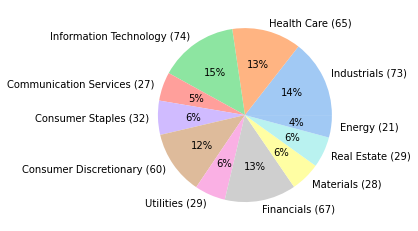

In [146]:
number_of_constituents_by_sector = list()
sectors = list()
for sector in constituents_by_sector:
    sectors.append(sector + ' (' + str(constituents_by_sector[sector].shape[0]) + ')')
    number_of_constituents_by_sector.append(constituents_by_sector[sector].shape[0])

colors = sns.color_palette('pastel')[0:len(sectors)]

plt.pie(number_of_constituents_by_sector, labels = sectors, colors = colors, autopct='%.0f%%')
plt.show()

### Stocks selection

In [147]:
def change_to_hypen(symbol):
    """
        Description: Change the dot character to hypen in the symbol. For instance, the symbol BF.B will be changed to BF-B.
    """
    new_symbol = ''
    for i in range(len(symbol)):
        if(symbol[i] == '.'):
            new_symbol += '-'
        else:
            new_symbol += symbol[i]
    return new_symbol

In [148]:
p = 0.1 # percentage of stocks that will be selected from each sector
constituent_symbols = list()
for sector in constituents_by_sector:
    sector_constituents = constituents_by_sector[sector]
    n = math.ceil(sector_constituents.shape[0]*p) # Number of stocks that will be selected from this sector
    constituents_already_selected = set()
    number_selections = 0
    random.seed(2018)
    while(number_selections < n):
        index = random.randint(0, sector_constituents.shape[0] - 1)
        if(index not in constituents_already_selected):
            constituent_symbols.append(change_to_hypen(sector_constituents.iloc[index]['Symbol']))
            constituents_already_selected.add(index)
            number_selections += 1
print(str(len(constituent_symbols)) + " constituents have been selected")
print(constituent_symbols)

55 constituents have been selected
['URI', 'DOV', 'ALLE', 'PWR', 'TDG', 'LHX', 'DAL', 'ROK', 'CTLT', 'A', 'REGN', 'ZTS', 'JNJ', 'CAH', 'TFX', 'TRMB', 'CDAY', 'AKAM', 'NXPI', 'SNPS', 'JNPR', 'CDW', 'PYPL', 'FB', 'CHTR', 'ATVI', 'CAG', 'MO', 'PM', 'LW', 'MHK', 'CZR', 'AMZN', 'HLT', 'PENN', 'PHM', 'EXC', 'AWK', 'AES', 'CB', 'AXP', 'PGR', 'WFC', 'L', 'SCHW', 'SPGI', 'LYB', 'BLL', 'APD', 'MAA', 'CBRE', 'ARE', 'PXD', 'CTRA', 'APA']


## Data gathering

### Data gathering: Retrieve using YH Finance API

In [109]:
conn = http.client.HTTPSConnection("yh-finance.p.rapidapi.com")

headers = {
    'x-rapidapi-host': "yh-finance.p.rapidapi.com",
    'x-rapidapi-key': "fc1708951fmshca8b1e8a9e96604p126192jsnf88ca47a0efd"
    }

In [110]:
indicators = {}
progress = 0
for symbol in constituent_symbols:
    print(f"Progress: {math.floor((progress*100)/len(constituent_symbols))}%")
    conn.request("GET", f"/stock/v3/get-chart?interval=1d&symbol={symbol}&range=10y&region=US&includePrePost=false&useYfid=true&includeAdjustedClose=true&events=capitalGain%2Cdiv%2Csplit", headers=headers)
    res = conn.getresponse()
    data = res.read()

    result = json.loads(data.decode("utf-8"))["chart"]["result"][0]

    indicators[symbol] = {
        "date": list(map(lambda x: datetime.datetime.fromtimestamp(x), result["timestamp"])),
        "high": result["indicators"]["quote"][0]["high"],
        "volume": result["indicators"]["quote"][0]["volume"],
        "open": result["indicators"]["quote"][0]["open"],
        "low": result["indicators"]["quote"][0]["low"],
        "close": result["indicators"]["quote"][0]["close"],
        "adjclose": result["indicators"]["adjclose"][0]["adjclose"]
    }
    progress += 1

Progress: 0%
Progress: 1%
Progress: 3%
Progress: 5%
Progress: 7%
Progress: 9%
Progress: 10%
Progress: 12%
Progress: 14%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 21%
Progress: 23%
Progress: 25%
Progress: 27%
Progress: 29%
Progress: 30%
Progress: 32%
Progress: 34%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 41%
Progress: 43%
Progress: 45%
Progress: 47%
Progress: 49%
Progress: 50%
Progress: 52%
Progress: 54%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 61%
Progress: 63%
Progress: 65%
Progress: 67%
Progress: 69%
Progress: 70%
Progress: 72%
Progress: 74%
Progress: 76%
Progress: 78%
Progress: 80%
Progress: 81%
Progress: 83%
Progress: 85%
Progress: 87%
Progress: 89%
Progress: 90%
Progress: 92%
Progress: 94%
Progress: 96%
Progress: 98%


In [111]:
dfs = {}
for symbol in constituent_symbols:
    dfs[symbol] = pd.DataFrame(indicators[symbol])

### Data gathering: Store in Local Storage

In [112]:
progress = 0
for symbol in constituent_symbols:
    print(f"Progress: {math.floor((progress*100)/len(constituent_symbols))}%")
    f = open(f"data/stocks/{symbol}.csv", "w")
    f.write(dfs[symbol].to_csv(index=False))
    f.close()
    progress += 1
print(f"Progress: {100}%")

Progress: 0%
Progress: 1%
Progress: 3%
Progress: 5%
Progress: 7%
Progress: 9%
Progress: 10%
Progress: 12%
Progress: 14%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 21%
Progress: 23%
Progress: 25%
Progress: 27%
Progress: 29%
Progress: 30%
Progress: 32%
Progress: 34%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 41%
Progress: 43%
Progress: 45%
Progress: 47%
Progress: 49%
Progress: 50%
Progress: 52%
Progress: 54%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 61%
Progress: 63%
Progress: 65%
Progress: 67%
Progress: 69%
Progress: 70%
Progress: 72%
Progress: 74%
Progress: 76%
Progress: 78%
Progress: 80%
Progress: 81%
Progress: 83%
Progress: 85%
Progress: 87%
Progress: 89%
Progress: 90%
Progress: 92%
Progress: 94%
Progress: 96%
Progress: 98%
Progress: 100%


### Data gathering: Retrieve from Local Storage

In [149]:
dfs = {}
progress = 0
for symbol in constituent_symbols:
    print(f"Progress: {math.floor((progress*100)/len(constituent_symbols))}%")
    dfs[symbol] = pd.read_csv(f"data/stocks/{symbol}.csv")
    date = dfs[symbol]['date']
    dfs[symbol] = dfs[symbol].drop(['date'], axis = 1)
    dfs[symbol]['date'] = date.map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    progress += 1
print(f"Progress: {100}%")

Progress: 0%
Progress: 1%
Progress: 3%
Progress: 5%
Progress: 7%
Progress: 9%
Progress: 10%
Progress: 12%
Progress: 14%
Progress: 16%
Progress: 18%
Progress: 20%
Progress: 21%
Progress: 23%
Progress: 25%
Progress: 27%
Progress: 29%
Progress: 30%
Progress: 32%
Progress: 34%
Progress: 36%
Progress: 38%
Progress: 40%
Progress: 41%
Progress: 43%
Progress: 45%
Progress: 47%
Progress: 49%
Progress: 50%
Progress: 52%
Progress: 54%
Progress: 56%
Progress: 58%
Progress: 60%
Progress: 61%
Progress: 63%
Progress: 65%
Progress: 67%
Progress: 69%
Progress: 70%
Progress: 72%
Progress: 74%
Progress: 76%
Progress: 78%
Progress: 80%
Progress: 81%
Progress: 83%
Progress: 85%
Progress: 87%
Progress: 89%
Progress: 90%
Progress: 92%
Progress: 94%
Progress: 96%
Progress: 98%
Progress: 100%


## Trading signal functions

### Simple Moving Average (SMA)

In [150]:
def SMA(num_periods, close_prices):
    """
        Input:
            - num_periods: number of time periods over which to average -> int
            - close_prices: a Series object containing the close prices over which to calculate the SMA values -> pandas.core.series.Series
        Output:
            SMA values
    """
    sma_values = []
    
    history = [] # history of prices
    for close_price in close_prices:
        history.append(close_price)
        if(len(history) > num_periods): # remove the oldest price because we only average over the last 'numPeriods' prices
            del history[0]
        sma_values.append(stats.mean(history))
        
    return sma_values

### Exponential Moving Average (EMA)

In [151]:
def EMA(num_periods, close_prices):
    """
        Input:
            - num_periods: number of time periods over which to average -> int
            - close_prices: a Series object containing the close prices over which to calculate the EMA values -> pandas.core.series.Series
        Output:
            EMA values
    """
    ema_values = []
    
    K = 2 / (num_periods + 1) # smoothing constant
    ema = 0
    
    for close_price in close_prices:
        if(ema == 0):
            ema = close_price
        else:
            ema = (close_price - ema) * K + ema
        ema_values.append(ema)
    
    return ema_values

### Absolute Price Oscillator (APO)

In [152]:
def APO(num_periods_fast, num_periods_slow, close_prices):
    """
        Input:
            - num_periods_fast: number of time periods for the fast EMA -> int
            - num_periods_slow: number of time periods for the slow EMA -> int
            - close_prices: a Series object containing the close prices over which to calculate the APO values -> pandas.core.series.Series
        Output:
            APO values
    """
    apo_values = []

    ema_fast = 0
    K_fast = 2 / (num_periods_fast + 1) # fast EMA smoothing factor
    ema_slow = 0
    K_slow = 2 / (num_periods_slow + 1) # slow EMA smoothing factor
    
    for close_price in close_prices:
        if(ema_fast == 0): # First observation
            ema_fast = close_price
            ema_slow = close_price
        else:
            ema_fast = (close_price - ema_fast) * K_fast + ema_fast
            ema_slow = (close_price - ema_slow) * K_slow + ema_slow
        apo_values.append(ema_fast - ema_slow)
        
    return apo_values

### Moving Average Convergence Divergence (MACD)

In [153]:
def MACD(num_periods_fast, num_periods_slow, num_periods_macd, close_prices):
    """
        Input:
            - num_periods_fast: number of time periods for the fast EMA -> int
            - num_periods_slow: number of time periods for the slow EMA -> int
            - num_periods_macd: number of time periods for the MACD EMA -> int
            - close_prices: a Series object containing the close prices over which to calculate the MACD values -> pandas.core.series.Series
        Output:
            MACD values
    """
    macdSignalValues = []
    macdHistogramValues = []

    emaFast = 0
    Kfast = 2 / (numPeriodsFast + 1) # fast EMA smoothing factor
    emaSlow = 0
    Kslow = 2 / (numPeriodsSlow + 1) # slow EMA smoothing factor
    emaMacd = 0
    Kmacd = 2 / (numPeriodsMacd + 1) # MACD EMA smoothing factor
    
    for closePrice in indicators[symbol]['close']:
        if(emaFast == 0): # First observation
            emaFast = closePrice
            emaSlow = closePrice
        else:
            emaFast = (closePrice - emaFast) * Kfast + emaFast
            emaSlow = (closePrice - emaSlow) * Kslow + emaSlow
        
        macd = emFast - emaSlow
        if(emaMacd == 0):
            emaMacd = macd
        else:
            emaMacd = (macd - emaMacd) * Kmacd + emaMacd
        
        macdSignalValues.append(emaMacd)
        macdHistogramValues.append(macd - emaMacd)
        
    return macdSignalValues, macdHistogramValues

## Data understanding

URI
            high   volume        open         low       close    adjclose  \
0      43.580002  1523800   43.119999   42.340000   43.259998   43.259998   
1      43.419998  2054000   43.349998   42.180000   42.580002   42.580002   
2      42.599998  2459000   42.369999   41.689999   42.070000   42.070000   
3      41.799999  1365800   41.610001   40.830002   41.070000   41.070000   
4      42.770000  2127600   41.360001   41.250000   42.320000   42.320000   
...          ...      ...         ...         ...         ...         ...   
2511  320.299988   904500  301.940002  301.940002  310.679993  310.679993   
2512  320.989990   704800  318.989990  314.079987  315.790009  315.790009   
2513  322.339996   439200  312.480011  311.190002  321.250000  321.250000   
2514  330.799988   462900  327.489990  322.450012  322.750000  322.750000   
2515  331.045013   792552  324.220001  318.345001  320.260010  320.260010   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 0

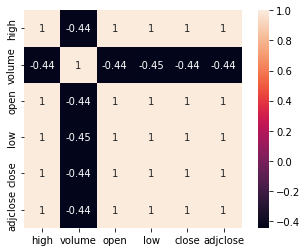




DOV
            high   volume        open         low       close    adjclose  \
0      43.082470  1403327   42.941700   42.552906   43.015438   33.823017   
1      43.169617  1648428   43.109283   42.914886   42.995327   33.807198   
2      43.270164  1359021   42.955109   42.754005   43.042252   33.844097   
3      42.854557  2039575   42.680271   42.311584   42.385323   33.327549   
4      42.345100  2003922   42.345100   41.647953   41.976418   33.006042   
...          ...      ...         ...         ...         ...         ...   
2511  150.309998   889200  147.929993  145.690002  146.190002  146.190002   
2512  153.000000   711500  150.339996  149.820007  151.199997  151.199997   
2513  152.139999   893000  148.880005  148.610001  151.979996  151.979996   
2514  154.330002   773300  153.520004  150.500000  150.630005  150.630005   
2515  154.229996   477710  152.399994  150.990005  151.419998  151.419998   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-1

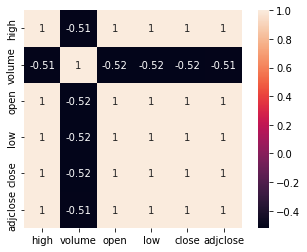




ALLE
            high   volume        open         low       close    adjclose  \
0      50.000000   587100   49.750000   47.490002   48.480000   44.980907   
1      49.000000  1682000   48.990002   45.299999   45.799999   42.494343   
2      46.000000  1106900   45.980000   43.990002   44.650002   41.427334   
3      45.150002   730200   44.500000   43.040001   43.790001   40.629406   
4      44.099998   947600   43.900002   43.250000   43.990002   40.814980   
...          ...      ...         ...         ...         ...         ...   
2090  116.169998   652700  113.370003  113.370003  114.540001  114.120514   
2091  114.290001   526400  113.080002  111.809998  112.900002  112.486519   
2092  113.989998   432800  113.769997  111.279999  111.309998  110.902344   
2093  113.629997   629900  112.150002  110.010002  111.949997  111.540001   
2094  113.625000   572676  112.150002  110.010002  111.949997  111.540001   

                    date  
0    2013-11-18 09:30:00  
1    2013-11-

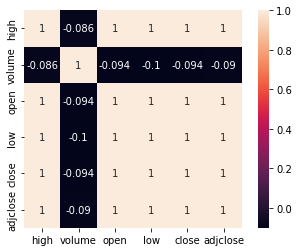




PWR
            high   volume        open         low       close    adjclose  \
0      21.900000  1534400   21.639999   21.510000   21.889999   21.610273   
1      22.150000  1664400   21.920000   21.900000   21.940001   21.659636   
2      21.920000  1315300   21.860001   21.570000   21.780001   21.501678   
3      21.600000  1563400   21.600000   21.129999   21.389999   21.116659   
4      21.610001  1801000   21.389999   21.139999   21.309999   21.037682   
...          ...      ...         ...         ...         ...         ...   
2512  121.150002  2264000  117.820000  116.760002  118.720001  118.720001   
2513  121.480003  1636100  116.989998  116.639999  121.050003  121.050003   
2514  124.949997  1963100  121.500000  121.500000  123.320000  123.320000   
2515  124.660004  1837100  123.180000  121.279999  122.599998  122.599998   
2516  124.660004  1826416  123.180000  121.279999  122.599998  122.599998   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-1

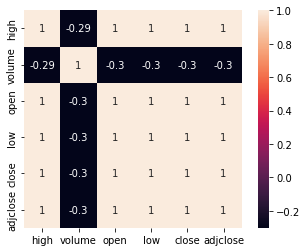




TDG
            high  volume        open         low       close    adjclose  \
0     115.760002  500400  115.330002  113.500000  115.300003   59.563248   
1     115.570000  410700  115.099998  114.239998  115.320000   59.573589   
2     114.669998  599900  113.639999  111.769997  113.150002   58.452576   
3     113.550003  432200  112.230003  110.599998  113.250000   58.504238   
4     115.040001  463200  113.540001  113.169998  114.639999   59.222298   
...          ...     ...         ...         ...         ...         ...   
2512  639.020020  406600  615.270020  611.609985  633.929993  633.929993   
2513  647.469971  315200  620.330017  620.330017  633.679993  633.679993   
2514  646.919983  292600  638.539978  623.270020  623.989990  623.989990   
2515  632.429993  510100  625.330017  613.869995  618.429993  618.429993   
2516  632.429993  505800  625.330017  613.869995  618.429993  618.429993   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  

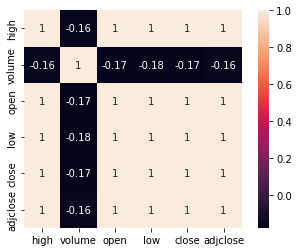




LHX
            high   volume        open         low       close    adjclose  \
0      44.320000   585000   43.930000   43.740002   44.200001   35.356583   
1      44.540001   972900   44.380001   44.230000   44.400002   35.516563   
2      45.099998   623700   44.450001   44.029999   44.369999   35.492577   
3      44.119999   457400   44.119999   43.619999   43.990002   35.188606   
4      43.980000   552600   43.980000   43.349998   43.820000   35.052612   
...          ...      ...         ...         ...         ...         ...   
2511  270.250000  2303200  269.899994  261.140015  261.859985  260.712250   
2512  261.700012  2131900  258.540009  252.190002  255.529999  254.410004   
2513  260.200012  1550000  254.470001  252.210007  254.000000  254.000000   
2514  257.000000  2112900  254.990005  249.800003  250.000000  250.000000   
2515  253.440002  1884777  251.759995  246.339996  250.110001  250.110001   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-1

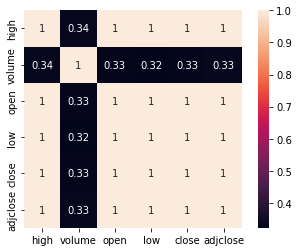




DAL
           high    volume       open        low      close   adjclose  \
0      9.830000  22472900   9.290000   9.250000   9.630000   8.554421   
1      9.690000  14737100   9.660000   9.210000   9.210000   8.181332   
2      9.410000   9817500   9.250000   9.170000   9.310000   8.270164   
3      9.630000   9882800   9.360000   9.240000   9.530000   8.465592   
4      9.930000  21023800   9.580000   9.450000   9.740000   8.652135   
...         ...       ...        ...        ...        ...        ...   
2512  33.779999  25808000  32.930000  32.560001  32.759998  32.759998   
2513  33.410000  17588900  32.119999  31.520000  32.549999  32.549999   
2514  33.400002  16963000  33.310001  32.009998  32.070000  32.070000   
2515  33.200001  17235500  32.000000  31.650000  32.070000  32.070000   
2516  33.200001  17162485  32.000000  31.650000  32.070000  32.070000   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    201

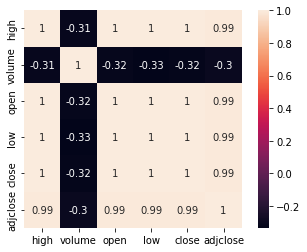




ROK
            high   volume        open         low       close    adjclose  \
0      84.540001   825800   83.800003   83.199997   84.300003   68.253296   
1      84.500000  1166600   83.809998   83.430000   83.709999   67.775604   
2      84.029999   566500   83.889999   83.220001   83.419998   67.540787   
3      82.949997  1212200   82.879997   80.959999   81.419998   65.921478   
4      81.769997   747200   81.389999   80.900002   81.419998   65.921478   
...          ...      ...         ...         ...         ...         ...   
2512  281.649994  1036700  279.820007  270.450012  271.040009  271.040009   
2513  266.929993   911800  265.529999  259.010010  262.549988  262.549988   
2514  266.119995   700900  264.760010  256.670013  257.010010  257.010010   
2515  261.820007   741000  260.000000  252.850006  256.350006  256.350006   
2516  261.820007   734067  260.000000  252.850006  256.350006  256.350006   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-1

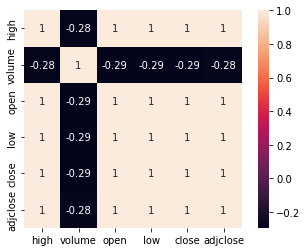




CTLT
            high    volume       open        low      close   adjclose  \
0      20.330000  14208300  20.000000  19.299999  19.990000  19.990000   
1      20.100000   2125600  20.000000  19.340000  19.850000  19.850000   
2      20.100000    592800  19.850000  19.600000  20.010000  20.010000   
3      20.480000   1077600  19.940001  19.770000  20.209999  20.209999   
4      20.330000    900900  20.200001  20.049999  20.330000  20.330000   
...          ...       ...        ...        ...        ...        ...   
1915   99.129997    814700  96.050003  95.709999  98.690002  98.690002   
1916   98.519997    743800  96.919998  96.010002  98.330002  98.330002   
1917   99.089996   1004100  99.080002  96.040001  96.120003  96.120003   
1918  100.000000    876700  97.010002  95.379997  95.650002  95.650002   
1919  100.000000    858615  97.010002  95.379997  95.650002  95.650002   

                    date  
0    2014-07-31 08:30:00  
1    2014-08-01 08:30:00  
2    2014-08-04 08:30:

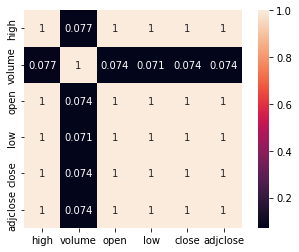




A
            high   volume        open         low       close    adjclose  \
0      32.846924  2972148   32.260372   32.081547   32.804005   29.617506   
1      32.904148  3186601   32.854076   32.439198   32.632332   29.462511   
2      32.689556  3337445   32.510731   32.303291   32.446350   29.294586   
3      32.296139  2416723   32.253220   31.831186   32.067238   28.952311   
4      32.274677  2198495   32.110157   31.759657   31.988556   28.881260   
...          ...      ...         ...         ...         ...         ...   
2511  132.500000  2375500  128.639999  127.540001  129.320007  129.320007   
2512  133.940002  1805500  132.850006  131.190002  133.259995  133.259995   
2513  134.520004  1933100  131.399994  131.289993  134.330002  134.330002   
2514  136.440002  1815700  135.429993  130.160004  130.309998  130.309998   
2515  132.259995  1695508  131.000000  126.900002  127.580002  127.580002   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 

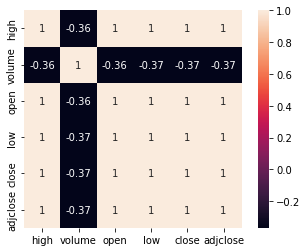




REGN
            high   volume        open         low       close    adjclose  \
0     115.989998   855000  111.199997  110.010002  115.750000  115.750000   
1     118.120003  1313500  115.320000  114.540001  115.330002  115.330002   
2     116.339996   591100  115.129997  113.849998  115.349998  115.349998   
3     117.389999   811200  114.870003  113.620003  116.459999  116.459999   
4     119.410004  1121700  116.550003  115.000000  117.430000  117.430000   
...          ...      ...         ...         ...         ...         ...   
2511  627.340027   592200  611.169983  609.030029  614.739990  614.739990   
2512  626.679993   538900  622.200012  614.210022  623.429993  623.429993   
2513  632.679993   480600  616.130005  615.919983  630.359985  630.359985   
2514  652.270020   802900  633.799988  630.669983  642.580017  642.580017   
2515  665.979980  1016288  644.599976  644.599976  656.409973  656.409973   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-

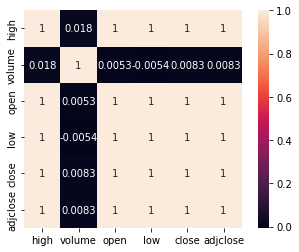




ZTS
            high    volume        open         low       close    adjclose  \
0      31.740000  66789100   31.500000   30.469999   31.010000   29.118633   
1      31.990000   7695400   31.090000   30.760000   31.020000   29.128025   
2      31.980000   5013200   31.250000   30.850000   31.040001   29.146807   
3      31.430000   2126100   30.980000   30.750000   31.030001   29.137421   
4      32.730000   3800800   31.000000   31.000000   32.000000   30.048256   
...          ...       ...         ...         ...         ...         ...   
2291  190.699997   2630400  185.550003  183.800003  189.580002  189.580002   
2292  189.600006   1995100  187.389999  186.139999  189.220001  189.220001   
2293  190.279999   1589700  189.949997  185.169998  185.289993  185.289993   
2294  187.259995   2044800  186.419998  183.889999  184.660004  184.660004   
2295  187.259995   2005924  186.419998  183.884995  184.660004  184.660004   

                    date  
0    2013-02-01 09:30:00  
1 

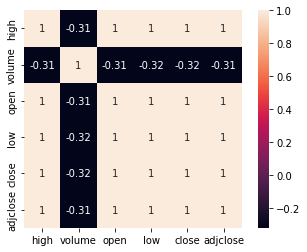




JNJ
            high    volume        open         low       close    adjclose  \
0      65.379997  11372900   64.930000   64.849998   65.070000   49.168705   
1      65.459999  17707000   65.199997   64.809998   65.120003   49.206501   
2      65.269997   7321800   64.949997   64.900002   65.209999   49.274498   
3      65.129997   7760400   65.000000   64.760002   64.959999   49.085594   
4      65.070000   7839600   64.959999   64.639999   64.760002   48.934467   
...          ...       ...         ...         ...         ...         ...   
2512  170.229996   7248200  170.009995  167.889999  169.360001  169.360001   
2513  170.149994   6171400  168.559998  168.080002  169.660004  169.660004   
2514  171.460007   5188000  169.130005  169.020004  169.350006  169.350006   
2515  174.119995   7729100  170.679993  170.350006  171.690002  171.690002   
2516  174.119995   7535395  170.679993  170.350006  171.690002  171.690002   

                    date  
0    2012-03-15 08:30:00  
1 

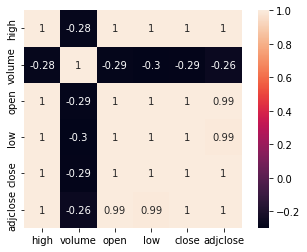




CAH
           high   volume       open        low      close   adjclose  \
0     41.740002  1231800  41.610001  41.349998  41.700001  31.027710   
1     41.950001  2149900  41.750000  41.490002  41.590000  30.945858   
2     41.669998  1446000  41.500000  41.200001  41.230000  30.677984   
3     41.180000  2077800  41.029999  40.779999  40.820000  30.372940   
4     41.509998  3904600  40.750000  40.549999  41.410000  30.811934   
...         ...      ...        ...        ...        ...        ...   
2511  53.299999  2437800  52.520000  52.049999  52.430000  52.430000   
2512  53.840000  1576800  53.490002  53.090000  53.189999  53.189999   
2513  53.320000  1595700  52.779999  52.509998  53.169998  53.169998   
2514  53.410000  1649100  52.950001  52.529999  52.570000  52.570000   
2515  53.290001  2266834  53.150002  51.990002  52.610001  52.610001   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    2012-03-20 08:3

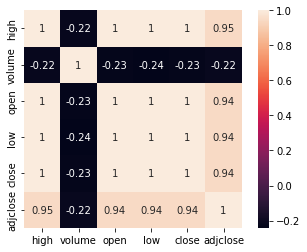




TFX
            high  volume        open         low       close    adjclose  \
0      60.439999  226100   59.049999   58.830002   60.349998   55.196560   
1      60.730000  225900   60.730000   60.310001   60.360001   55.205711   
2      60.610001  126100   60.410000   59.860001   60.320000   55.169121   
3      60.290001  119000   60.139999   59.759998   59.830002   54.720978   
4      59.880001  106100   59.869999   59.130001   59.480000   54.400860   
...          ...     ...         ...         ...         ...         ...   
2511  346.230011  646800  345.299988  336.869995  336.959991  336.959991   
2512  348.369995  447100  341.820007  341.820007  343.100006  343.100006   
2513  340.549988  298400  336.989990  334.549988  339.350006  339.350006   
2514  344.480011  271900  342.440002  335.850006  335.989990  335.989990   
2515  340.174988  226660  336.459991  332.338989  334.609985  334.609985   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  

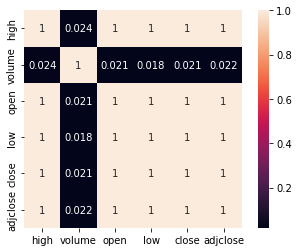




TRMB
           high   volume       open        low      close   adjclose  \
0     27.299999  2069200  26.344999  26.165001  27.264999  27.264999   
1     27.375000  1786400  27.254999  27.010000  27.195000  27.195000   
2     27.500000  1179400  27.059999  26.950001  27.245001  27.245001   
3     27.160000  1022600  26.965000  26.719999  27.065001  27.065001   
4     27.424999   842800  27.065001  26.870001  27.219999  27.219999   
...         ...      ...        ...        ...        ...        ...   
2511  66.160004  1562000  63.410000  62.880001  64.430000  64.430000   
2512  67.959999  1439700  66.209999  65.629997  67.709999  67.709999   
2513  67.160004   913700  66.040001  65.360001  66.610001  66.610001   
2514  67.739998   926600  67.570000  65.410004  65.470001  65.470001   
2515  65.959999  1306936  65.820000  63.700001  64.230003  64.230003   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    2012-03-20 08:

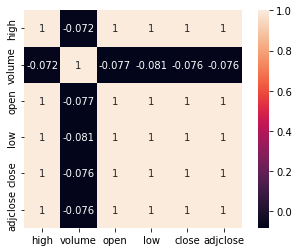




CDAY
          high    volume       open        low      close   adjclose  \
0    31.750000  13590200  28.900000  28.650000  31.209999  31.209999   
1    31.500000   1744900  30.950001  29.680000  30.520000  30.520000   
2    32.000000    638900  30.760000  30.209999  31.580000  31.580000   
3    32.400002    858600  31.420000  31.260000  31.480000  31.480000   
4    33.650002    845500  31.480000  31.480000  32.750000  32.750000   
..         ...       ...        ...        ...        ...        ...   
974  67.370003   1675700  62.930000  62.480000  66.040001  66.040001   
975  64.720001   1387100  64.680000  62.330002  64.040001  64.040001   
976  65.250000    943700  65.089996  61.299999  61.380001  61.380001   
977  62.820999   1963400  61.590000  58.820000  59.419998  59.419998   
978  62.820999   1448488  65.089996  58.820000  59.419998  59.419998   

                   date  
0   2018-04-26 08:30:00  
1   2018-04-27 08:30:00  
2   2018-04-30 08:30:00  
3   2018-05-01 08:30:00

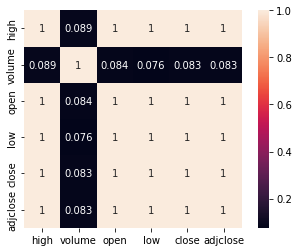




AKAM
            high   volume        open         low       close    adjclose  \
0      37.490002  2352000   36.869999   36.599998   37.349998   37.349998   
1      37.619999  2709900   37.439999   37.209999   37.360001   37.360001   
2      37.500000  1816900   37.290001   36.660000   37.040001   37.040001   
3      36.790001  1717400   36.700001   36.180000   36.750000   36.750000   
4      37.150002  2617200   36.680000   36.439999   36.939999   36.939999   
...          ...      ...         ...         ...         ...         ...   
2511  112.449997  2401600  111.269997  106.940002  107.070000  107.070000   
2512  109.910004  1729400  108.050003  106.269997  109.180000  109.180000   
2513  109.930000  1386000  108.260002  106.839996  109.529999  109.529999   
2514  110.300003  1242400  109.690002  108.250000  108.440002  108.440002   
2515  110.059998  1478953  107.959999  107.510002  108.080002  108.080002   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-

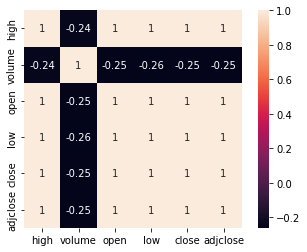




NXPI
            high   volume        open         low       close    adjclose  \
0      26.059999   988000   25.730000   25.389999   25.620001   24.456741   
1      26.400000  1305000   25.610001   25.400000   26.270000   25.077229   
2      26.410000  1223700   26.230000   25.719999   26.330000   25.134502   
3      26.170000   810300   26.000000   25.559999   25.860001   24.685848   
4      26.389999   771000   25.820000   25.520000   26.049999   24.867216   
...          ...      ...         ...         ...         ...         ...   
2511  185.440002  4006600  170.619995  168.740005  176.899994  176.062851   
2512  186.270004  3108900  183.000000  182.199997  183.350006  182.482330   
2513  181.320007  1899200  179.240005  175.820007  180.500000  179.645813   
2514  185.270004  2176500  183.979996  178.160004  178.559998  177.714996   
2515  179.639999  2515948  178.380005  170.220001  171.710007  171.710007   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-

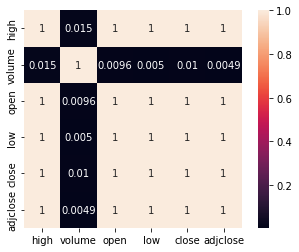




SNPS
            high   volume        open         low       close    adjclose  \
0      30.780001   622800   30.480000   30.420000   30.770000   30.770000   
1      30.879999  1445400   30.870001   30.200001   30.350000   30.350000   
2      30.500000   478000   30.250000   30.120001   30.400000   30.400000   
3      30.370001   388500   30.240000   30.110001   30.190001   30.190001   
4      30.389999   405400   30.299999   30.170000   30.200001   30.200001   
...          ...      ...         ...         ...         ...         ...   
2511  305.790009   911100  292.220001  289.339996  296.350006  296.350006   
2512  309.709991   809800  303.720001  302.200012  307.790009  307.790009   
2513  303.839996   941800  300.440002  291.519989  300.839996  300.839996   
2514  305.920013   953200  305.000000  293.149994  293.690002  293.690002   
2515  295.920013  1169009  292.070007  277.190002  278.980011  278.980011   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-

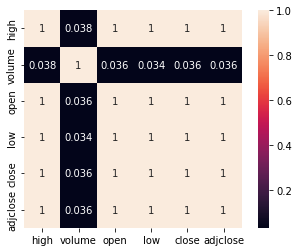




JNPR
           high   volume       open        low      close   adjclose  \
0     21.379999  8945700  20.680000  20.639999  21.330000  17.799185   
1     21.490000  5151600  21.389999  21.209999  21.430000  17.882633   
2     21.760000  5628800  21.440001  21.350000  21.660000  18.074566   
3     21.299999  7783800  20.930000  20.900000  21.150000  17.648979   
4     21.350000  6086600  20.870001  20.870001  21.180000  17.674021   
...         ...      ...        ...        ...        ...        ...   
2511  33.610001  4374600  33.259998  32.549999  32.880001  32.880001   
2512  33.939999  2463000  33.610001  33.320000  33.689999  33.689999   
2513  33.900002  3792500  33.500000  33.139999  33.250000  33.250000   
2514  34.240002  2399700  33.560001  33.110001  33.139999  33.139999   
2515  33.740002  3933726  33.400002  32.945000  33.290001  33.290001   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    2012-03-20 08:

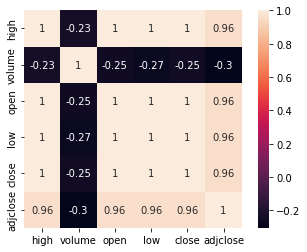




CDW
            high   volume        open         low       close    adjclose  \
0      18.750000  8285800   17.639999   17.379999   18.370001   16.799835   
1      19.170000   717400   18.400000   18.379999   18.620001   17.028471   
2      18.900000   394200   18.650000   18.340000   18.340000   16.772394   
3      19.639999   223800   18.340000   18.260000   19.219999   17.577183   
4      19.209999   103700   18.990000   18.670000   19.080000   17.449148   
...          ...      ...         ...         ...         ...         ...   
2190  171.899994   720200  169.160004  166.940002  171.000000  171.000000   
2191  170.550003   438600  168.199997  167.029999  170.119995  170.119995   
2192  172.820007   751400  171.630005  169.820007  170.000000  170.000000   
2193  171.910004   799200  170.880005  165.199997  166.600006  166.600006   
2194  171.910004   800150  170.880005  165.195007  166.600006  166.600006   

                    date  
0    2013-06-27 08:30:00  
1    2013-06-2

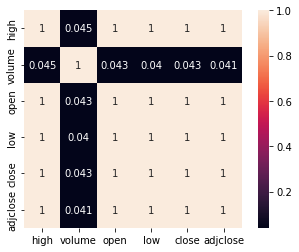




PYPL
            high    volume       open        low       close    adjclose  \
0      39.750000   5866600  38.000000  36.000000   36.709999   36.709999   
1      37.810001   7359000  37.720001  36.000000   36.619999   36.619999   
2      36.360001   5387700  36.340000  34.529999   34.700001   34.700001   
3      35.520000   3760100  35.099998  33.990002   34.500000   34.500000   
4      35.189999   4472800  34.660000  33.980000   34.689999   34.689999   
...          ...       ...        ...        ...         ...         ...   
1682  100.730003  20811300  98.120003  97.290001  100.220001  100.220001   
1683   99.320000  14703200  99.050003  96.400002   98.550003   98.550003   
1684   99.820000  15117200  99.750000  95.519997   96.570000   96.570000   
1685  100.639999  20969400  96.044998  94.629997   96.870003   96.870003   
1686  100.639999  20957703  96.044998  94.629997   96.870003   96.870003   

                    date  
0    2015-07-06 08:30:00  
1    2015-07-07 08:30:00 

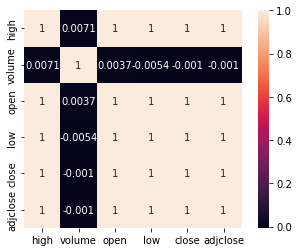




FB
            high     volume        open         low       close    adjclose  \
0      45.000000  573576400   42.049999   38.000000   38.230000   38.230000   
1      36.660000  168192700   36.529999   33.000000   34.029999   34.029999   
2      33.590000  101786600   32.610001   30.940001   31.000000   31.000000   
3      32.500000   73600000   31.370001   31.360001   32.000000   32.000000   
4      33.209999   50237200   32.950001   31.770000   33.029999   33.029999   
...          ...        ...         ...         ...         ...         ...   
2467  199.100006   31894700  195.740005  193.919998  198.500000  198.500000   
2468  196.279999   24853000  194.839996  191.070007  195.210007  195.210007   
2469  193.559998   34656900  192.639999  186.669998  187.610001  187.610001   
2470  192.289993   30980700  187.029999  185.820007  186.630005  186.630005   
2471  192.289993   31010462  187.029999  185.820007  186.630005  186.630005   

                    date  
0    2012-05-18 08

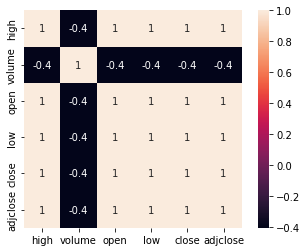




CHTR
            high   volume        open         low       close    adjclose  \
0      63.840000   214900   63.189999   62.750000   63.490002   63.490002   
1      64.070000   375300   63.599998   63.189999   63.990002   63.990002   
2      64.080002   220500   63.740002   63.430000   63.970001   63.970001   
3      63.610001   285000   63.549999   63.099998   63.230000   63.230000   
4      64.169998   235500   63.040001   62.910000   64.010002   64.010002   
...          ...      ...         ...         ...         ...         ...   
2512  568.039978  1212200  562.169983  555.570007  557.750000  557.750000   
2513  567.559998  1537700  550.210022  546.919983  562.130005  562.130005   
2514  574.539978  1788200  569.780029  557.809998  559.289978  559.289978   
2515  583.719971  1420600  561.820007  560.659973  566.140015  566.140015   
2516  583.719971  1389223  561.820007  560.659973  566.140015  566.140015   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-

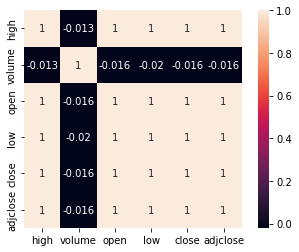




ATVI
           high    volume       open        low      close   adjclose  \
0     12.540000  14892900  12.280000  12.230000  12.460000  11.434643   
1     12.710000  12248100  12.440000  12.440000  12.650000  11.609007   
2     12.630000  14165600  12.450000  12.340000  12.520000  11.655555   
3     12.560000  10756400  12.460000  12.260000  12.520000  11.655555   
4     12.590000   6021000  12.510000  12.440000  12.530000  11.664864   
...         ...       ...        ...        ...        ...        ...   
2512  81.489998   9914500  81.370003  80.660004  80.830002  80.830002   
2513  81.269997   6981400  80.769997  80.570000  80.800003  80.800003   
2514  81.199997  10713900  80.800003  80.180000  80.309998  80.309998   
2515  80.440002   9533000  80.050003  79.449997  79.550003  79.550003   
2516  80.445000   9535962  80.050003  79.449997  79.550003  79.550003   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    20

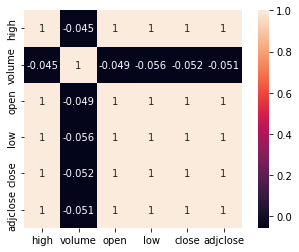




CAG
           high   volume       open        low      close   adjclose  \
0     20.684826  2590946  20.505836  20.459145  20.684826  14.845315   
1     20.817122  3956772  20.731518  20.482491  20.568092  14.761538   
2     20.645914  2605980  20.544746  20.505836  20.513618  14.722442   
3     20.544746  2359003  20.466927  20.435799  20.474709  14.694518   
4     20.552528  3485691  20.459145  20.435799  20.513618  14.722442   
...         ...      ...        ...        ...        ...        ...   
2512  32.250000  5442800  31.360001  31.170000  31.180000  31.180000   
2513  31.070000  7632500  31.000000  30.180000  30.670000  30.670000   
2514  30.879999  5523800  30.780001  30.059999  30.100000  30.100000   
2515  32.049999  9878700  30.830000  30.510000  31.570000  31.570000   
2516  32.049999  9806805  30.830000  30.504999  31.570000  31.570000   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    2012-03-20 08:3

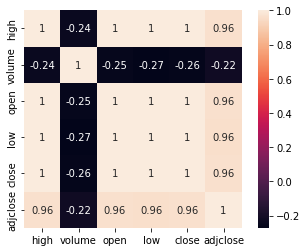




MO
           high    volume       open        low      close   adjclose  \
0     30.030001   8475100  29.959999  29.770000  30.030001  17.712654   
1     30.160000  12960900  30.049999  29.930000  30.030001  17.712654   
2     30.190001   7742700  29.969999  29.889999  30.110001  17.759842   
3     30.219999   6278100  29.969999  29.940001  30.129999  17.771635   
4     30.240000   6336200  30.110001  30.030001  30.150000  17.783426   
...         ...       ...        ...        ...        ...        ...   
2512  51.770000   9772300  51.549999  50.900002  51.000000  51.000000   
2513  51.439999   7567200  50.889999  50.310001  51.230000  51.230000   
2514  51.549999   9433800  51.080002  50.410000  50.480000  50.480000   
2515  51.119999  11266000  50.650002  49.790001  50.540001  50.540001   
2516  51.119999  10438716  50.650002  49.790001  50.540001  50.540001   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    2012

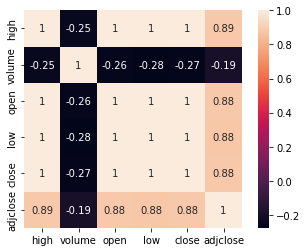




PM
           high    volume       open        low      close   adjclose  \
0     85.900002   4849500  85.459999  85.239998  85.900002  53.179585   
1     86.169998   7930600  85.970001  85.540001  85.809998  53.123882   
2     86.599998   3724600  85.820000  85.459999  86.339996  53.452000   
3     86.660004   4578900  85.830002  85.820000  86.540001  53.575832   
4     86.699997   4892200  86.540001  86.059998  86.120003  53.315804   
...         ...       ...        ...        ...        ...        ...   
2511  96.360001  11529300  94.190002  92.699997  93.970001  93.970001   
2512  96.070000   6427300  95.220001  93.349998  93.809998  93.809998   
2513  93.830002   8099400  92.930000  91.599998  91.889999  91.889999   
2514  92.419998   8628300  92.269997  88.760002  88.870003  88.870003   
2515  90.580002   9927371  89.889999  88.370003  89.589996  89.589996   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    2012

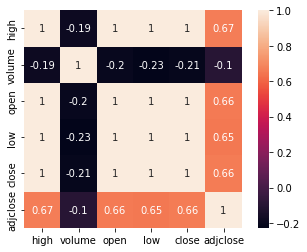




LW
           high    volume       open        low      close   adjclose  \
0     32.349998  35019100  32.040001  29.820000  30.330000  28.248629   
1     30.090000   6020100  29.799999  28.850000  29.889999  27.838821   
2     30.430000   4481900  29.340000  28.750000  30.190001  28.118233   
3     30.700001   3667200  29.639999  29.620001  30.430000  28.341764   
4     32.040001   4342300  30.770000  30.610001  31.700001  29.524607   
...         ...       ...        ...        ...        ...        ...   
1339  55.139999   2195600  53.709999  53.270000  53.320000  53.320000   
1340  52.450001   1335900  52.150002  50.910000  51.330002  51.330002   
1341  51.810001   1500800  51.599998  50.070000  50.110001  50.110001   
1342  51.020000   1556400  50.570000  49.709999  49.959999  49.959999   
1343  51.020000   1538405  50.570000  49.709999  49.959999  49.959999   

                    date  
0    2016-11-10 09:30:00  
1    2016-11-11 09:30:00  
2    2016-11-14 09:30:00  
3    2016

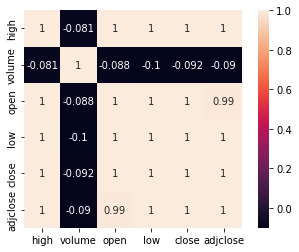




MHK
            high   volume        open         low       close    adjclose  \
0      67.440002   400500   65.900002   65.599998   67.220001   67.220001   
1      67.300003   687000   67.300003   65.449997   65.769997   65.769997   
2      67.099998   468700   65.709999   64.849998   66.440002   66.440002   
3      66.680000   481300   66.029999   64.949997   66.129997   66.129997   
4      66.870003   779700   66.309998   65.419998   65.650002   65.650002   
...          ...      ...         ...         ...         ...         ...   
2511  132.240005  1469000  124.580002  121.040001  128.320007  128.320007   
2512  140.240005  1127600  132.940002  132.320007  136.860001  136.860001   
2513  135.649994   745600  134.119995  131.300003  132.759995  132.759995   
2514  135.679993   864900  135.529999  130.979996  131.110001  131.110001   
2515  133.494995   541738  132.559998  129.860001  131.039993  131.039993   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-1

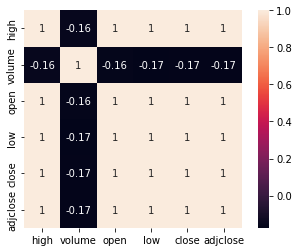




CZR
           high   volume       open        low      close   adjclose  \
0      4.750000    21900   4.750000   4.100000   4.350000   4.350000   
1      4.450000    81700   4.450000   3.900000   4.260000   4.260000   
2      4.340000    94400   3.700000   3.610000   4.340000   4.340000   
3      4.440000    29800   4.350000   3.800000   4.000000   4.000000   
4      4.400000   161500   4.000000   4.000000   4.400000   4.400000   
...         ...      ...        ...        ...        ...        ...   
1879  80.410004  4083800  74.260002  74.250000  77.589996  77.589996   
1880  78.389999  1723700  75.709999  75.180000  77.459999  77.459999   
1881  78.870003  1492000  78.440002  74.320000  74.809998  74.809998   
1882  77.099998  2905700  74.690002  70.555000  71.970001  71.970001   
1883  77.099998  2976874  74.690002  70.559998  71.970001  71.970001   

                    date  
0    2014-09-22 08:30:00  
1    2014-09-23 08:30:00  
2    2014-09-24 08:30:00  
3    2014-09-25 08:3

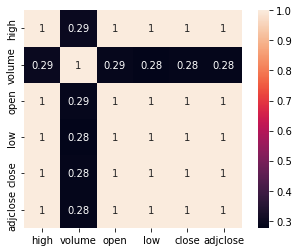




AMZN
             high   volume         open          low        close  \
0      184.429993  4160100   182.020004   180.300003   184.429993   
1      185.679993  4934000   183.279999   182.350006   185.050003   
2      186.679993  3903400   183.449997   183.000000   185.520004   
3      194.410004  9165400   184.880005   182.880005   192.330002   
4      194.279999  4214400   192.500000   191.259995   191.729996   
...           ...      ...          ...          ...          ...   
2511  2813.989990  4583100  2733.669922  2671.449951  2720.290039   
2512  2805.000000  4132800  2790.000000  2736.560059  2785.580078   
2513  2973.489990  6753100  2913.699951  2879.560059  2936.350098   
2514  2993.500000  3440500  2991.489990  2907.379883  2910.489990   
2515  2948.289795  3547636  2919.620117  2817.679932  2837.060059   

         adjclose                date  
0      184.429993 2012-03-15 08:30:00  
1      185.050003 2012-03-16 08:30:00  
2      185.520004 2012-03-19 08:30:00  
3  

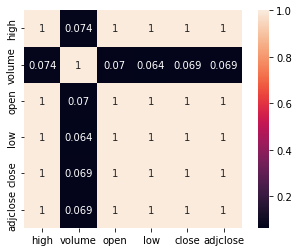




HLT
            high    volume        open         low       close    adjclose  \
0      44.979839  12935478   43.707600   43.605000   44.118000   41.890629   
1      45.923759   1224854   45.123482   44.220600   45.349201   43.059673   
2      52.839001   4717690   47.360161   44.159039   44.159039   41.929592   
3      45.123482   2313840   44.343719   44.282162   44.754120   42.494633   
4      45.513359   2857846   44.795158   44.446320   44.795158   42.533604   
...          ...       ...         ...         ...         ...         ...   
2073  140.669998   3171000  138.500000  137.460007  138.520004  138.520004   
2074  144.330002   3309500  135.490005  135.199997  142.940002  142.940002   
2075  145.800003   1684700  144.580002  141.529999  141.770004  141.770004   
2076  143.910004   1586700  143.190002  140.250000  141.559998  141.559998   
2077  143.904999   1544807  143.190002  140.245300  141.559998  141.559998   

                    date  
0    2013-12-12 09:30:00  
1 

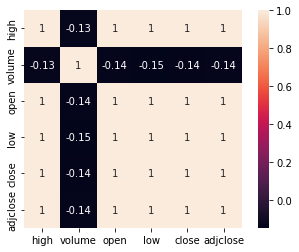




PENN
           high   volume       open        low      close   adjclose  \
0      9.875650  1306997   9.823649   9.762605   9.828171   9.828171   
1      9.864345  1368476   9.825910   9.758083   9.825910   9.825910   
2     10.049740  1831122   9.825910   9.769387   9.950260   9.950260   
3     10.013565  2274307  10.009044   9.893737   9.959304   9.959304   
4     10.153742  2016446  10.004522   9.968347  10.124350  10.124350   
...         ...      ...        ...        ...        ...        ...   
2511  41.959999  8473300  40.919998  39.230000  41.750000  41.750000   
2512  44.630001  4183000  42.790001  42.200001  43.830002  43.830002   
2513  44.430000  3702900  42.939999  42.799999  44.189999  44.189999   
2514  45.000000  2655000  44.709999  42.650002  42.669998  42.669998   
2515  43.540001  3906738  42.500000  39.785000  40.299999  40.299999   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    2012-03-20 08:

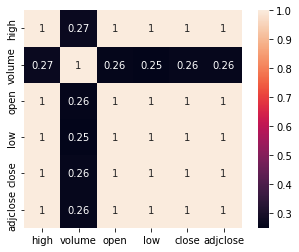




PHM
           high    volume       open        low      close   adjclose  \
0      9.650000   8849200   9.390000   9.270000   9.610000   8.488558   
1      9.690000  13308500   9.680000   9.290000   9.290000   8.205896   
2      9.530000  13377100   9.360000   9.120000   9.160000   8.091069   
3      9.270000  11741100   9.100000   8.950000   9.210000   8.135235   
4      9.550000   7192300   9.320000   9.240000   9.390000   8.294228   
...         ...       ...        ...        ...        ...        ...   
2511  48.040001   2667200  46.150002  45.410000  46.080002  45.931004   
2512  48.490002   2492700  47.400002  47.040001  47.669998  47.515862   
2513  47.270000   2115900  46.560001  45.930000  47.150002  46.997543   
2514  47.709999   1845500  47.580002  46.330002  46.389999  46.240002   
2515  46.400002   2850352  46.400002  43.689999  44.259998  44.259998   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    201

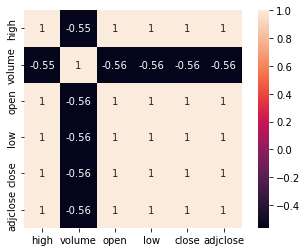




EXC
           high    volume       open        low      close   adjclose  \
0     28.002853   8807364  27.910128  27.689016  27.781740  16.338427   
1     27.817404  11423356  27.796005  27.639088  27.717546  16.300684   
2     27.967190   7709878  27.667618  27.667618  27.796005  16.346817   
3     27.838802   7020235  27.738943  27.674749  27.696148  16.288094   
4     27.724680   6402934  27.689016  27.517832  27.517832  16.183222   
...         ...       ...        ...        ...        ...        ...   
2511  44.290001   8624200  44.160000  43.099998  43.490002  43.490002   
2512  43.919998   8573000  43.740002  43.259998  43.549999  43.549999   
2513  43.810001   9859100  43.310001  43.139999  43.599998  43.599998   
2514  44.400002   6407100  44.240002  43.590000  43.630001  43.630001   
2515  44.119999   6793504  43.700001  43.514999  43.580002  43.580002   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    201

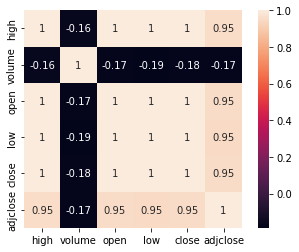




AWK
            high   volume        open         low       close    adjclose  \
0      34.279999   665900   33.910000   33.730000   33.939999   27.489700   
1      34.000000  1123300   33.939999   33.650002   33.799999   27.376299   
2      33.919998   880600   33.700001   33.340000   33.389999   27.044226   
3      33.610001   502800   33.259998   33.209999   33.430000   27.076622   
4      33.599998   581000   33.500000   33.340000   33.450001   27.092817   
...          ...      ...         ...         ...         ...         ...   
2511  159.320007  1363200  157.410004  153.520004  154.250000  154.250000   
2512  156.770004   881200  155.960007  152.610001  153.789993  153.789993   
2513  153.289993   958700  153.240005  151.149994  153.130005  153.130005   
2514  154.929993   964500  153.330002  151.259995  152.080002  152.080002   
2515  154.949997   893177  153.610001  151.639999  152.619995  152.619995   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-1

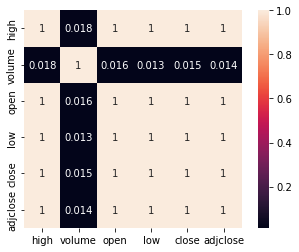




AES
           high   volume       open        low      close   adjclose  \
0     13.190000  7273600  13.050000  13.000000  13.150000   9.783056   
1     13.280000  6697900  13.160000  13.080000  13.170000   9.797933   
2     13.240000  3191900  13.170000  13.100000  13.120000   9.760735   
3     13.170000  5497000  13.020000  12.970000  13.150000   9.783056   
4     13.210000  2374100  13.130000  13.050000  13.090000   9.738420   
...         ...      ...        ...        ...        ...        ...   
2511  22.190001  8533300  22.000000  21.559999  21.559999  21.559999   
2512  22.230000  6540500  21.959999  21.750000  21.959999  21.959999   
2513  22.410000  3953100  21.820000  21.700001  22.350000  22.350000   
2514  22.740000  4679500  22.389999  22.190001  22.200001  22.200001   
2515  22.504999  4476941  22.320000  21.590000  21.719999  21.719999   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    2012-03-20 08:3

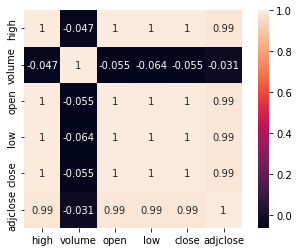




CB
            high   volume        open         low       close    adjclose  \
0      73.809998  2090500   73.150002   72.809998   73.370003   58.236683   
1      73.400002  2317500   73.320000   72.230003   72.269997   57.363602   
2      73.500000  2188400   71.949997   71.949997   73.239998   58.133526   
3      74.029999  1949800   73.000000   72.660004   73.940002   58.689129   
4      74.269997  1727000   74.160004   73.419998   73.660004   58.466881   
...          ...      ...         ...         ...         ...         ...   
2511  203.509995  2071300  200.190002  196.199997  197.649994  197.649994   
2512  205.470001  1479100  202.809998  202.440002  203.940002  203.940002   
2513  203.889999  1902000  201.539993  200.630005  201.419998  201.419998   
2514  204.880005  1424000  202.190002  201.729996  201.910004  201.910004   
2515  207.710007  1142356  205.000000  203.410004  204.960007  204.960007   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16

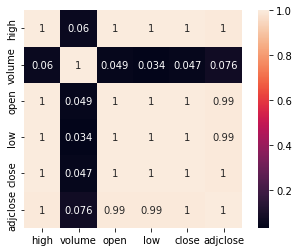




AXP
            high    volume        open         low       close    adjclose  \
0      56.759998   7985300   56.060001   55.660000   56.720001   49.137238   
1      57.380001  11287500   57.310001   56.430000   56.549999   48.989964   
2      57.500000   5605000   56.599998   56.410000   57.270000   49.613693   
3      57.240002   5450400   56.720001   56.529999   56.910000   49.301830   
4      57.500000   6034100   57.080002   56.910000   57.049999   49.423119   
...          ...       ...         ...         ...         ...         ...   
2511  166.289993   7058900  160.520004  155.720001  160.050003  160.050003   
2512  170.729996   4788200  168.020004  166.710007  168.649994  168.649994   
2513  170.960007   3840900  165.589996  164.830002  169.600006  169.600006   
2514  172.309998   2999000  171.750000  167.630005  167.899994  167.899994   
2515  174.710007   4534899  171.330002  169.710007  172.789993  172.789993   

                    date  
0    2012-03-15 08:30:00  
1 

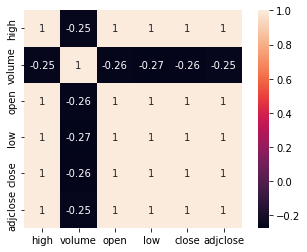




PGR
            high   volume        open         low       close    adjclose  \
0      22.980000  4616800   22.900000   22.660000   22.920000   16.854778   
1      23.000000  5007200   22.900000   22.559999   22.590000   16.612103   
2      22.889999  2300400   22.660000   22.610001   22.820000   16.781246   
3      22.920000  3126300   22.740000   22.690001   22.830000   16.788593   
4      22.879999  2921600   22.809999   22.620001   22.650000   16.656227   
...          ...      ...         ...         ...         ...         ...   
2511  108.809998  3411000  106.430000  103.750000  103.760002  103.760002   
2512  105.610001  2447800  104.430000  102.300003  104.099998  104.099998   
2513  105.209999  1943700  103.839996  103.470001  104.669998  104.669998   
2514  106.750000  1652600  104.510002  104.480003  105.540001  105.540001   
2515  107.870003  1821611  106.870003  105.415001  105.709999  105.709999   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-1

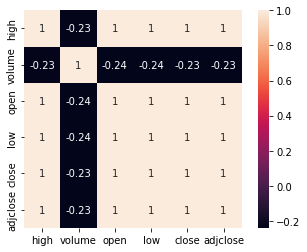




WFC
           high    volume       open        low      close   adjclose  \
0     34.080002  45009500  33.500000  33.110001  34.070000  25.480345   
1     34.130001  39886400  34.130001  33.630001  33.889999  25.345728   
2     34.590000  36658700  33.740002  33.509998  34.250000  25.614965   
3     34.509998  34156500  34.060001  33.740002  34.320000  25.667315   
4     34.520000  29346900  34.500000  34.000000  34.020000  25.442951   
...         ...       ...        ...        ...        ...        ...   
2511  48.200001  60018100  46.680000  46.349998  46.459999  46.459999   
2512  49.750000  34560200  48.790001  48.349998  49.160000  49.160000   
2513  49.570000  26178800  48.259998  47.849998  49.009998  49.009998   
2514  50.000000  23695900  49.669998  48.430000  48.470001  48.470001   
2515  50.377102  27678594  49.660000  49.294998  49.860001  49.860001   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    201

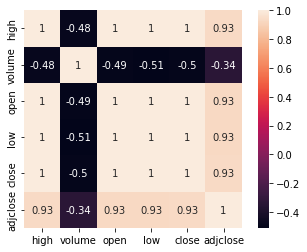




L
           high   volume       open        low      close   adjclose  \
0     39.599998   986900  39.090000  38.759998  39.560001  37.360313   
1     39.709999  1662300  39.650002  39.270000  39.480000  37.284756   
2     39.779999   778800  39.450001  39.400002  39.680000  37.473633   
3     40.160000  1169700  39.450001  39.349998  39.700001  37.492500   
4     39.730000  1146100  39.700001  39.330002  39.340000  37.152542   
...         ...      ...        ...        ...        ...        ...   
2511  61.200001  1118800  60.439999  59.759998  60.060001  60.060001   
2512  62.340000   900200  61.459999  60.990002  61.029999  61.029999   
2513  61.200001   961600  60.360001  60.360001  60.900002  60.900002   
2514  61.869999   648400  61.230000  60.759998  60.880001  60.880001   
2515  62.299999   701479  61.900002  61.200001  61.669998  61.669998   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    2012-03-20 08:30:

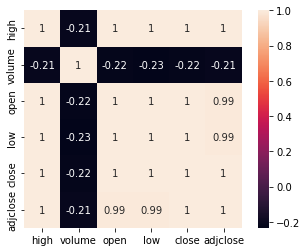




SCHW
           high    volume       open        low      close   adjclose  \
0     15.400000  23167800  14.670000  14.630000  15.300000  13.596262   
1     15.470000  16027300  15.370000  15.120000  15.320000  13.614035   
2     15.530000  15155800  15.500000  15.240000  15.310000  13.605147   
3     15.480000  18438800  15.240000  15.120000  15.380000  13.667352   
4     15.460000  15149100  15.420000  15.260000  15.260000  13.560716   
...         ...       ...        ...        ...        ...        ...   
2511  77.699997   7100700  77.150002  74.629997  75.690002  75.690002   
2512  80.160004   5883900  79.180000  78.160004  79.389999  79.389999   
2513  79.830002   5030900  78.129997  77.709999  79.650002  79.650002   
2514  81.650002   6310700  81.300003  80.160004  80.239998  80.239998   
2515  84.815002   9311157  82.300003  81.830002  83.260002  83.260002   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    20

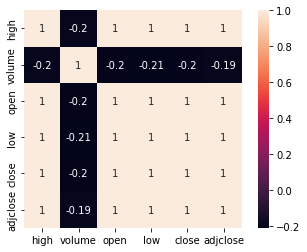




SPGI
            high   volume        open         low       close    adjclose  \
0      47.029999  1527900   46.990002   46.669998   47.020000   39.556820   
1      47.630001  2549900   46.959999   46.790001   47.540001   39.994270   
2      47.400002  2247200   47.110001   47.020000   47.250000   39.750301   
3      47.320000  1712200   47.099998   46.709999   47.279999   39.775555   
4      47.380001  1505600   47.279999   47.080002   47.150002   39.666191   
...          ...      ...         ...         ...         ...         ...   
2511  395.779999  3693900  384.160004  380.480011  388.130005  388.130005   
2512  402.109985  3034100  401.399994  390.980011  391.510010  391.510010   
2513  385.739990  2767300  381.279999  373.839996  382.750000  382.750000   
2514  388.649994  2252100  385.000000  379.279999  379.679993  379.679993   
2515  386.339996  2460290  383.529999  373.179993  377.000000  377.000000   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-

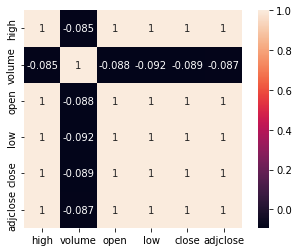




LYB
            high   volume        open         low       close    adjclose  \
0      43.299999  2602800   42.009998   41.930000   42.709999   22.566790   
1      43.250000  2479900   42.720001   42.419998   42.900002   22.667189   
2      42.849998  2645800   42.630001   42.259998   42.540001   22.476965   
3      42.959999  2187800   42.080002   41.619999   42.880001   22.656620   
4      43.810001  1874800   42.980000   42.570000   43.650002   23.063457   
...          ...      ...         ...         ...         ...         ...   
2511   97.830002  2107300   95.440002   93.669998   96.000000   96.000000   
2512  100.610001  2294000   98.000000   97.650002   98.370003   98.370003   
2513   99.970001  1971700   96.779999   96.779999   99.739998   99.739998   
2514  104.180000  2993400  100.330002  100.190002  103.430000  103.430000   
2515  105.839996  3399205  104.760002  102.911003  103.870003  103.870003   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-1

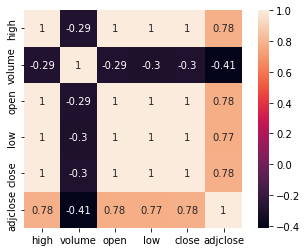




BLL
           high   volume       open        low      close   adjclose  \
0     20.360001  1421400  20.139999  20.115000  20.315001  18.630136   
1     20.695000  5150600  20.309999  20.309999  20.695000  18.978626   
2     20.895000  1738400  20.730000  20.680000  20.695000  18.978626   
3     20.775000  1817800  20.580000  20.535000  20.635000  18.923607   
4     20.725000  1646400  20.680000  20.535000  20.540001  18.836483   
...         ...      ...        ...        ...        ...        ...   
2511  91.220001  2085400  89.470001  87.639999  87.790001  87.790001   
2512  89.650002  3066300  89.349998  85.910004  86.410004  86.410004   
2513  87.209999  1774200  85.550003  84.150002  87.059998  87.059998   
2514  88.620003   973500  87.440002  85.519997  85.559998  85.559998   
2515  89.849998  2084546  87.230003  86.199997  88.440002  88.440002   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    2012-03-20 08:3

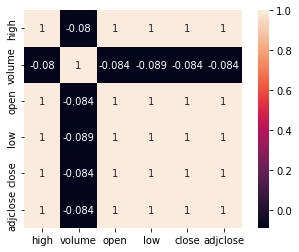




APD
            high   volume        open         low       close    adjclose  \
0      84.828865  1018951   84.403328   83.339500   84.754860   65.099236   
1      85.393150  1226611   84.819611   84.597595   84.838112   65.163208   
2      85.476410   678111   85.328400   84.625343   85.115631   65.376350   
3      84.505089   678652   84.320076   83.626274   84.338577   64.779488   
4      84.773361   655843   84.431084   83.672523   84.107307   64.601883   
...          ...      ...         ...         ...         ...         ...   
2511  225.110001  1867300  221.509995  216.240005  218.770004  218.770004   
2512  229.720001  1433800  225.259995  224.449997  227.000000  227.000000   
2513  227.949997  1538800  223.470001  222.539993  227.600006  227.600006   
2514  230.869995  1488900  229.940002  219.289993  219.380005  219.380005   
2515  222.369995  2212755  220.169998  216.410004  218.270004  218.270004   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-1

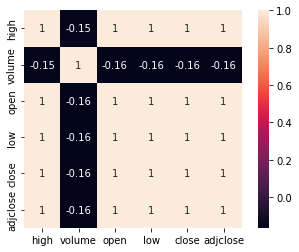




MAA
            high  volume        open         low       close    adjclose  \
0      65.150002  210100   65.019997   64.250000   64.589996   44.676495   
1      64.940002  705700   64.639999   64.389999   64.709999   44.759483   
2      65.769997  315500   64.750000   64.449997   65.760002   45.485767   
3      65.779999  204500   65.339996   65.209999   65.459999   45.278263   
4      65.699997  176900   65.690002   64.800003   64.839996   44.849400   
...          ...     ...         ...         ...         ...         ...   
2511  212.350006  599100  212.190002  207.070007  208.179993  208.179993   
2512  215.460007  678600  211.789993  210.429993  211.699997  211.699997   
2513  211.460007  623800  210.119995  208.740005  211.169998  211.169998   
2514  214.070007  456600  212.119995  207.979996  208.470001  208.470001   
2515  210.809998  450390  210.809998  204.190002  205.419998  205.419998   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  

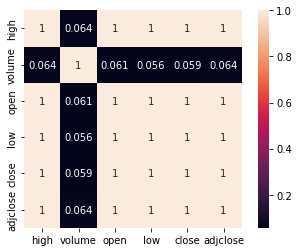




CBRE
           high   volume       open        low      close   adjclose  \
0     20.730000  3528500  20.459999  20.290001  20.680000  20.680000   
1     21.160000  6231000  20.660000  20.540001  20.830000  20.830000   
2     21.000000  2763200  20.870001  20.700001  20.860001  20.860001   
3     20.879999  2621500  20.549999  20.340000  20.770000  20.770000   
4     20.889999  3000300  20.690001  20.600000  20.750000  20.750000   
...         ...      ...        ...        ...        ...        ...   
2511  87.889999  3232300  87.099998  84.620003  84.849998  84.849998   
2512  89.150002  2234000  88.019997  86.989998  87.769997  87.769997   
2513  88.160004  2092800  85.879997  85.510002  87.879997  87.879997   
2514  89.360001  1441900  89.139999  87.459999  87.570000  87.570000   
2515  89.800003  1481826  89.139999  86.540001  87.400002  87.400002   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    2012-03-20 08:

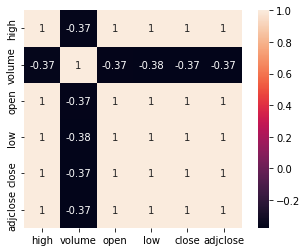




ARE
            high   volume        open         low       close    adjclose  \
0      72.910004   358700   72.910004   72.190002   72.650002   53.341045   
1      73.110001   544700   72.660004   72.440002   72.709999   53.385090   
2      73.910004   268200   72.720001   72.309998   73.540001   53.994495   
3      73.730003   261200   72.790001   72.790001   73.580002   54.023853   
4      73.650002   347800   73.650002   73.040001   73.300003   53.818268   
...          ...      ...         ...         ...         ...         ...   
2511  193.889999  1164000  188.839996  187.710007  190.800003  190.800003   
2512  195.020004   825900  193.399994  191.970001  192.210007  192.210007   
2513  191.619995   861500  190.000000  189.460007  191.380005  191.380005   
2514  192.889999   928000  191.970001  187.520004  188.429993  188.429993   
2515  190.539993   701862  189.750000  187.429993  188.429993  188.429993   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-1

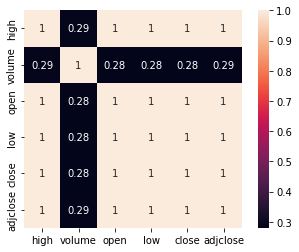




PXD
            high   volume        open         low       close    adjclose  \
0     107.629997  1204600  106.739998  105.269997  106.550003   96.761932   
1     110.570000  2267100  107.209999  107.209999  110.010002   99.904091   
2     111.419998  2385100  109.430000  108.839996  111.309998  101.084671   
3     109.839996  2684800  109.839996  105.570000  106.349998   96.580307   
4     106.099998  2261300  106.099998  103.129997  103.790001   94.255501   
...          ...      ...         ...         ...         ...         ...   
2511  243.479996  5049100  241.059998  223.300003  237.369995  237.369995   
2512  233.970001  4261700  233.820007  223.750000  230.399994  230.399994   
2513  238.580002  3069200  234.300003  229.970001  237.750000  237.750000   
2514  238.160004  2262900  234.559998  232.059998  232.490005  232.490005   
2515  233.059998  2622399  231.330002  221.699997  229.339996  229.339996   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-1

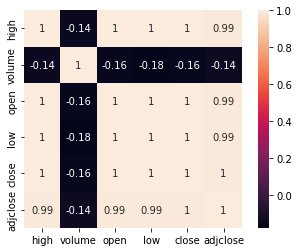




CTRA
           high    volume       open        low      close   adjclose  \
0     16.844999   6261800  16.715000  16.469999  16.520000  14.434767   
1     16.844999   8959600  16.540001  16.285000  16.709999  14.600783   
2     17.090000   5448200  16.655001  16.525000  17.004999  14.858542   
3     16.865000   6072800  16.865000  16.450001  16.580000  14.487191   
4     16.840000   7506600  16.615000  16.514999  16.780001  14.661950   
...         ...       ...        ...        ...        ...        ...   
2511  27.879999  17197300  27.809999  25.650000  26.010000  26.010000   
2512  25.730000  14117100  25.650000  24.680000  25.459999  25.459999   
2513  26.530001  12468800  25.410000  25.010000  26.330000  26.330000   
2514  26.309999  10657500  26.309999  25.350000  25.629999  25.629999   
2515  25.040001  22738659  24.889999  22.705000  23.129999  23.129999   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-16 08:30:00  
2    2012-03-19 08:30:00  
3    20

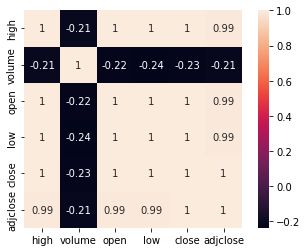




APA
            high    volume        open         low       close   adjclose  \
0     107.820000   2284300  107.279999  105.800003  106.970001  90.230904   
1     109.500000   2922500  107.370003  107.080002  108.980003  91.926346   
2     109.099998   2343100  107.910004  107.370003  108.599998  91.605835   
3     107.379997   2772700  107.169998  105.320000  105.610001  89.083702   
4     106.080002   3778900  105.699997  103.320000  103.480003  87.287041   
...          ...       ...         ...         ...         ...        ...   
2511   41.200001  16485200   39.130001   37.459999   38.630001  38.630001   
2512   38.900002  13634700   36.990002   36.360001   38.700001  38.700001   
2513   40.200001  10804000   39.060001   38.240002   40.040001  40.040001   
2514   40.150002   8393800   39.560001   39.000000   39.049999  39.049999   
2515   38.480000  11742709   38.009998   36.439999   37.580002  37.580002   

                    date  
0    2012-03-15 08:30:00  
1    2012-03-1

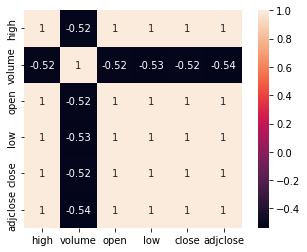

In [155]:
for symbol in constituent_symbols:
    print(symbol)
    print(dfs[symbol])
    print()
    print("--- Shape ---")
    print("Number of records:", dfs[symbol].shape[0])
    print("Number of attributes:", dfs[symbol].shape[1])
    print()
    print("--- Types ---")
    print(dfs[symbol].dtypes)
    print()
    print("--- Missing values in each attribute ---")
    print(dfs[symbol].isnull().sum())
    print()
    print("--- Statistical measures for each attribute ---")
    print(dfs[symbol].describe())
    print()
    print("--- Correlation ---")
    sns.heatmap(dfs[symbol].corr(), square=True, annot=True)
    plt.show()
    print()
    print()
    print()

## Data preprocessing

### Drop null values

In [156]:
for symbol in constituent_symbols:
    dfs[symbol] = dfs[symbol].dropna()

### Split up the date feature

In [157]:
for symbol in constituent_symbols:
    dfs[symbol]['month'] = dfs[symbol]['date'].map(lambda x: x.month)
    dfs[symbol]['year'] = dfs[symbol]['date'].map(lambda x: x.year)
    dfs[symbol]['day'] = dfs[symbol]['date'].map(lambda x: x.day)

## Creation of trading signals and additional features

### Additional features

In [158]:
for symbol in constituent_symbols:
    open_close_mean = list()
    high_low_mean = list()
    for i in range(dfs[symbol].shape[0]):
        open_close_mean.append((dfs[symbol].iloc[i]['open'] + dfs[symbol].iloc[i]['close'])/2)
        high_low_mean.append((dfs[symbol].iloc[i]['high'] + dfs[symbol].iloc[i]['low'])/2)
    dfs[symbol]['open_close_mean'] = open_close_mean
    dfs[symbol]['high_low_mean'] = high_low_mean

### Trading signals

#### Using TA-Lib

In [159]:
for symbol in constituent_symbols:
    up, mid, low = talib.BBANDS(dfs[symbol]['adjclose'], timeperiod = 20, nbdevup = 2, nbdevdn = 2, matype = 0)
    bbp = (dfs[symbol]['adjclose'] - low) / (up - low)
    rsi = talib.RSI(dfs[symbol]['adjclose'], timeperiod = 14)
    dfs[symbol]['BB_up'] = up
    dfs[symbol]['BB_mid'] = mid
    dfs[symbol]['BB_low'] = low
    dfs[symbol]['BBP'] = bbp
    dfs[symbol]['RSI'] = rsi
    dfs[symbol] = dfs[symbol].dropna()

In [161]:
max_holding = 100
holdings = {}
for symbol in constituent_symbols:
    holdings[symbol] = pd.DataFrame(index=dfs[symbol].index, data={'Holdings': np.array([np.nan] * dfs[symbol].index.shape[0])})
    holdings[symbol].loc[((dfs[symbol]['RSI'] < 30) & (dfs[symbol]['BBP'] < 0)), 'Holdings'] = max_holding
    holdings[symbol].loc[((dfs[symbol]['RSI'] > 70) & (dfs[symbol]['BBP'] > 1)), 'Holdings'] = 0
    holdings[symbol].ffill(inplace=True)
    holdings[symbol].fillna(0, inplace=True)
    holdings[symbol]['Order'] = holdings[symbol].diff()
    holdings[symbol].dropna(inplace=True)

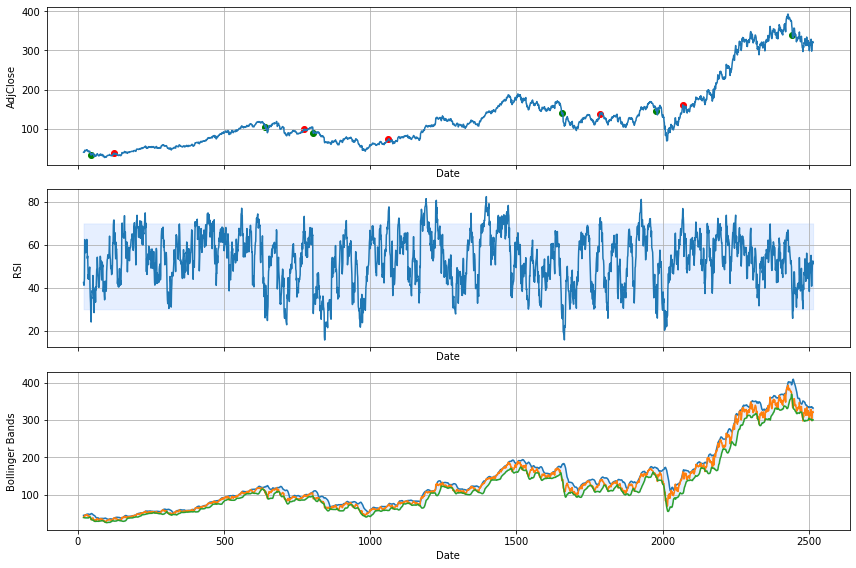

In [166]:
symbol = 'URI'
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
ax0.plot(dfs[symbol].index, dfs[symbol]['adjclose'], label='AdjClose')
ax0.set_xlabel('Date')
ax0.set_ylabel('AdjClose')
ax0.grid()
for day, holding in holdings[symbol].iterrows():
    order = holding['Order']
    if order > 0:
        ax0.scatter(x=day, y=dfs[symbol].loc[day, 'adjclose'], color='green')
    elif order < 0:
        ax0.scatter(x=day, y=dfs[symbol].loc[day, 'adjclose'], color='red')

ax1.plot(dfs[symbol].index, dfs[symbol]['RSI'], label='RSI')
ax1.fill_between(dfs[symbol].index, y1=30, y2=70, color='#adccff', alpha=0.3)
ax1.set_xlabel('Date')
ax1.set_ylabel('RSI')
ax1.grid()

ax2.plot(dfs[symbol].index, dfs[symbol]['BB_up'], label='BB_up')
ax2.plot(dfs[symbol].index, dfs[symbol]['adjclose'], label='AdjClose')
ax2.plot(dfs[symbol].index, dfs[symbol]['BB_low'], label='BB_low')
ax2.fill_between(dfs[symbol].index, y1=dfs[symbol]['BB_low'], y2=dfs[symbol]['BB_up'], color='#adccff', alpha=0.3)
ax2.set_xlabel('Date')
ax2.set_ylabel('Bollinger Bands')
ax2.grid()

fig.tight_layout()
plt.show()

#### Using implemented functions

In [20]:
for symbol in constituent_symbols:
    # SMA
    num_periods_sma = 20
    dfs[symbol]['SMA'] = SMA(num_periods_sma, dfs[symbol]['close'])
    
    # EMA
    num_periods_ema = 20
    dfs[symbol]['EMA'] = EMA(num_periods_ema, dfs[symbol]['close'])

    # APO
    num_periods_fast = 10
    num_periods_slow = 40
    dfs[symbol]['APO'] = APO(num_periods_fast, num_periods_slow, dfs[symbol]['close'])

### History of previous records

In [52]:
num_prev_recs = 5
progress = 0
for symbol in constituent_symbols:
    print(f"Progress: {math.floor((progress*100)/len(constituent_symbols))}%")
    prev_close = [[None for _ in range(num_prev_recs)] for _ in range(num_prev_recs)]
    prev_SMA = [[None for _ in range(num_prev_recs)] for _ in range(num_prev_recs)]
    prev_EMA = [[None for _ in range(num_prev_recs)] for _ in range(num_prev_recs)]
    prev_APO = [[None for _ in range(num_prev_recs)] for _ in range(num_prev_recs)]
    for i in range(num_prev_recs, dfs[symbol].shape[0]):
        for j in range(num_prev_recs):
            prev_close[j].append(dfs[symbol].iloc[i - (j + 1)]['close'])
            prev_SMA[j].append(dfs[symbol].iloc[i - (j + 1)]['SMA'])
            prev_EMA[j].append(dfs[symbol].iloc[i - (j + 1)]['EMA'])
            prev_APO[j].append(dfs[symbol].iloc[i - (j + 1)]['APO'])
    for i in range(num_prev_recs):
        dfs[symbol]["prev_close" + str(i)] = prev_close[i]
        dfs[symbol]["prev_SMA" + str(i)] = prev_SMA[i]
        dfs[symbol]["prev_EMA" + str(i)] = prev_EMA[i]
        dfs[symbol]["prev_APO" + str(i)] = prev_APO[i]
    dfs[symbol] = dfs[symbol].dropna() # Remove records that have null values
    progress += 1

Progress: 0%
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Pro

## Data understanding

URI
            high   volume        open         low       close    adjclose  \
19     40.919998  1921400   39.090000   38.970001   40.650002   40.650002   
20     40.680000  1766800   40.529999   40.080002   40.299999   40.299999   
21     41.150002  1635000   40.619999   39.459999   40.299999   40.299999   
22     41.169998  2217100   40.759998   40.290001   40.910000   40.910000   
23     46.700001  8514100   44.380001   43.060001   45.750000   45.750000   
...          ...      ...         ...         ...         ...         ...   
2511  320.299988   904500  301.940002  301.940002  310.679993  310.679993   
2512  320.989990   704800  318.989990  314.079987  315.790009  315.790009   
2513  322.339996   439200  312.480011  311.190002  321.250000  321.250000   
2514  330.799988   462900  327.489990  322.450012  322.750000  322.750000   
2515  331.045013   792552  324.220001  318.345001  320.260010  320.260010   

                    date  month  year  day  open_close_mean  high_low_m

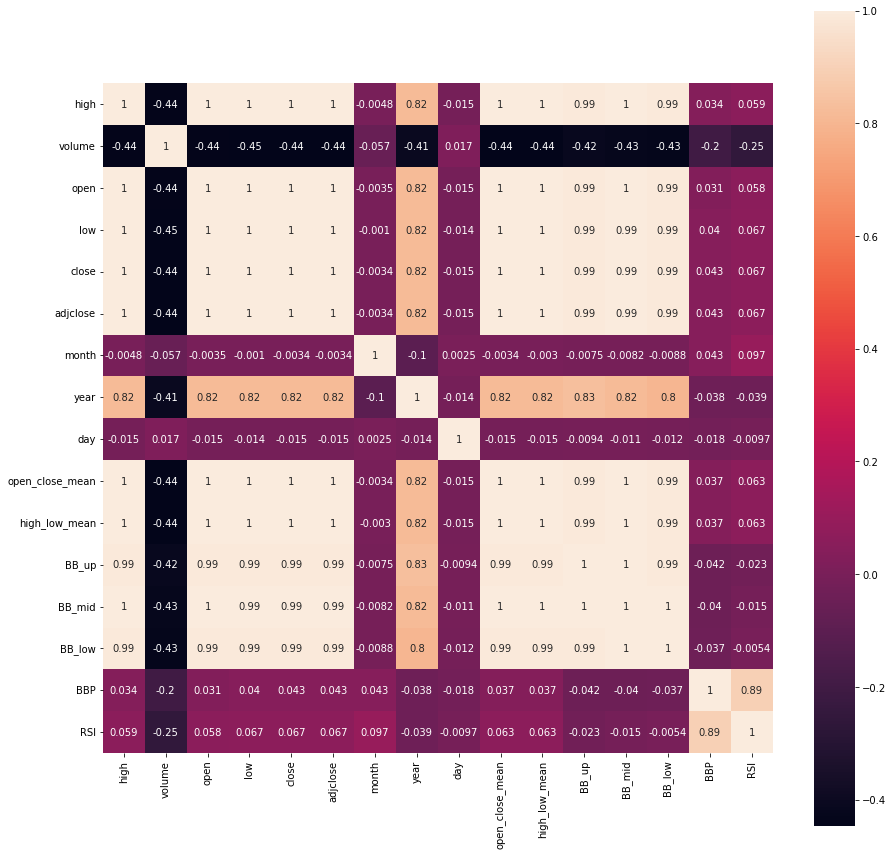




DOV
            high   volume        open         low       close    adjclose  \
19     40.890472  2999691   40.381020   40.381020   40.796627   32.078365   
20     41.433445  4008291   41.353004   40.736298   40.836845   32.109993   
21     41.285973  2533209   41.091576   40.722889   40.890472   32.152161   
22     42.103783  3848072   41.560810   41.158607   41.849052   32.905888   
23     42.298180  3878803   41.963013   40.709484   40.917286   32.173241   
...          ...      ...         ...         ...         ...         ...   
2511  150.309998   889200  147.929993  145.690002  146.190002  146.190002   
2512  153.000000   711500  150.339996  149.820007  151.199997  151.199997   
2513  152.139999   893000  148.880005  148.610001  151.979996  151.979996   
2514  154.330002   773300  153.520004  150.500000  150.630005  150.630005   
2515  154.229996   477710  152.399994  150.990005  151.419998  151.419998   

                    date  month  year  day  open_close_mean  high_lo

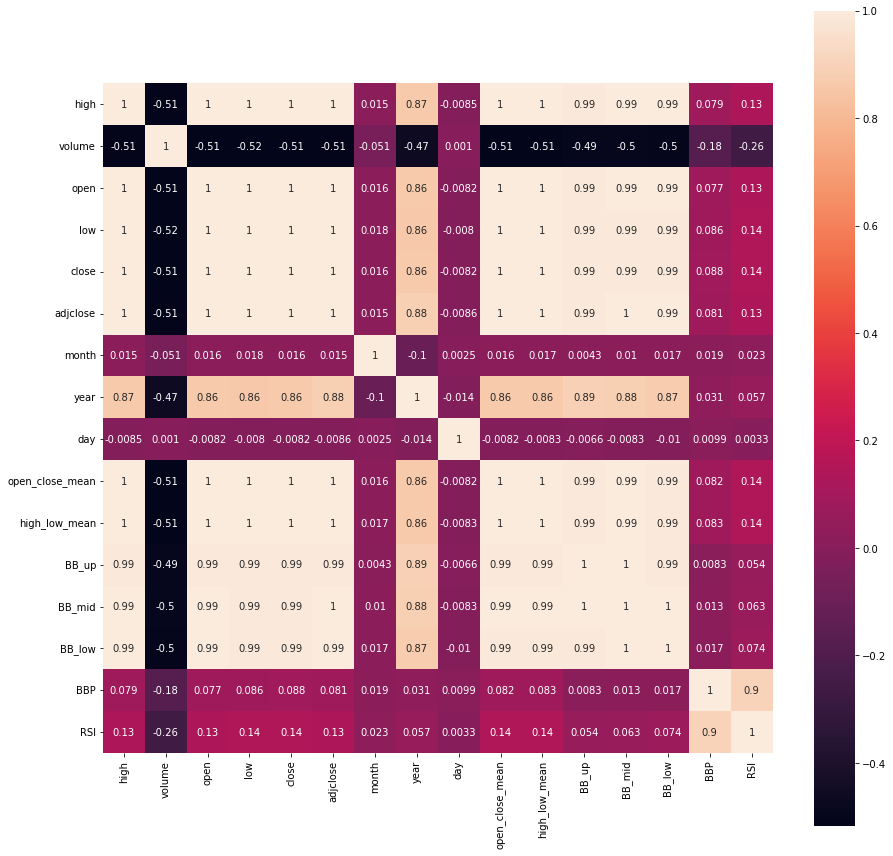




ALLE
            high   volume        open         low       close    adjclose  \
19     43.990002  1953900   43.009998   42.110001   43.689999   40.536640   
20     44.000000  1396700   43.430000   43.160000   43.750000   40.592297   
21     44.500000  1225200   43.650002   43.099998   44.270000   41.074776   
22     44.500000   593000   43.959999   43.820000   44.450001   41.241791   
23     44.450001  2878600   44.299999   43.910000   44.259998   41.065483   
...          ...      ...         ...         ...         ...         ...   
2090  116.169998   652700  113.370003  113.370003  114.540001  114.120514   
2091  114.290001   526400  113.080002  111.809998  112.900002  112.486519   
2092  113.989998   432800  113.769997  111.279999  111.309998  110.902344   
2093  113.629997   629900  112.150002  110.010002  111.949997  111.540001   
2094  113.625000   572676  112.150002  110.010002  111.949997  111.540001   

                    date  month  year  day  open_close_mean  high_l

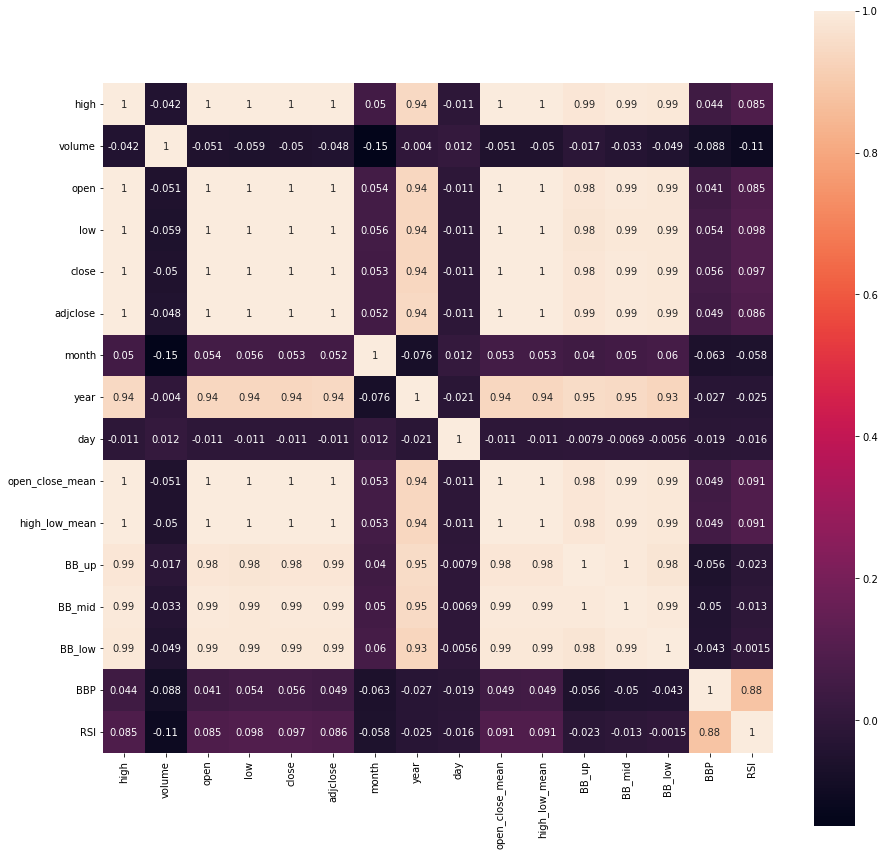




PWR
            high   volume        open         low       close    adjclose  \
19     21.000000  1679700   20.730000   20.639999   20.980000   20.711901   
20     21.020000  1722000   20.900000   20.520000   20.740000   20.474966   
21     21.150000  1799000   20.870001   20.730000   20.889999   20.623047   
22     21.400000  2550400   21.020000   20.920000   21.350000   21.077171   
23     21.389999  1318600   21.180000   21.030001   21.129999   20.859980   
...          ...      ...         ...         ...         ...         ...   
2512  121.150002  2264000  117.820000  116.760002  118.720001  118.720001   
2513  121.480003  1636100  116.989998  116.639999  121.050003  121.050003   
2514  124.949997  1963100  121.500000  121.500000  123.320000  123.320000   
2515  124.660004  1837100  123.180000  121.279999  122.599998  122.599998   
2516  124.660004  1826416  123.180000  121.279999  122.599998  122.599998   

                    date  month  year  day  open_close_mean  high_lo

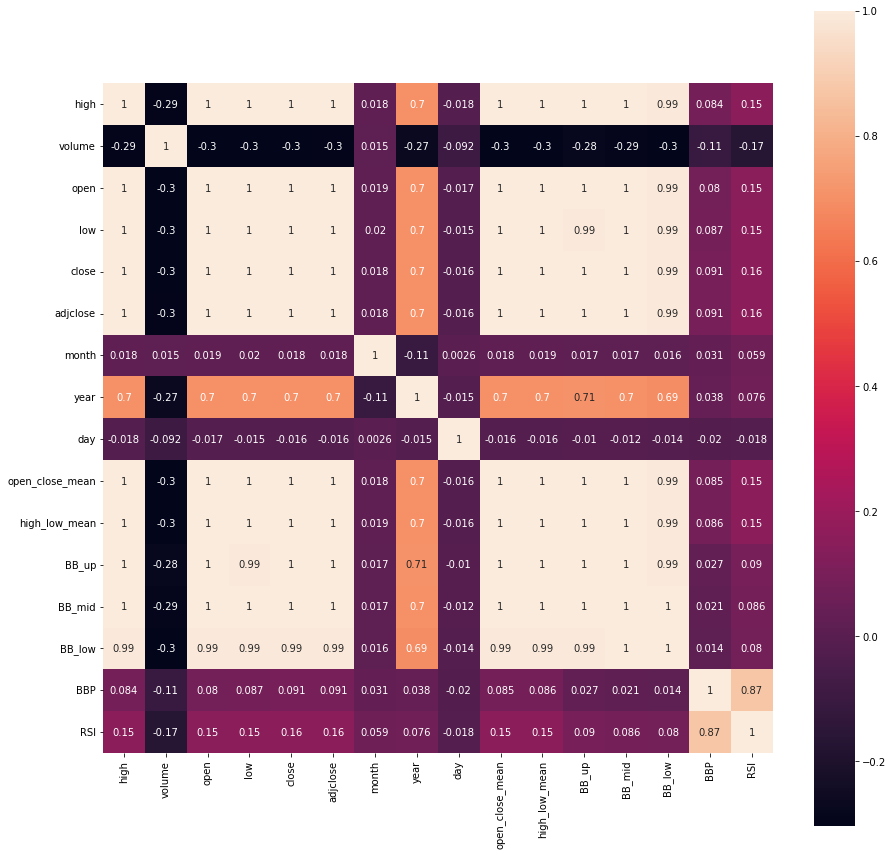




TDG
            high  volume        open         low       close    adjclose  \
19    118.760002  381300  114.230003  114.230003  117.059998   60.472466   
20    117.139999  256600  116.949997  115.690002  116.040001   59.945530   
21    117.730003  340100  116.489998  115.180000  117.029999   60.456963   
22    119.480003  351800  117.599998  117.269997  119.129997   61.541809   
23    121.449997  447800  118.910004  118.809998  120.199997   62.094563   
...          ...     ...         ...         ...         ...         ...   
2512  639.020020  406600  615.270020  611.609985  633.929993  633.929993   
2513  647.469971  315200  620.330017  620.330017  633.679993  633.679993   
2514  646.919983  292600  638.539978  623.270020  623.989990  623.989990   
2515  632.429993  510100  625.330017  613.869995  618.429993  618.429993   
2516  632.429993  505800  625.330017  613.869995  618.429993  618.429993   

                    date  month  year  day  open_close_mean  high_low_mean  \
19

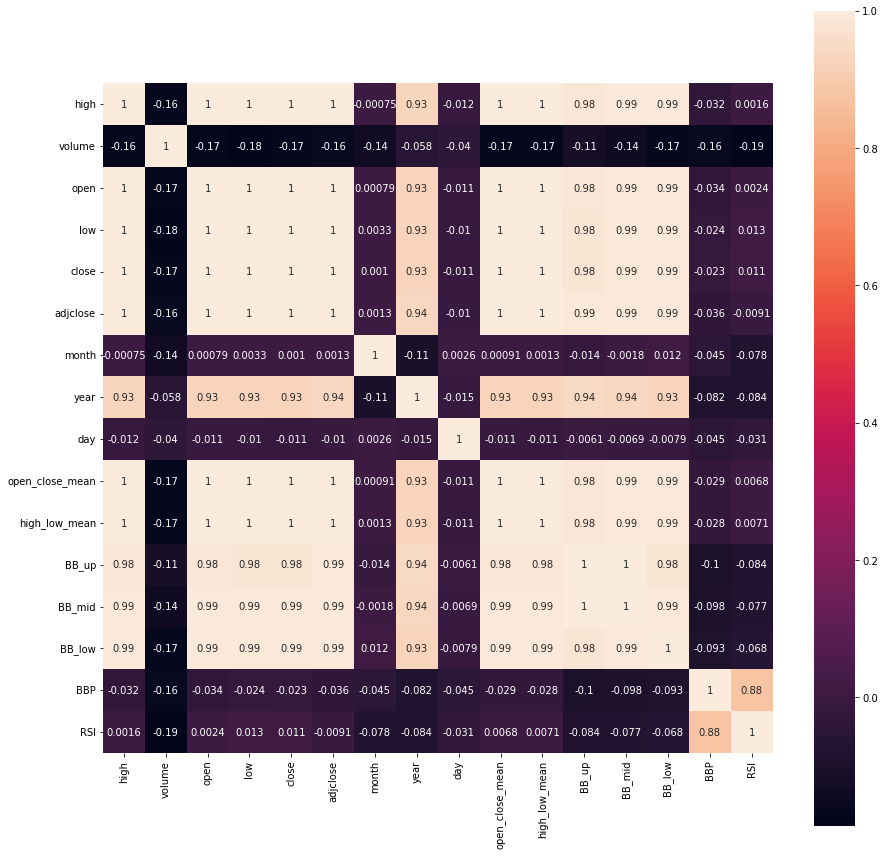




LHX
            high   volume        open         low       close    adjclose  \
19     44.540001   463200   43.820000   43.810001   44.340000   35.468582   
20     44.590000   670100   44.299999   44.189999   44.419998   35.532562   
21     44.889999   782100   44.770000   43.830002   43.849998   35.076614   
22     44.959999   592500   44.130001   44.049999   44.669998   35.732540   
23     44.770000   605900   44.599998   44.320000   44.610001   35.684544   
...          ...      ...         ...         ...         ...         ...   
2511  270.250000  2303200  269.899994  261.140015  261.859985  260.712250   
2512  261.700012  2131900  258.540009  252.190002  255.529999  254.410004   
2513  260.200012  1550000  254.470001  252.210007  254.000000  254.000000   
2514  257.000000  2112900  254.990005  249.800003  250.000000  250.000000   
2515  253.440002  1884777  251.759995  246.339996  250.110001  250.110001   

                    date  month  year  day  open_close_mean  high_lo

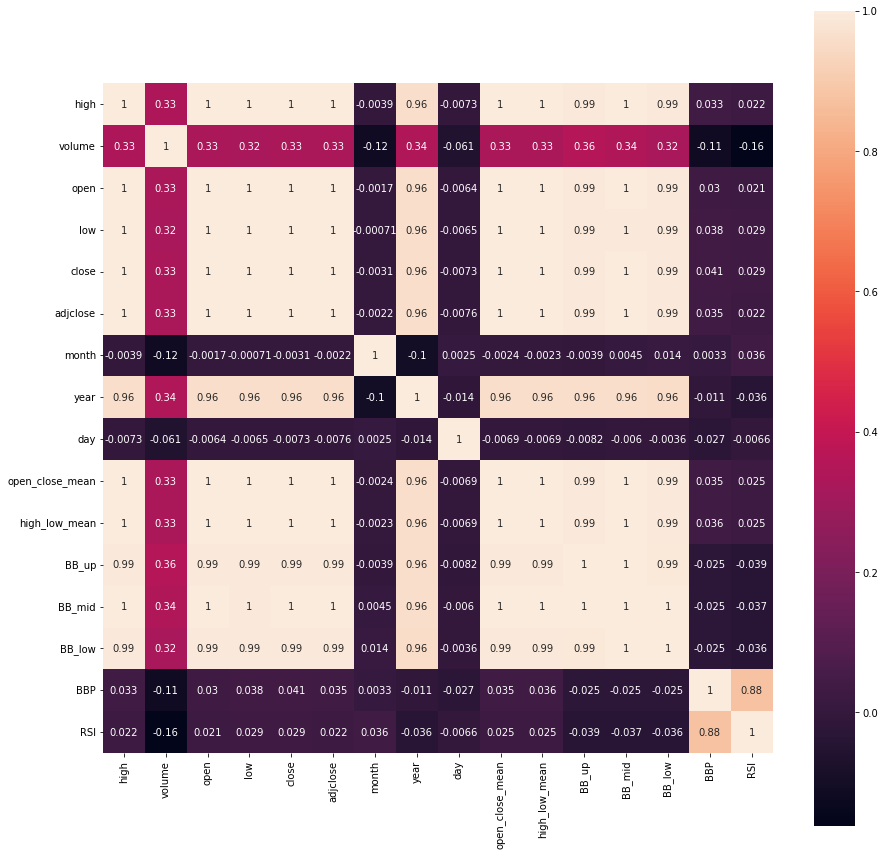




DAL
           high    volume       open        low      close   adjclose  \
19    10.490000  10834900   9.980000   9.980000  10.260000   9.114056   
20    10.260000   7007000  10.210000  10.080000  10.130000   8.998576   
21    10.460000  15157900  10.150000  10.080000  10.250000   9.105176   
22    10.480000  12285200  10.350000  10.190000  10.440000   9.273951   
23    10.610000  10180200  10.420000  10.390000  10.530000   9.353896   
...         ...       ...        ...        ...        ...        ...   
2512  33.779999  25808000  32.930000  32.560001  32.759998  32.759998   
2513  33.410000  17588900  32.119999  31.520000  32.549999  32.549999   
2514  33.400002  16963000  33.310001  32.009998  32.070000  32.070000   
2515  33.200001  17235500  32.000000  31.650000  32.070000  32.070000   
2516  33.200001  17162485  32.000000  31.650000  32.070000  32.070000   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012 

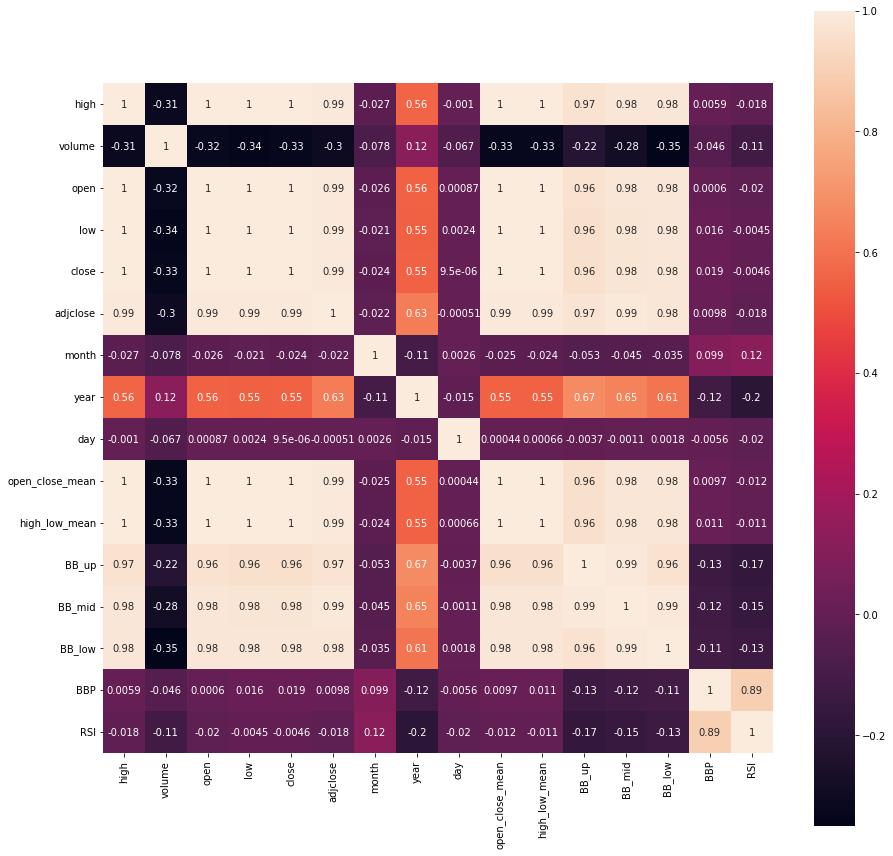




ROK
            high   volume        open         low       close    adjclose  \
19     80.250000  1791300   77.389999   77.019997   80.180000   64.917519   
20     79.589996  1775700   79.510002   77.489998   77.500000   62.747692   
21     78.800003   829500   78.139999   77.410004   78.029999   63.176819   
22     80.169998  1331600   78.769997   78.680000   79.809998   64.617958   
23     79.430000   949800   79.290001   78.550003   78.589996   63.630211   
...          ...      ...         ...         ...         ...         ...   
2512  281.649994  1036700  279.820007  270.450012  271.040009  271.040009   
2513  266.929993   911800  265.529999  259.010010  262.549988  262.549988   
2514  266.119995   700900  264.760010  256.670013  257.010010  257.010010   
2515  261.820007   741000  260.000000  252.850006  256.350006  256.350006   
2516  261.820007   734067  260.000000  252.850006  256.350006  256.350006   

                    date  month  year  day  open_close_mean  high_lo

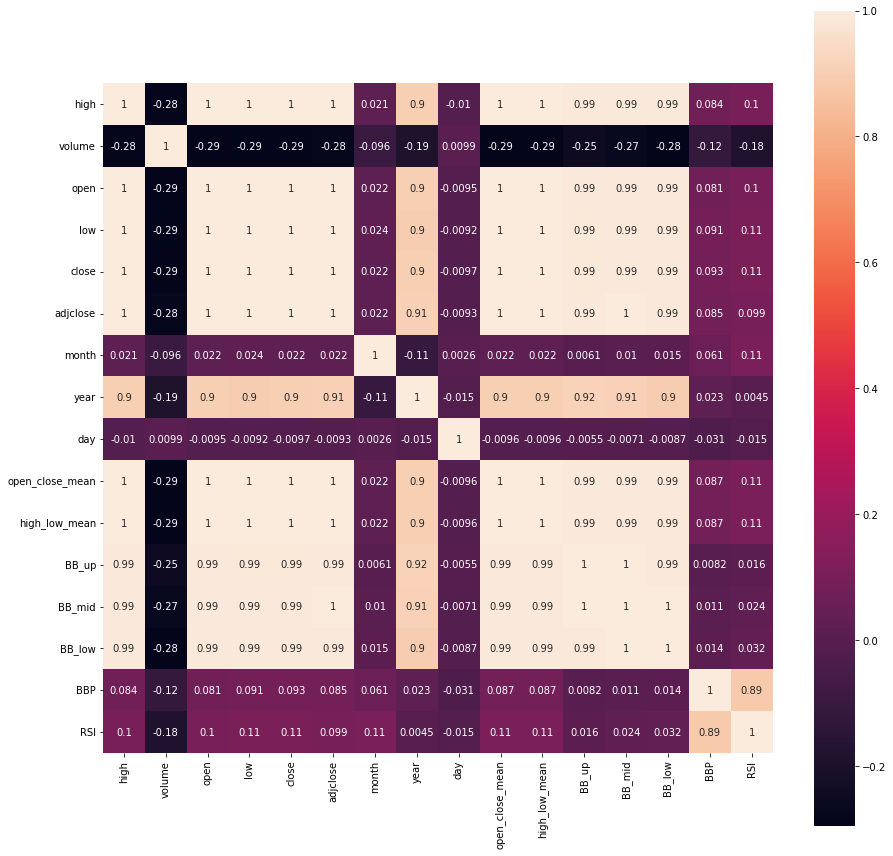




CTLT
            high   volume       open        low      close   adjclose  \
19     21.350000   265100  21.200001  21.150000  21.270000  21.270000   
20     21.700001  3070200  21.100000  21.023001  21.500000  21.500000   
21     21.740000  1271800  21.500000  21.330000  21.500000  21.500000   
22     21.790001   665700  21.350000  21.325001  21.700001  21.700001   
23     21.799999   329700  21.639999  21.523001  21.680000  21.680000   
...          ...      ...        ...        ...        ...        ...   
1915   99.129997   814700  96.050003  95.709999  98.690002  98.690002   
1916   98.519997   743800  96.919998  96.010002  98.330002  98.330002   
1917   99.089996  1004100  99.080002  96.040001  96.120003  96.120003   
1918  100.000000   876700  97.010002  95.379997  95.650002  95.650002   
1919  100.000000   858615  97.010002  95.379997  95.650002  95.650002   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2014-08-27 08:30:00      8  2014

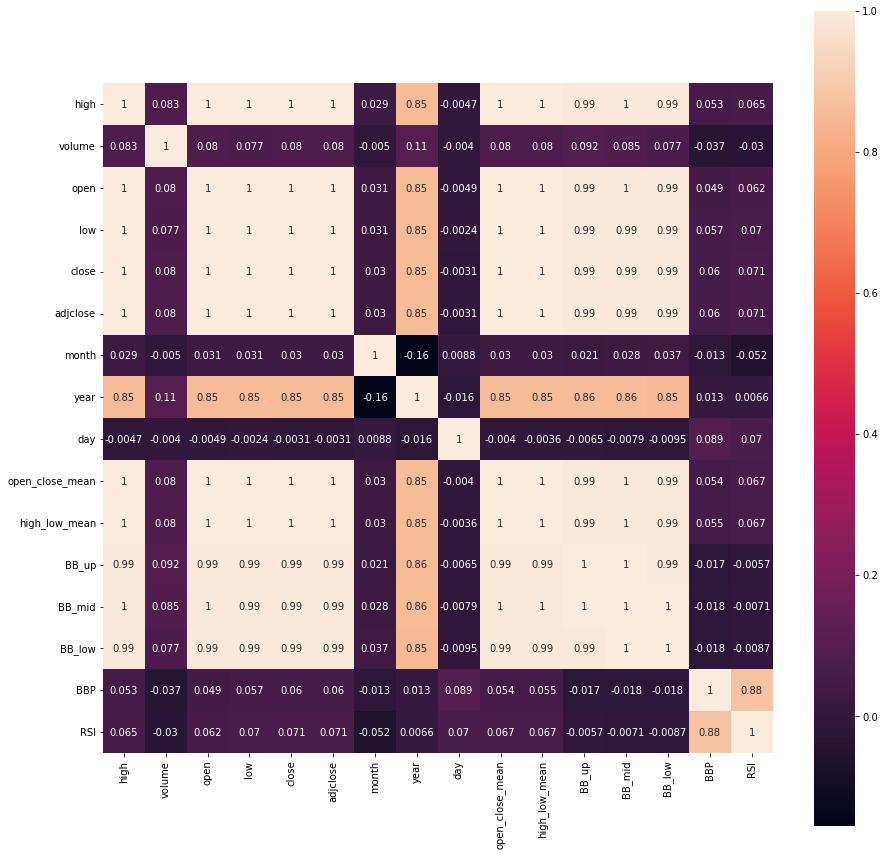




A
            high   volume        open         low       close    adjclose  \
19     31.244635  2185074   30.486408   30.400572   31.137339   28.201406   
20     30.979971  3344156   30.908442   30.178827   30.214592   27.365671   
21     30.565092  3447188   30.464951   29.899857   30.035765   27.203697   
22     30.586552  2901130   30.329041   30.278971   30.507868   27.631289   
23     30.464951  2405399   30.250359   30.050072   30.271816   27.417496   
...          ...      ...         ...         ...         ...         ...   
2511  132.500000  2375500  128.639999  127.540001  129.320007  129.320007   
2512  133.940002  1805500  132.850006  131.190002  133.259995  133.259995   
2513  134.520004  1933100  131.399994  131.289993  134.330002  134.330002   
2514  136.440002  1815700  135.429993  130.160004  130.309998  130.309998   
2515  132.259995  1695508  131.000000  126.900002  127.580002  127.580002   

                    date  month  year  day  open_close_mean  high_low_

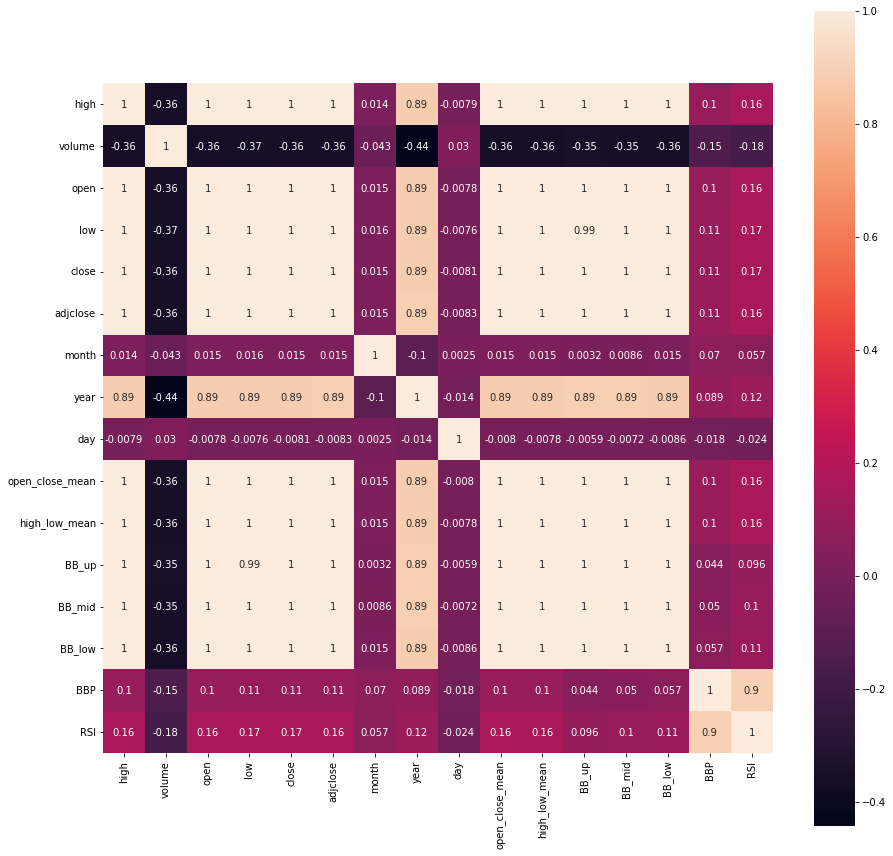




REGN
            high   volume        open         low       close    adjclose  \
19    124.000000   760900  123.209999  121.489998  123.000000  123.000000   
20    123.959999   497300  122.790001  121.500000  122.599998  122.599998   
21    124.500000   579300  123.360001  119.510002  122.540001  122.540001   
22    125.000000   627000  123.250000  122.940002  123.449997  123.449997   
23    124.769997   497600  123.209999  122.430000  124.089996  124.089996   
...          ...      ...         ...         ...         ...         ...   
2511  627.340027   592200  611.169983  609.030029  614.739990  614.739990   
2512  626.679993   538900  622.200012  614.210022  623.429993  623.429993   
2513  632.679993   480600  616.130005  615.919983  630.359985  630.359985   
2514  652.270020   802900  633.799988  630.669983  642.580017  642.580017   
2515  665.979980  1016288  644.599976  644.599976  656.409973  656.409973   

                    date  month  year  day  open_close_mean  high_l

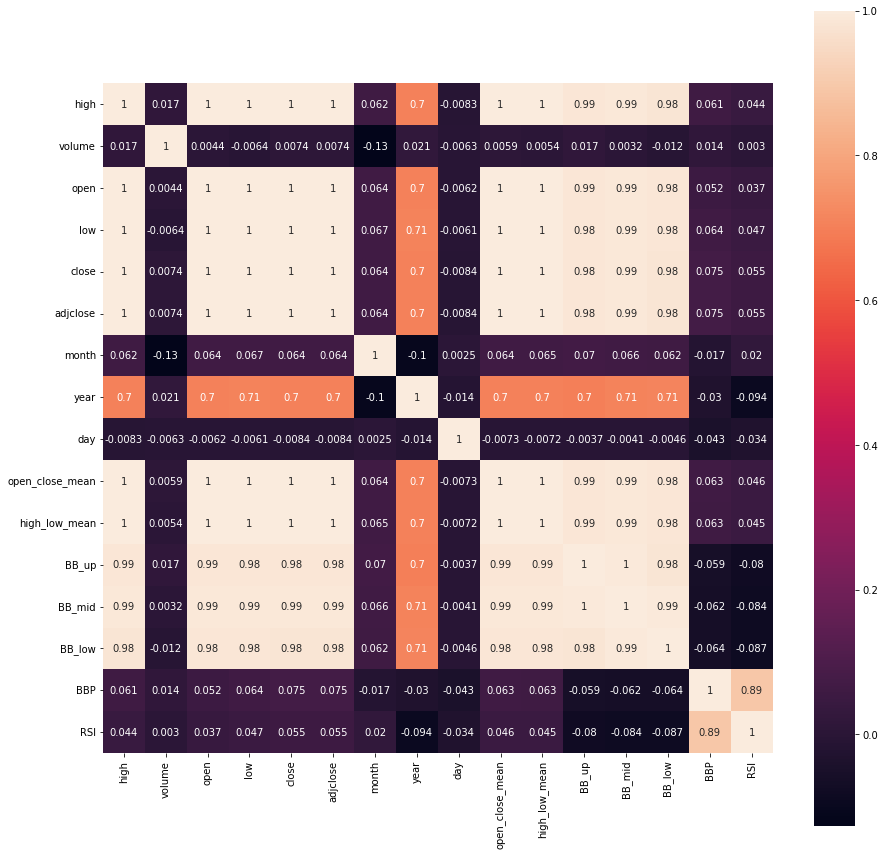




ZTS
            high   volume        open         low       close    adjclose  \
19     34.700001  2334000   33.360001   33.150002   34.599998   32.489666   
20     34.889999   865400   34.799999   34.240002   34.349998   32.254925   
21     34.480000  1413400   34.410000   33.750000   34.290001   32.198582   
22     34.380001   802000   34.340000   33.849998   33.849998   31.785419   
23     34.680000  1320000   33.950001   33.560001   34.560001   32.452114   
...          ...      ...         ...         ...         ...         ...   
2291  190.699997  2630400  185.550003  183.800003  189.580002  189.580002   
2292  189.600006  1995100  187.389999  186.139999  189.220001  189.220001   
2293  190.279999  1589700  189.949997  185.169998  185.289993  185.289993   
2294  187.259995  2044800  186.419998  183.889999  184.660004  184.660004   
2295  187.259995  2005924  186.419998  183.884995  184.660004  184.660004   

                    date  month  year  day  open_close_mean  high_lo

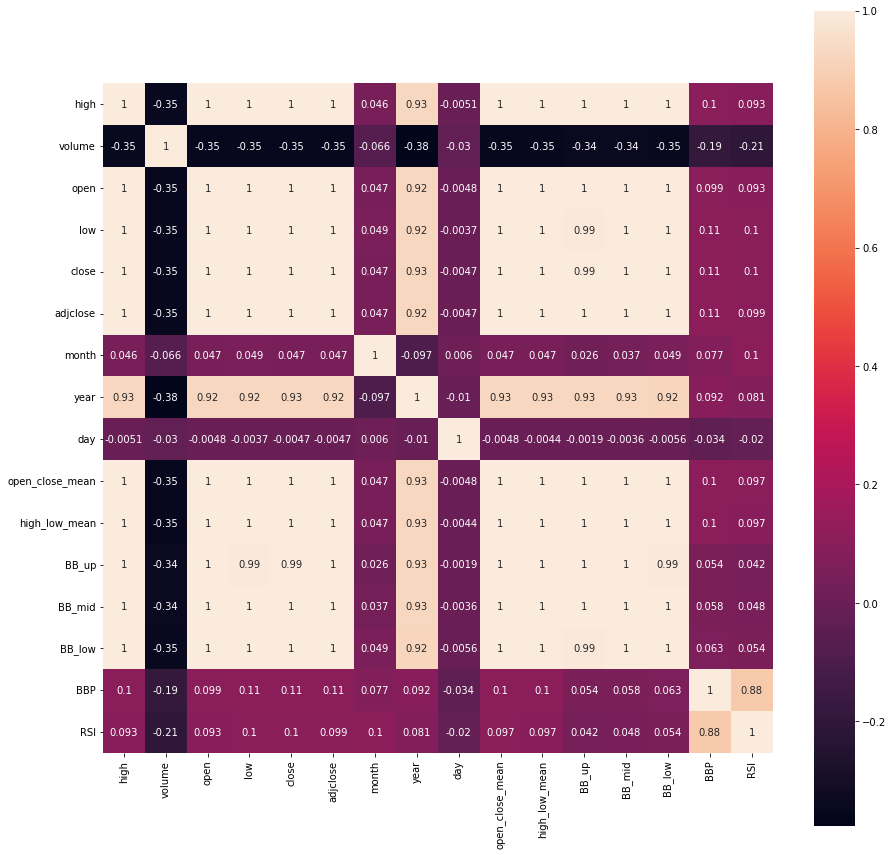




JNJ
            high    volume        open         low       close    adjclose  \
19     64.150002  13122300   64.050003   63.680000   64.150002   48.473534   
20     64.000000  11226600   63.939999   63.520000   63.540001   48.012596   
21     64.160004  10502400   63.720001   63.669998   63.980000   48.345078   
22     64.279999  18322900   64.230003   63.270000   64.220001   48.526417   
23     63.919998  20567700   63.900002   63.119999   63.259998   47.801022   
...          ...       ...         ...         ...         ...         ...   
2512  170.229996   7248200  170.009995  167.889999  169.360001  169.360001   
2513  170.149994   6171400  168.559998  168.080002  169.660004  169.660004   
2514  171.460007   5188000  169.130005  169.020004  169.350006  169.350006   
2515  174.119995   7729100  170.679993  170.350006  171.690002  171.690002   
2516  174.119995   7535395  170.679993  170.350006  171.690002  171.690002   

                    date  month  year  day  open_close_m

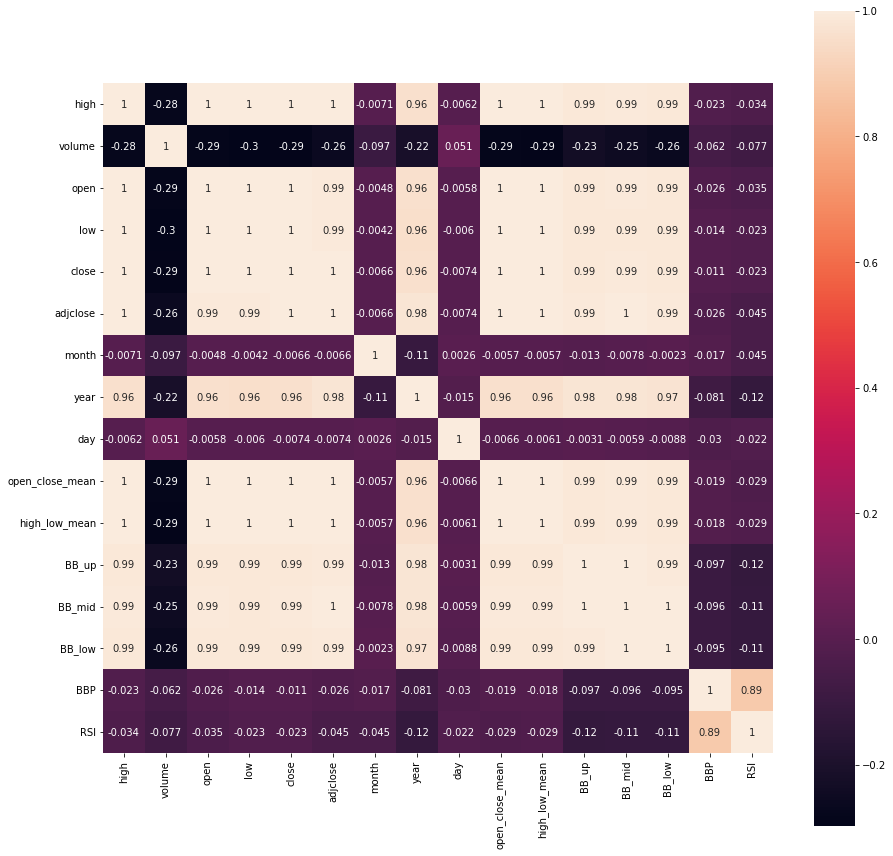




CAH
           high   volume       open        low      close   adjclose  \
19    42.380001  4570400  42.189999  41.230000  41.299999  30.883383   
20    41.340000  3105900  41.090000  40.490002  40.529999  30.307602   
21    40.919998  2775200  40.660000  40.439999  40.580002  30.344992   
22    41.820000  3058800  40.709999  40.709999  41.700001  31.182508   
23    41.480000  2107000  41.459999  41.099998  41.169998  30.786186   
...         ...      ...        ...        ...        ...        ...   
2511  53.299999  2437800  52.520000  52.049999  52.430000  52.430000   
2512  53.840000  1576800  53.490002  53.090000  53.189999  53.189999   
2513  53.320000  1595700  52.779999  52.509998  53.169998  53.169998   
2514  53.410000  1649100  52.950001  52.529999  52.570000  52.570000   
2515  53.290001  2266834  53.150002  51.990002  52.610001  52.610001   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012   12        

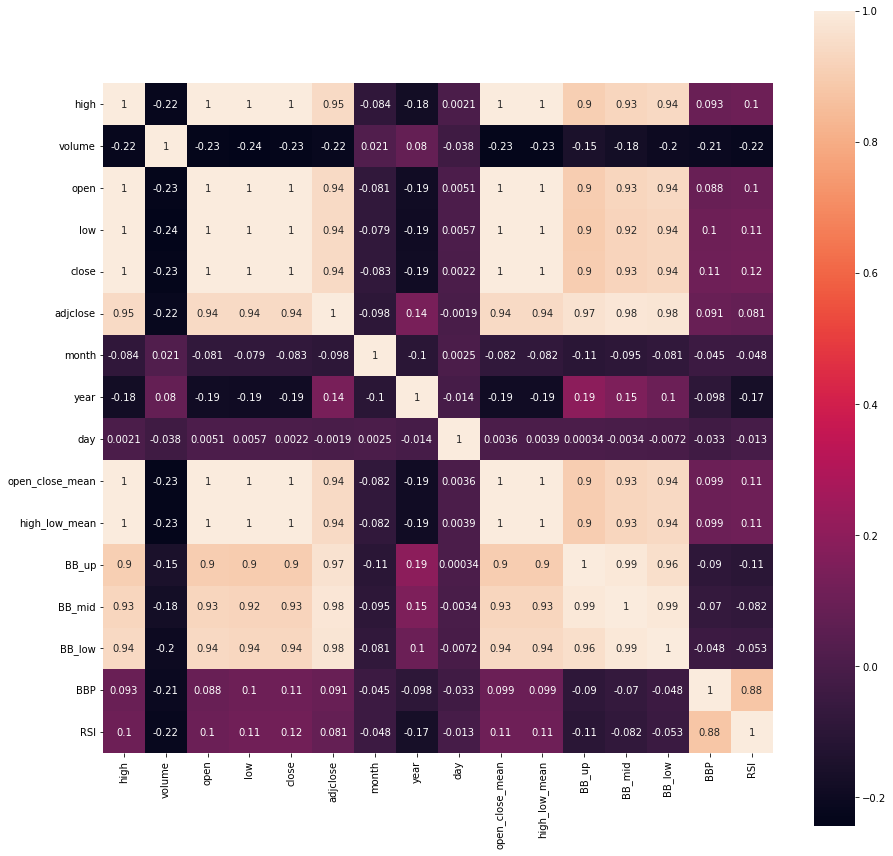




TFX
            high  volume        open         low       close    adjclose  \
19     61.700001  254900   60.509998   60.509998   61.299999   56.065441   
20     61.700001  144000   61.250000   60.299999   60.320000   55.169121   
21     60.820000  181900   60.570000   59.939999   60.509998   55.342903   
22     62.009998  206500   60.830002   60.830002   61.419998   56.175190   
23     62.490002  367800   61.209999   61.200001   62.119999   56.815414   
...          ...     ...         ...         ...         ...         ...   
2511  346.230011  646800  345.299988  336.869995  336.959991  336.959991   
2512  348.369995  447100  341.820007  341.820007  343.100006  343.100006   
2513  340.549988  298400  336.989990  334.549988  339.350006  339.350006   
2514  344.480011  271900  342.440002  335.850006  335.989990  335.989990   
2515  340.174988  226660  336.459991  332.338989  334.609985  334.609985   

                    date  month  year  day  open_close_mean  high_low_mean  \
19

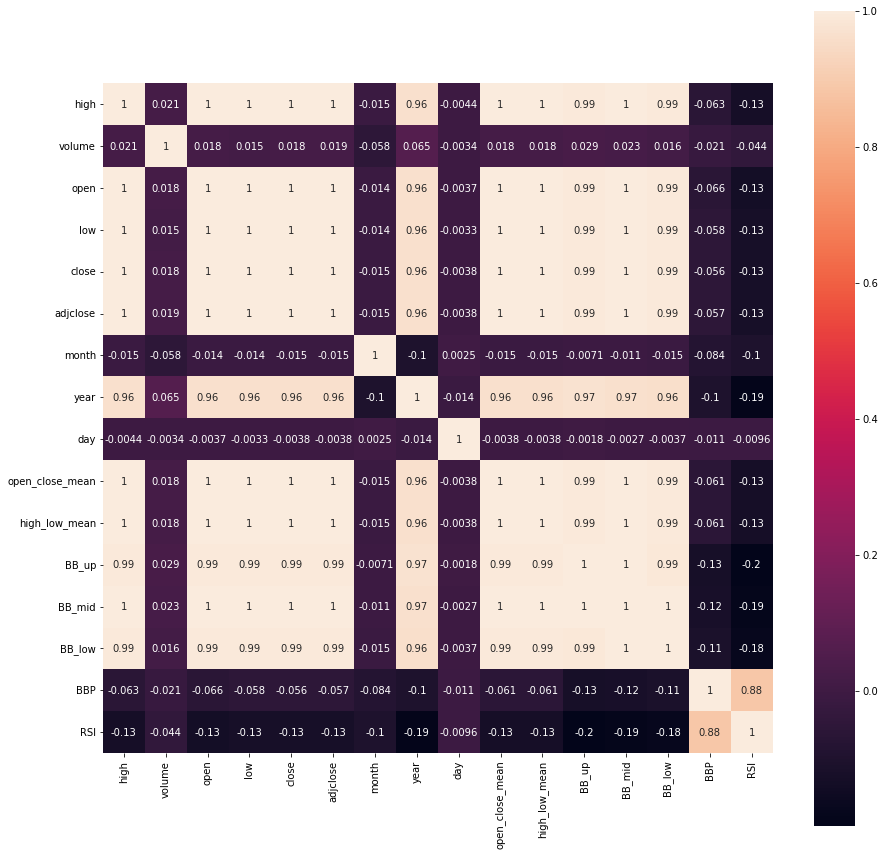




TRMB
           high   volume       open        low      close   adjclose  \
19    26.950001   670600  26.514999  26.400000  26.760000  26.760000   
20    26.809999   739800  26.695000  26.250000  26.375000  26.375000   
21    26.855000   834200  26.610001  26.370001  26.584999  26.584999   
22    27.920000  1738200  26.895000  26.895000  27.700001  27.700001   
23    27.684999   888200  27.629999  27.320000  27.555000  27.555000   
...         ...      ...        ...        ...        ...        ...   
2511  66.160004  1562000  63.410000  62.880001  64.430000  64.430000   
2512  67.959999  1439700  66.209999  65.629997  67.709999  67.709999   
2513  67.160004   913700  66.040001  65.360001  66.610001  66.610001   
2514  67.739998   926600  67.570000  65.410004  65.470001  65.470001   
2515  65.959999  1306936  65.820000  63.700001  64.230003  64.230003   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012   12       

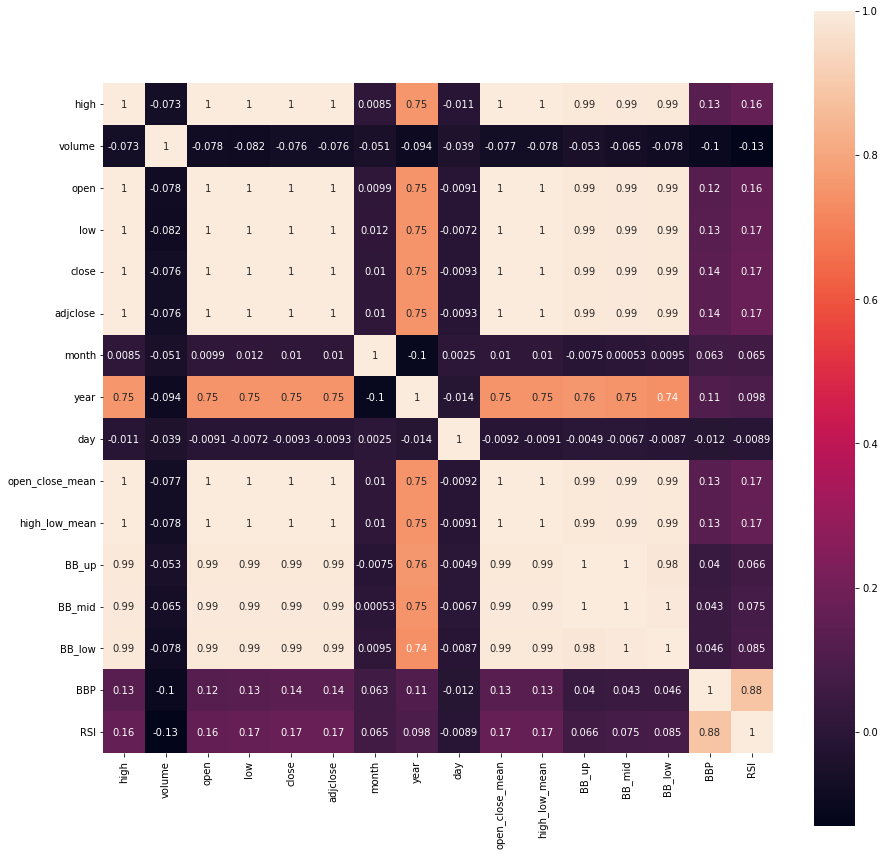




CDAY
          high   volume       open        low      close   adjclose  \
19   34.500000   405300  34.139999  33.759998  33.970001  33.970001   
20   34.310001   397100  34.110001  33.527000  33.709999  33.709999   
21   33.869999   256900  33.570000  33.220001  33.599998  33.599998   
22   34.340000   218100  33.400002  33.000000  34.240002  34.240002   
23   34.750000   546100  34.230000  33.790001  34.669998  34.669998   
..         ...      ...        ...        ...        ...        ...   
974  67.370003  1675700  62.930000  62.480000  66.040001  66.040001   
975  64.720001  1387100  64.680000  62.330002  64.040001  64.040001   
976  65.250000   943700  65.089996  61.299999  61.380001  61.380001   
977  62.820999  1963400  61.590000  58.820000  59.419998  59.419998   
978  62.820999  1448488  65.089996  58.820000  59.419998  59.419998   

                   date  month  year  day  open_close_mean  high_low_mean  \
19  2018-05-23 08:30:00      5  2018   23        34.055000    

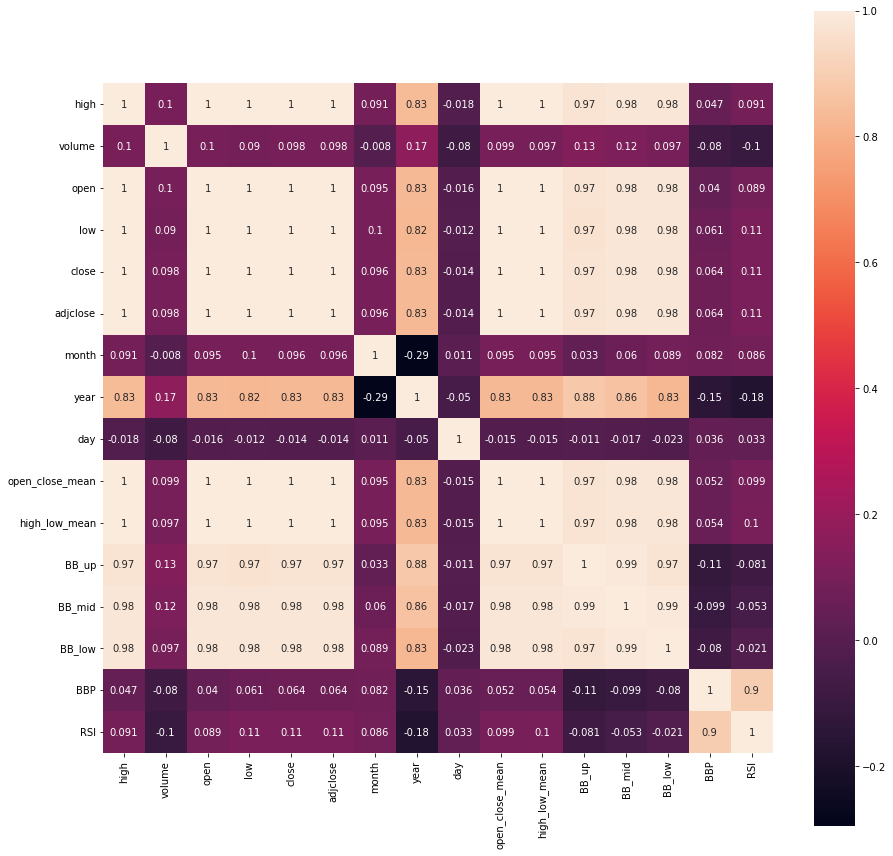




AKAM
            high   volume        open         low       close    adjclose  \
19     36.660000  1681700   36.020000   35.980000   36.540001   36.540001   
20     36.790001  2237700   36.360001   36.099998   36.759998   36.759998   
21     37.000000  2086100   36.950001   36.299999   36.730000   36.730000   
22     37.820000  2278900   37.189999   37.080002   37.630001   37.630001   
23     38.639999  3790600   37.660000   37.660000   38.410000   38.410000   
...          ...      ...         ...         ...         ...         ...   
2511  112.449997  2401600  111.269997  106.940002  107.070000  107.070000   
2512  109.910004  1729400  108.050003  106.269997  109.180000  109.180000   
2513  109.930000  1386000  108.260002  106.839996  109.529999  109.529999   
2514  110.300003  1242400  109.690002  108.250000  108.440002  108.440002   
2515  110.059998  1478953  107.959999  107.510002  108.080002  108.080002   

                    date  month  year  day  open_close_mean  high_l

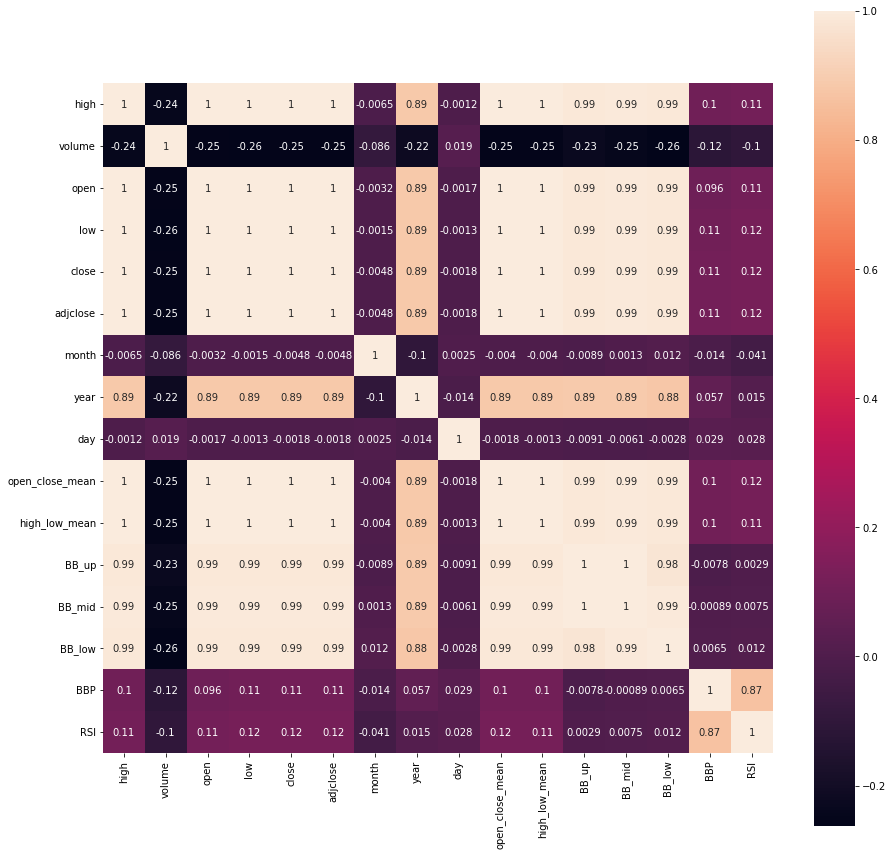




NXPI
            high   volume        open         low       close    adjclose  \
19     24.860001  1822700   23.940001   23.900000   24.799999   23.673969   
20     24.709999   807500   24.500000   23.950001   24.150000   23.053484   
21     24.910000  1104500   24.459999   23.799999   24.740000   23.616695   
22     25.480000  1719500   25.000000   24.940001   24.959999   23.826706   
23     25.230000  1127200   24.670000   24.360001   25.020000   23.883986   
...          ...      ...         ...         ...         ...         ...   
2511  185.440002  4006600  170.619995  168.740005  176.899994  176.062851   
2512  186.270004  3108900  183.000000  182.199997  183.350006  182.482330   
2513  181.320007  1899200  179.240005  175.820007  180.500000  179.645813   
2514  185.270004  2176500  183.979996  178.160004  178.559998  177.714996   
2515  179.639999  2515948  178.380005  170.220001  171.710007  171.710007   

                    date  month  year  day  open_close_mean  high_l

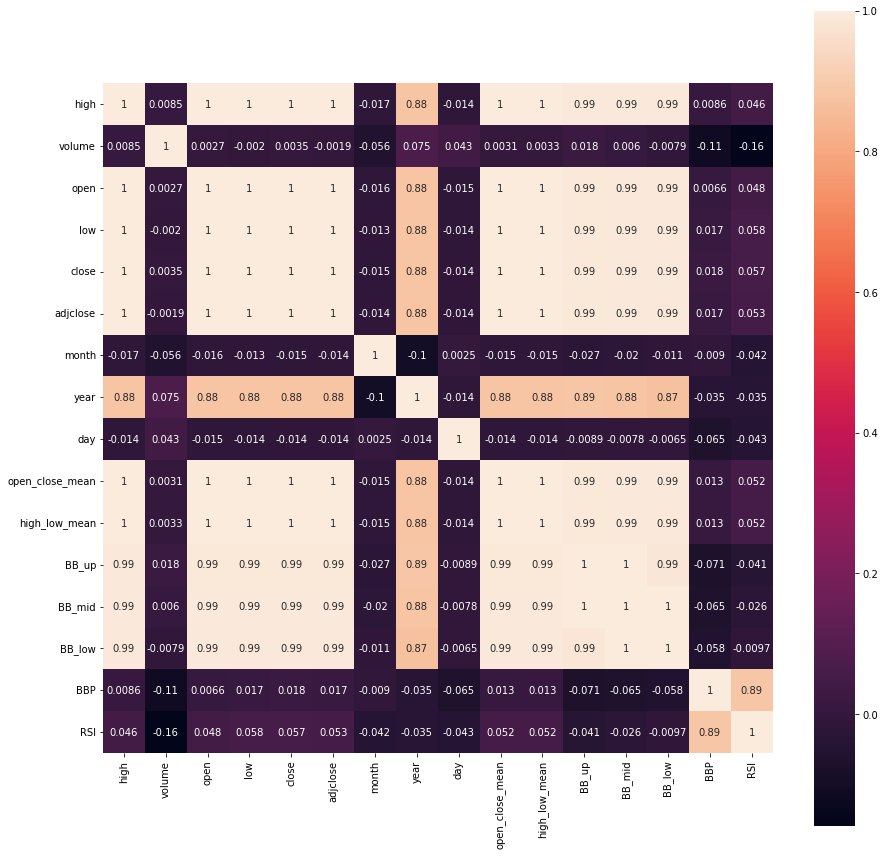




SNPS
            high   volume        open         low       close    adjclose  \
19     30.260000   347500   29.910000   29.870001   30.190001   30.190001   
20     30.270000   460900   30.080000   29.799999   29.850000   29.850000   
21     30.049999   630000   29.990000   29.370001   29.900000   29.900000   
22     30.190001   734800   29.990000   29.959999   30.040001   30.040001   
23     29.980000   598500   29.900000   29.690001   29.690001   29.690001   
...          ...      ...         ...         ...         ...         ...   
2511  305.790009   911100  292.220001  289.339996  296.350006  296.350006   
2512  309.709991   809800  303.720001  302.200012  307.790009  307.790009   
2513  303.839996   941800  300.440002  291.519989  300.839996  300.839996   
2514  305.920013   953200  305.000000  293.149994  293.690002  293.690002   
2515  295.920013  1169009  292.070007  277.190002  278.980011  278.980011   

                    date  month  year  day  open_close_mean  high_l

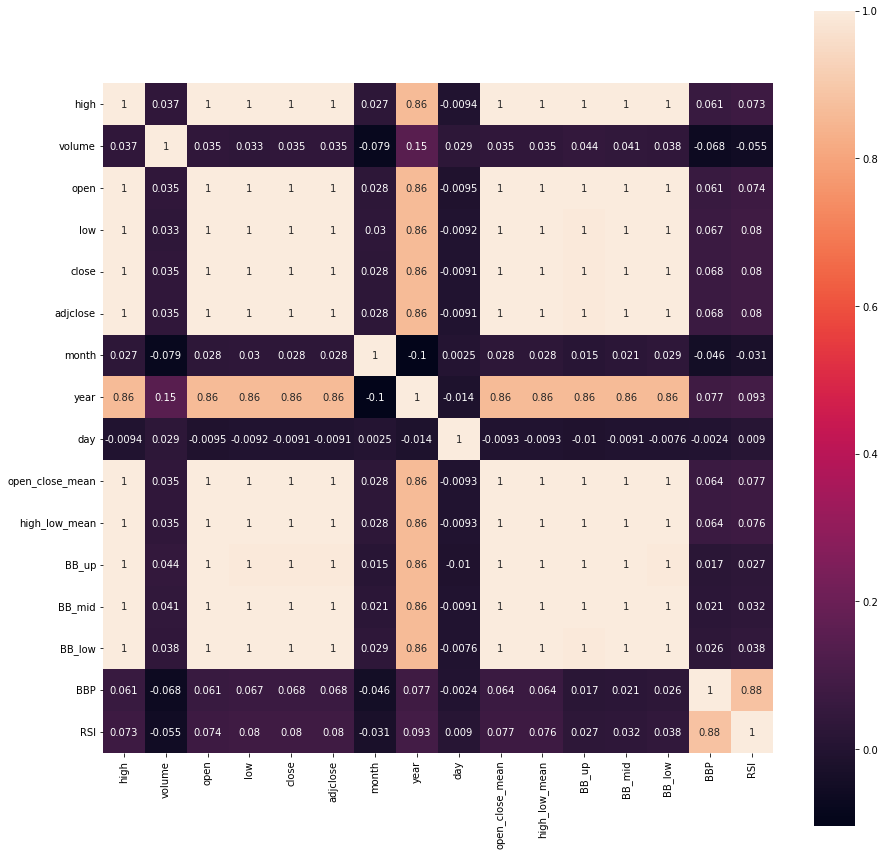




JNPR
           high   volume       open        low      close   adjclose  \
19    22.240000  8066900  21.740000  21.690001  22.020000  18.374971   
20    21.920000  7966600  21.870001  21.150000  21.200001  17.690708   
21    21.459999  9233100  21.309999  20.750000  20.840000  17.390297   
22    21.700001  6991600  20.910000  20.910000  21.620001  18.041185   
23    21.450001  5187800  21.450001  21.040001  21.160000  17.657328   
...         ...      ...        ...        ...        ...        ...   
2511  33.610001  4374600  33.259998  32.549999  32.880001  32.880001   
2512  33.939999  2463000  33.610001  33.320000  33.689999  33.689999   
2513  33.900002  3792500  33.500000  33.139999  33.250000  33.250000   
2514  34.240002  2399700  33.560001  33.110001  33.139999  33.139999   
2515  33.740002  3933726  33.400002  32.945000  33.290001  33.290001   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012   12       

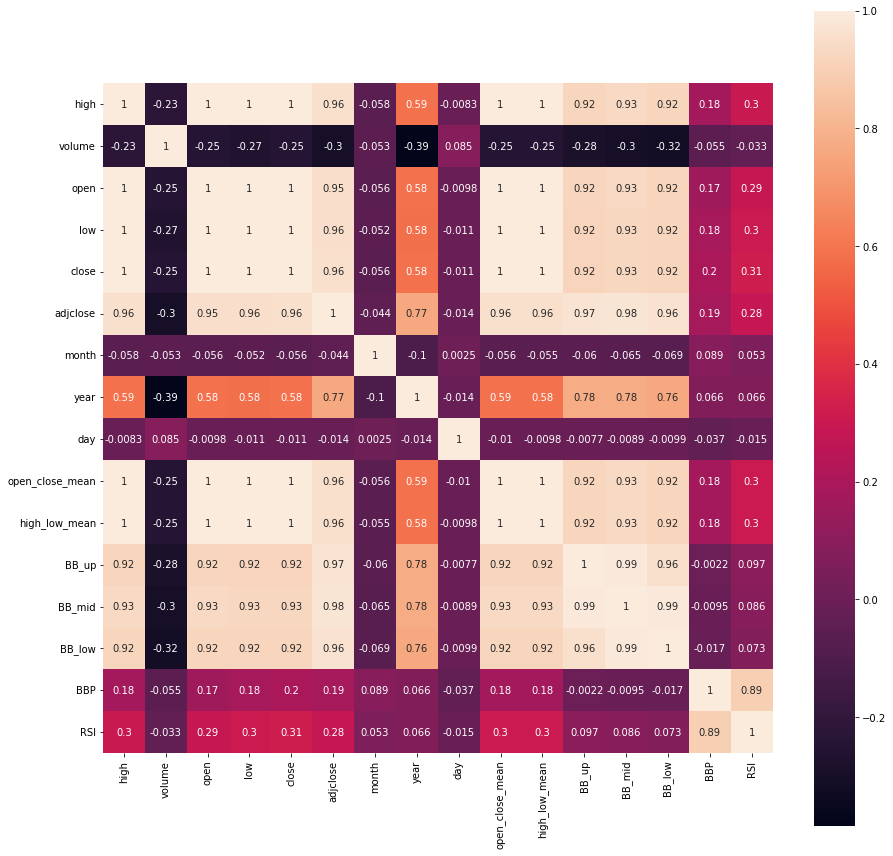




CDW
            high  volume        open         low       close    adjclose  \
19     21.980000  232400   20.340000   20.000000   21.980000   20.101274   
20     22.139999  141300   22.120001   21.049999   21.590000   19.744608   
21     22.000000   85200   21.500000   21.059999   21.700001   19.845201   
22     21.799999   94600   21.709999   20.799999   21.600000   19.753756   
23     21.790001   52500   21.790001   21.190001   21.500000   19.662298   
...          ...     ...         ...         ...         ...         ...   
2190  171.899994  720200  169.160004  166.940002  171.000000  171.000000   
2191  170.550003  438600  168.199997  167.029999  170.119995  170.119995   
2192  172.820007  751400  171.630005  169.820007  170.000000  170.000000   
2193  171.910004  799200  170.880005  165.199997  166.600006  166.600006   
2194  171.910004  800150  170.880005  165.195007  166.600006  166.600006   

                    date  month  year  day  open_close_mean  high_low_mean  \
19

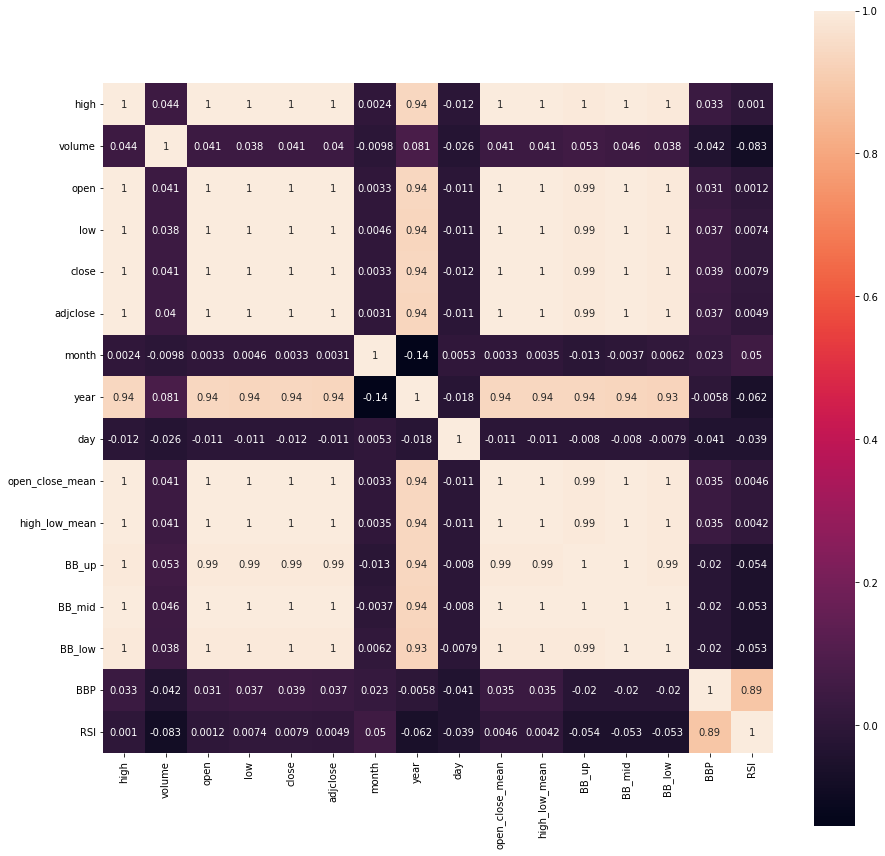




PYPL
            high    volume       open        low       close    adjclose  \
19     39.200001  12480600  39.139999  38.220001   38.700001   38.700001   
20     39.880001  15126600  39.250000  38.900002   39.389999   39.389999   
21     39.910000  10992200  39.910000  38.430000   38.950001   38.950001   
22     39.880001   9463100  39.700001  39.169998   39.270000   39.270000   
23     39.740002   7324100  39.630001  38.549999   38.849998   38.849998   
...          ...       ...        ...        ...         ...         ...   
1682  100.730003  20811300  98.120003  97.290001  100.220001  100.220001   
1683   99.320000  14703200  99.050003  96.400002   98.550003   98.550003   
1684   99.820000  15117200  99.750000  95.519997   96.570000   96.570000   
1685  100.639999  20969400  96.044998  94.629997   96.870003   96.870003   
1686  100.639999  20957703  96.044998  94.629997   96.870003   96.870003   

                    date  month  year  day  open_close_mean  high_low_mean  \
1

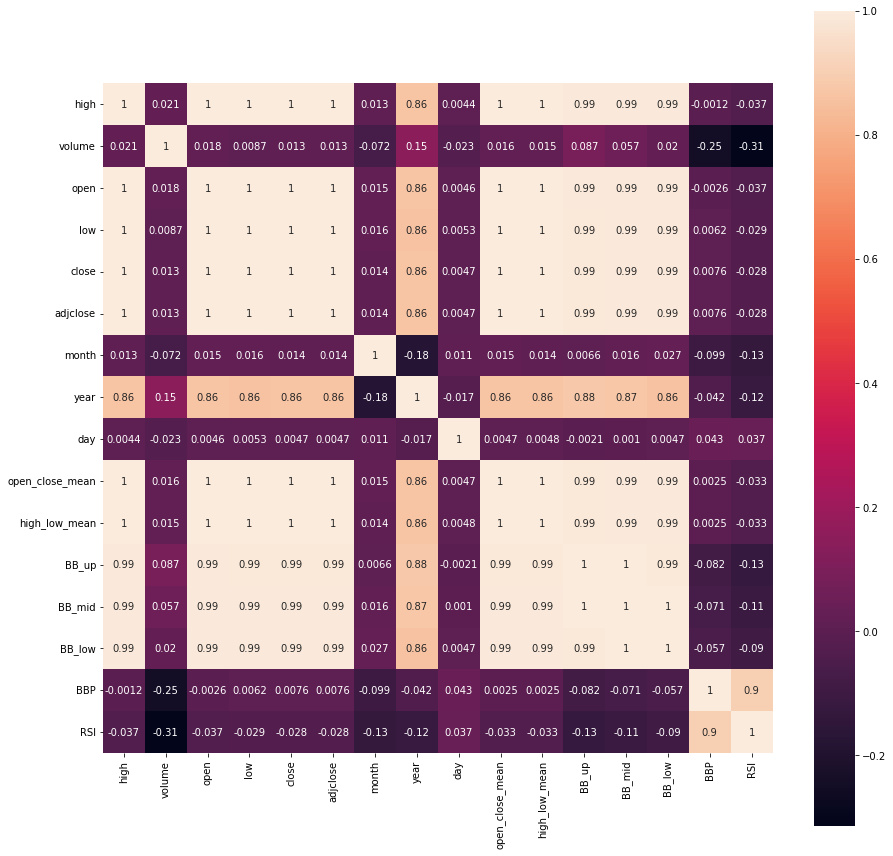




FB
            high    volume        open         low       close    adjclose  \
19     30.100000  43563800   28.510000   28.350000   30.010000   30.010000   
20     32.080002  42978900   29.959999   29.410000   31.410000   31.410000   
21     32.180000  30849000   31.540001   30.700001   31.910000   31.910000   
22     31.930000  15553600   31.920000   31.150000   31.600000   31.600000   
23     32.500000  21875300   31.670000   31.510000   31.840000   31.840000   
...          ...       ...         ...         ...         ...         ...   
2467  199.100006  31894700  195.740005  193.919998  198.500000  198.500000   
2468  196.279999  24853000  194.839996  191.070007  195.210007  195.210007   
2469  193.559998  34656900  192.639999  186.669998  187.610001  187.610001   
2470  192.289993  30980700  187.029999  185.820007  186.630005  186.630005   
2471  192.289993  31010462  187.029999  185.820007  186.630005  186.630005   

                    date  month  year  day  open_close_me

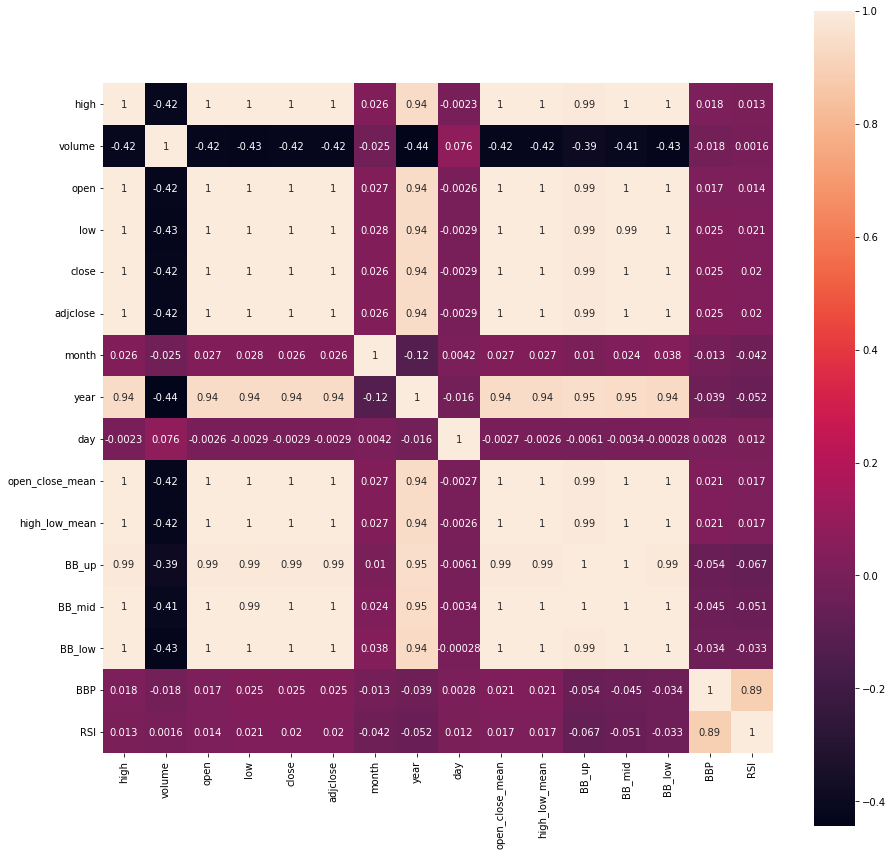




CHTR
            high   volume        open         low       close    adjclose  \
19     61.130001   310100   60.759998   60.209999   61.060001   61.060001   
20     61.220001   243300   61.099998   60.689999   60.970001   60.970001   
21     61.180000   155500   61.180000   60.160000   60.340000   60.340000   
22     61.540001   357600   60.779999   60.709999   61.310001   61.310001   
23     61.259998   194000   61.110001   60.730000   61.160000   61.160000   
...          ...      ...         ...         ...         ...         ...   
2512  568.039978  1212200  562.169983  555.570007  557.750000  557.750000   
2513  567.559998  1537700  550.210022  546.919983  562.130005  562.130005   
2514  574.539978  1788200  569.780029  557.809998  559.289978  559.289978   
2515  583.719971  1420600  561.820007  560.659973  566.140015  566.140015   
2516  583.719971  1389223  561.820007  560.659973  566.140015  566.140015   

                    date  month  year  day  open_close_mean  high_l

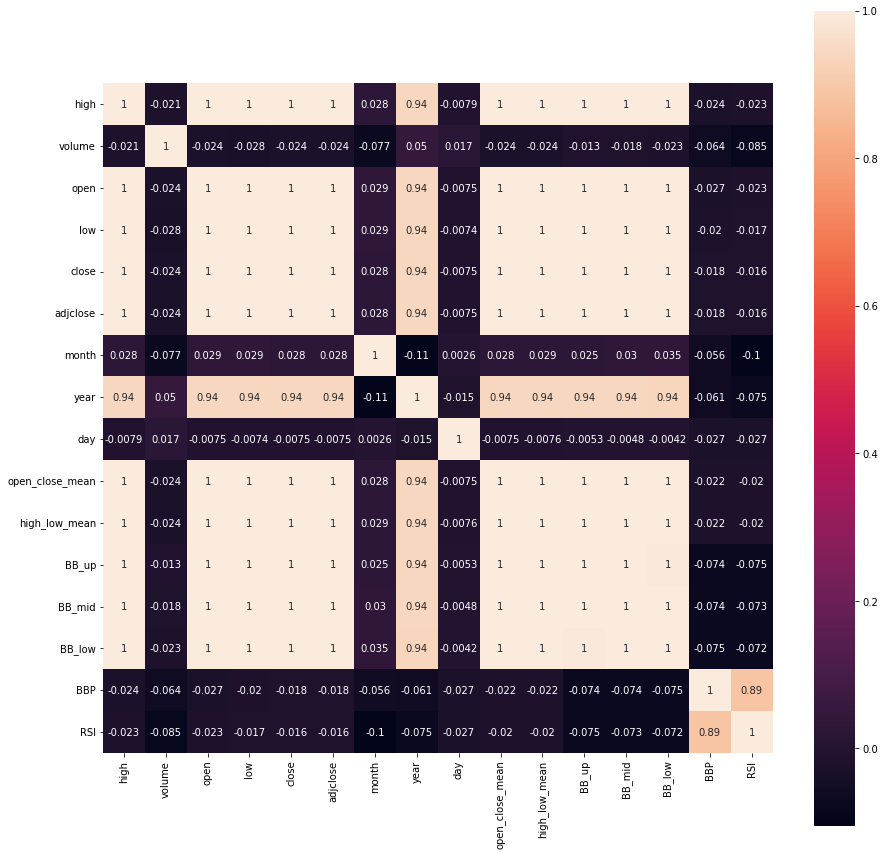




ATVI
           high    volume       open        low      close   adjclose  \
19    12.520000   6652200  12.400000  12.380000  12.480000  11.618316   
20    12.510000   8462300  12.480000  12.380000  12.420000  11.562460   
21    12.480000   6887200  12.440000  12.230000  12.260000  11.413507   
22    12.430000   8556200  12.270000  12.240000  12.270000  11.422816   
23    12.380000   7681900  12.260000  12.210000  12.250000  11.404197   
...         ...       ...        ...        ...        ...        ...   
2512  81.489998   9914500  81.370003  80.660004  80.830002  80.830002   
2513  81.269997   6981400  80.769997  80.570000  80.800003  80.800003   
2514  81.199997  10713900  80.800003  80.180000  80.309998  80.309998   
2515  80.440002   9533000  80.050003  79.449997  79.550003  79.550003   
2516  80.445000   9535962  80.050003  79.449997  79.550003  79.550003   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012

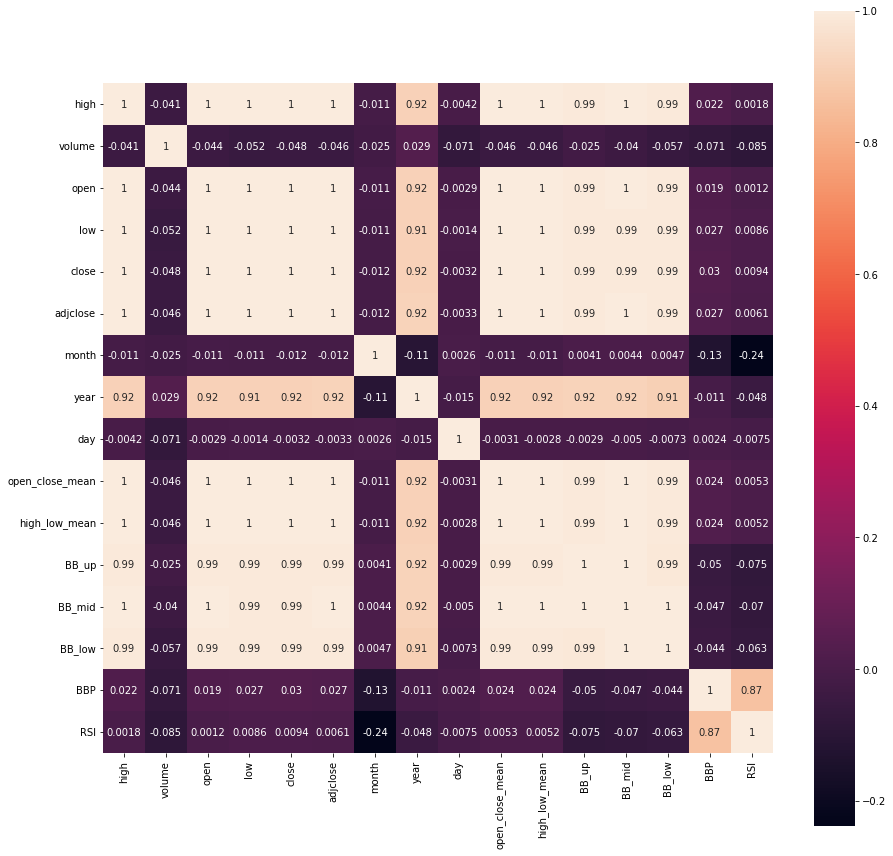




CAG
           high    volume       open        low      close   adjclose  \
19    20.186769  14828129  20.077822  19.945524  20.186769  14.487864   
20    20.319065  14728670  20.186769  20.046694  20.054476  14.392915   
21    20.186769  13855641  20.062258  20.007782  20.132296  14.448768   
22    20.396887   3917708  20.225681  20.101168  20.326847  14.588398   
23    20.311283   4091568  20.272373  20.163424  20.264591  14.543716   
...         ...       ...        ...        ...        ...        ...   
2512  32.250000   5442800  31.360001  31.170000  31.180000  31.180000   
2513  31.070000   7632500  31.000000  30.180000  30.670000  30.670000   
2514  30.879999   5523800  30.780001  30.059999  30.100000  30.100000   
2515  32.049999   9878700  30.830000  30.510000  31.570000  31.570000   
2516  32.049999   9806805  30.830000  30.504999  31.570000  31.570000   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012 

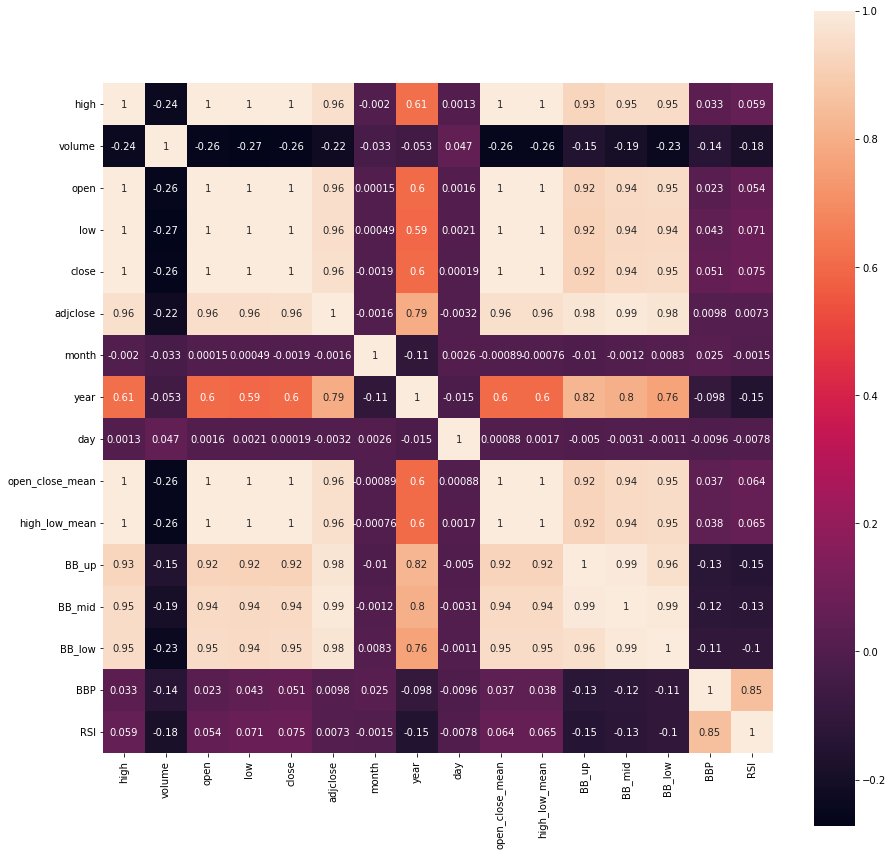




MO
           high    volume       open        low      close   adjclose  \
19    31.330000   5368400  31.200001  31.049999  31.309999  18.467628   
20    31.770000  17839400  31.299999  31.209999  31.490000  18.573805   
21    31.639999   6872000  31.549999  31.350000  31.379999  18.508923   
22    31.610001   6882500  31.490000  31.230000  31.610001  18.644588   
23    31.750000   8057400  31.510000  31.420000  31.660000  18.674078   
...         ...       ...        ...        ...        ...        ...   
2512  51.770000   9772300  51.549999  50.900002  51.000000  51.000000   
2513  51.439999   7567200  50.889999  50.310001  51.230000  51.230000   
2514  51.549999   9433800  51.080002  50.410000  50.480000  50.480000   
2515  51.119999  11266000  50.650002  49.790001  50.540001  50.540001   
2516  51.119999  10438716  50.650002  49.790001  50.540001  50.540001   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012  

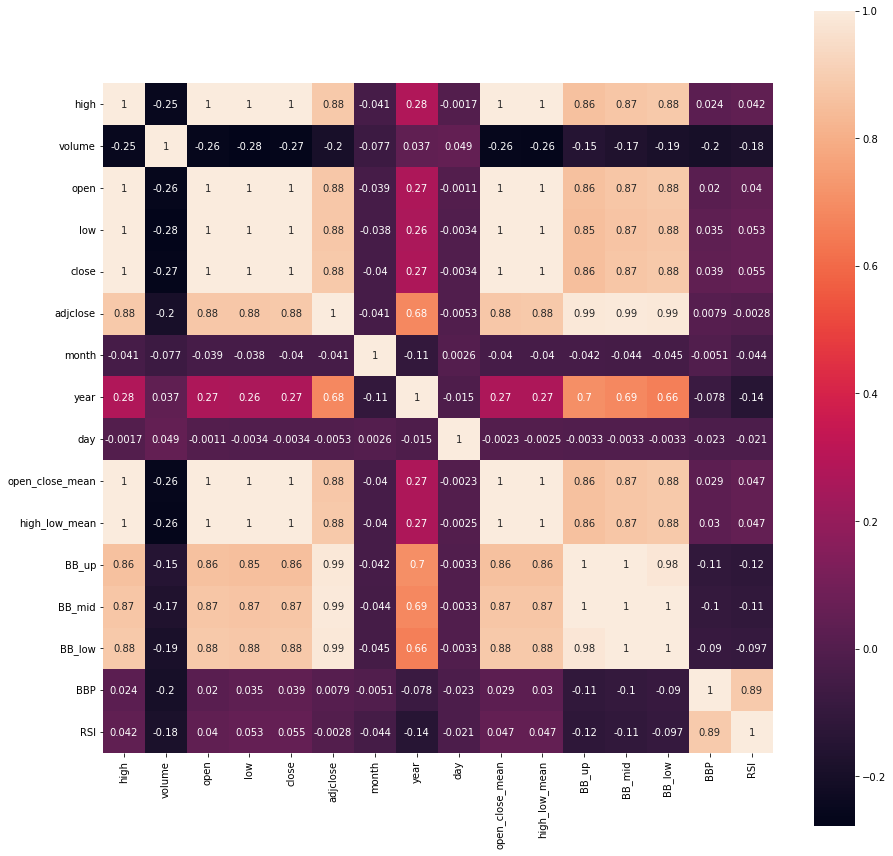




PM
           high    volume       open        low      close   adjclose  \
19    87.779999   5058900  87.739998  86.620003  87.260002  54.497597   
20    88.790001   6023400  87.550003  87.410004  87.839996  54.859829   
21    88.260002   5765900  88.169998  86.529999  87.040001  54.360199   
22    87.900002   4819400  87.260002  86.790001  87.449997  54.616268   
23    88.110001   4861600  87.000000  86.629997  87.739998  54.797382   
...         ...       ...        ...        ...        ...        ...   
2511  96.360001  11529300  94.190002  92.699997  93.970001  93.970001   
2512  96.070000   6427300  95.220001  93.349998  93.809998  93.809998   
2513  93.830002   8099400  92.930000  91.599998  91.889999  91.889999   
2514  92.419998   8628300  92.269997  88.760002  88.870003  88.870003   
2515  90.580002   9927371  89.889999  88.370003  89.589996  89.589996   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012  

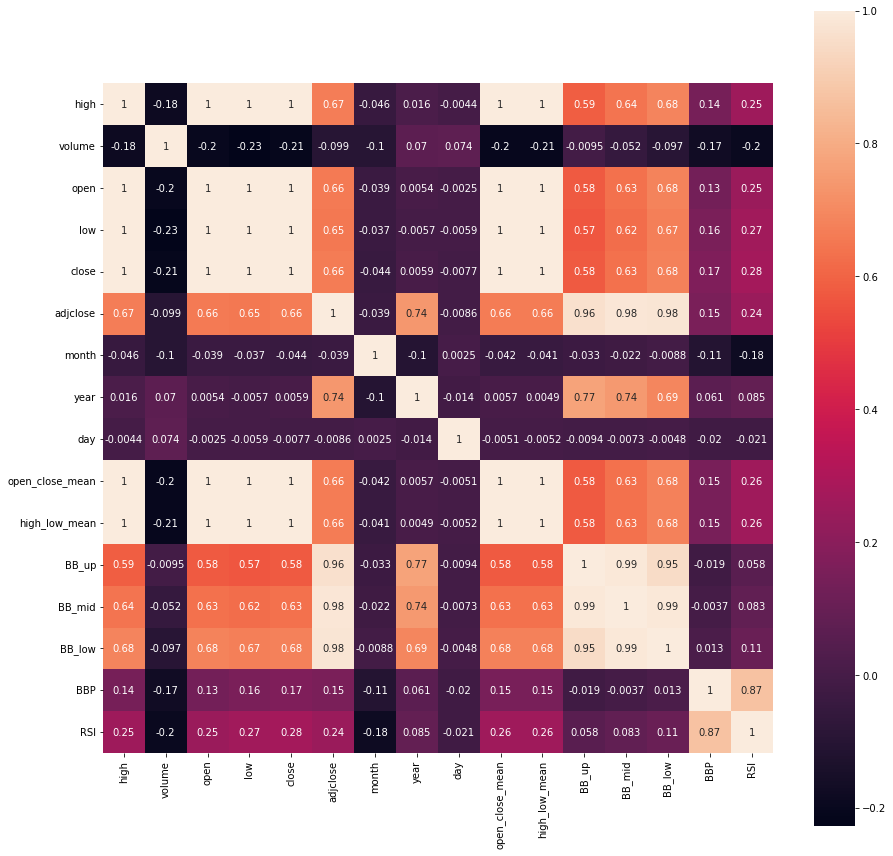




LW
           high   volume       open        low      close   adjclose  \
19    36.000000  2603000  34.910000  34.610001  35.930000  33.464325   
20    36.509998  1993100  35.820000  35.599998  36.380001  33.883438   
21    37.215000  1258300  36.380001  36.310001  36.730000  34.209419   
22    37.090000  1814000  36.970001  35.669998  36.580002  34.069725   
23    37.000000  3886300  36.619999  34.970001  35.150002  32.737862   
...         ...      ...        ...        ...        ...        ...   
1339  55.139999  2195600  53.709999  53.270000  53.320000  53.320000   
1340  52.450001  1335900  52.150002  50.910000  51.330002  51.330002   
1341  51.810001  1500800  51.599998  50.070000  50.110001  50.110001   
1342  51.020000  1556400  50.570000  49.709999  49.959999  49.959999   
1343  51.020000  1538405  50.570000  49.709999  49.959999  49.959999   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2016-12-08 09:30:00     12  2016    8        3

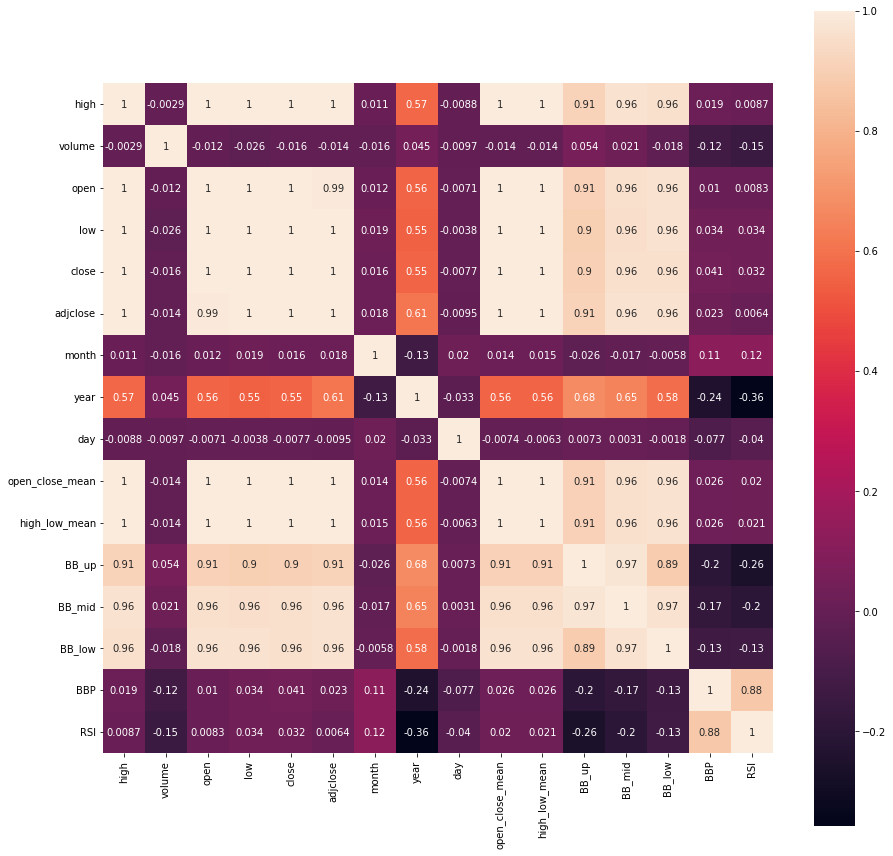




MHK
            high   volume        open         low       close    adjclose  \
19     63.419998   545700   62.299999   62.119999   63.119999   63.119999   
20     63.320000   631600   62.990002   62.000000   62.660000   62.660000   
21     63.389999   363300   63.150002   62.070000   62.849998   62.849998   
22     64.250000   278800   63.410000   63.220001   63.700001   63.700001   
23     63.919998   513900   63.160000   62.209999   63.230000   63.230000   
...          ...      ...         ...         ...         ...         ...   
2511  132.240005  1469000  124.580002  121.040001  128.320007  128.320007   
2512  140.240005  1127600  132.940002  132.320007  136.860001  136.860001   
2513  135.649994   745600  134.119995  131.300003  132.759995  132.759995   
2514  135.679993   864900  135.529999  130.979996  131.110001  131.110001   
2515  133.494995   541738  132.559998  129.860001  131.039993  131.039993   

                    date  month  year  day  open_close_mean  high_lo

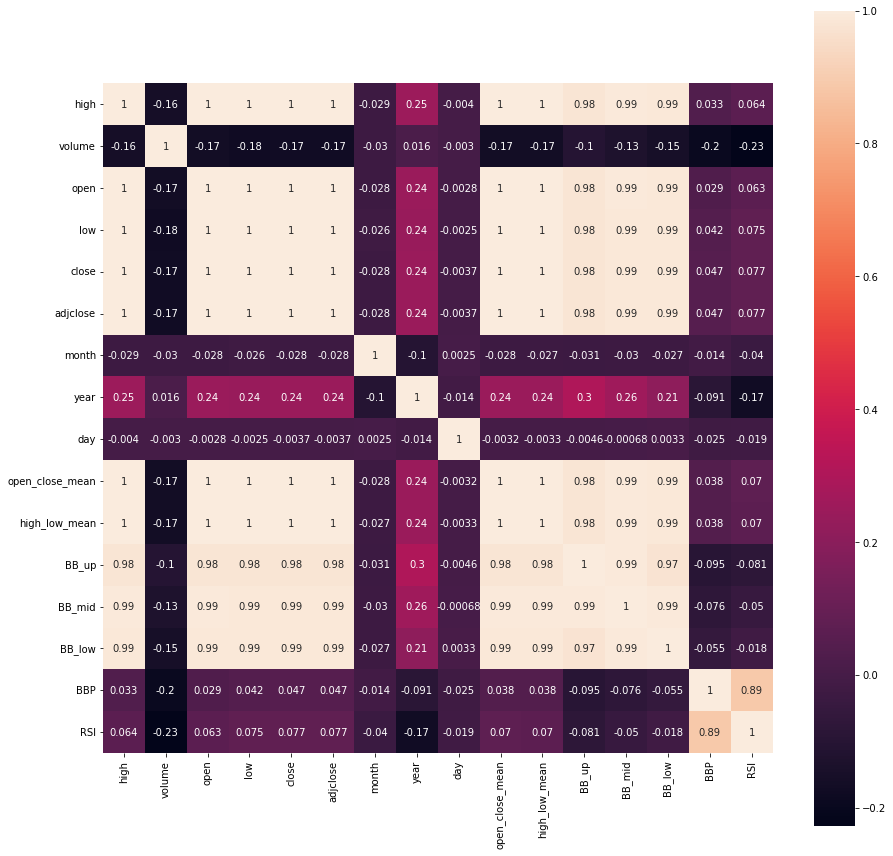




CZR
           high   volume       open        low      close   adjclose  \
19     4.050000    11800   4.040000   3.943000   4.000000   4.000000   
20     4.080000     8500   3.970000   3.910000   4.045000   4.045000   
21     4.080000   187400   3.920000   3.920000   4.010000   4.010000   
22     4.110000    44400   4.030000   3.930000   4.060000   4.060000   
23     4.140000    41200   4.090000   4.040000   4.040000   4.040000   
...         ...      ...        ...        ...        ...        ...   
1879  80.410004  4083800  74.260002  74.250000  77.589996  77.589996   
1880  78.389999  1723700  75.709999  75.180000  77.459999  77.459999   
1881  78.870003  1492000  78.440002  74.320000  74.809998  74.809998   
1882  77.099998  2905700  74.690002  70.555000  71.970001  71.970001   
1883  77.099998  2976874  74.690002  70.559998  71.970001  71.970001   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2014-10-17 08:30:00     10  2014   17        

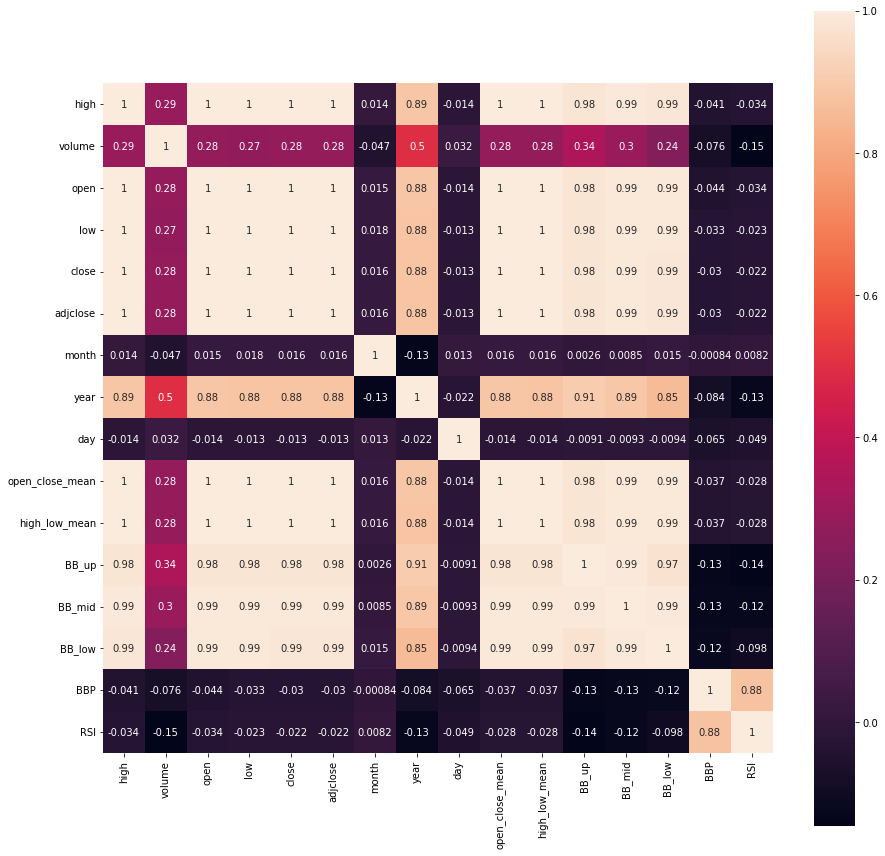




AMZN
             high   volume         open          low        close  \
19     192.259995  4027900   188.059998   185.610001   190.690002   
20     189.940002  3431800   189.899994   186.259995   188.460007   
21     189.470001  4044300   189.009995   183.649994   185.500000   
22     190.039993  2829200   187.210007   186.869995   188.389999   
23     193.449997  4001900   188.820007   188.740005   191.070007   
...           ...      ...          ...          ...          ...   
2511  2813.989990  4583100  2733.669922  2671.449951  2720.290039   
2512  2805.000000  4132800  2790.000000  2736.560059  2785.580078   
2513  2973.489990  6753100  2913.699951  2879.560059  2936.350098   
2514  2993.500000  3440500  2991.489990  2907.379883  2910.489990   
2515  2948.289795  3547636  2919.620117  2817.679932  2837.060059   

         adjclose                date  month  year  day  open_close_mean  \
19     190.690002 2012-04-12 08:30:00      4  2012   12       189.375000   
20     188.

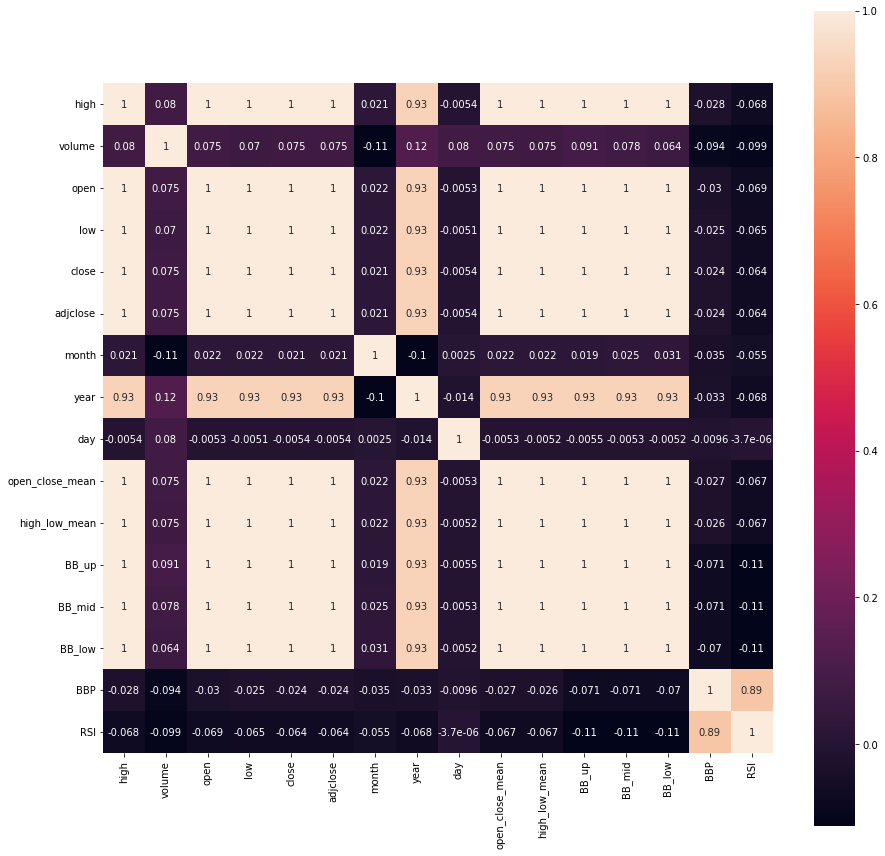




HLT
            high   volume        open         low       close    adjclose  \
19     44.856720   812329   44.651520   44.261639   44.507881   42.260826   
20     44.795158   728216   44.241119   44.241119   44.569439   42.319275   
21     45.369720  1251608   44.548920   44.405281   45.349201   43.059673   
22     45.492840   915253   45.246601   44.795158   44.959320   42.689476   
23     45.205559  1130019   44.938801   44.507881   45.061920   42.786900   
...          ...      ...         ...         ...         ...         ...   
2073  140.669998  3171000  138.500000  137.460007  138.520004  138.520004   
2074  144.330002  3309500  135.490005  135.199997  142.940002  142.940002   
2075  145.800003  1684700  144.580002  141.529999  141.770004  141.770004   
2076  143.910004  1586700  143.190002  140.250000  141.559998  141.559998   
2077  143.904999  1544807  143.190002  140.245300  141.559998  141.559998   

                    date  month  year  day  open_close_mean  high_lo

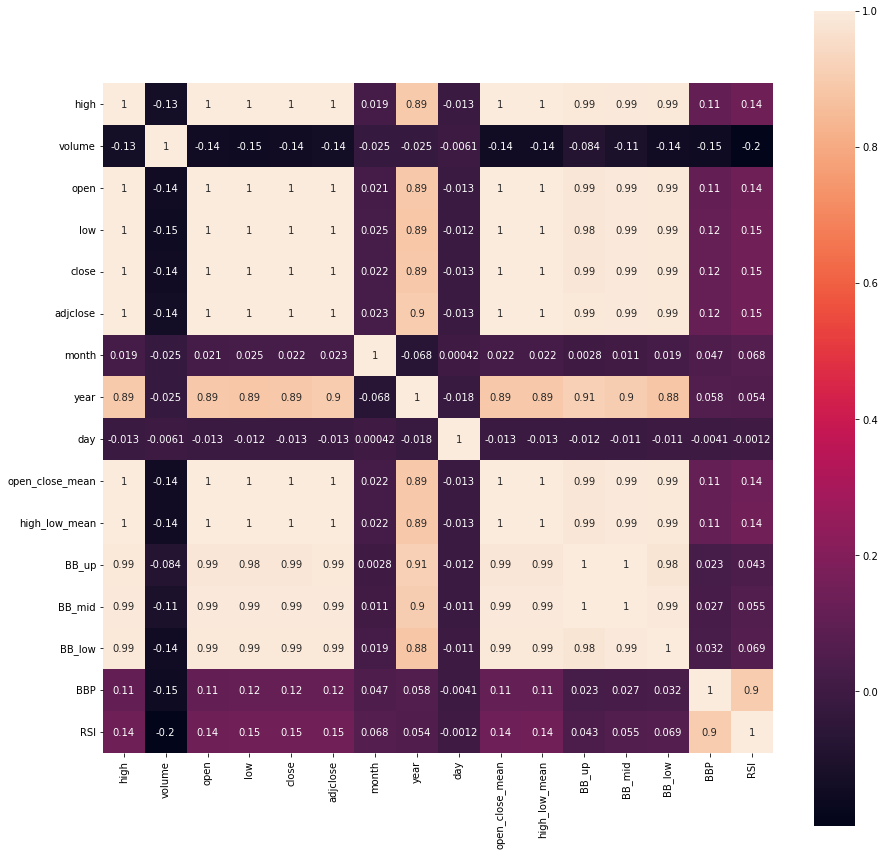




PENN
           high   volume       open        low      close   adjclose  \
19     9.565905  1955851   9.493556   9.452860   9.477730   9.477730   
20     9.468686  1997427   9.464165   9.276509   9.398598   9.398598   
21     9.541035  1750181   9.418946   9.330771   9.468686   9.468686   
22     9.579471   858062   9.527470   9.516165   9.534253   9.534253   
23     9.794257  2880258   9.529731   9.529731   9.789735   9.789735   
...         ...      ...        ...        ...        ...        ...   
2511  41.959999  8473300  40.919998  39.230000  41.750000  41.750000   
2512  44.630001  4183000  42.790001  42.200001  43.830002  43.830002   
2513  44.430000  3702900  42.939999  42.799999  44.189999  44.189999   
2514  45.000000  2655000  44.709999  42.650002  42.669998  42.669998   
2515  43.540001  3906738  42.500000  39.785000  40.299999  40.299999   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012   12       

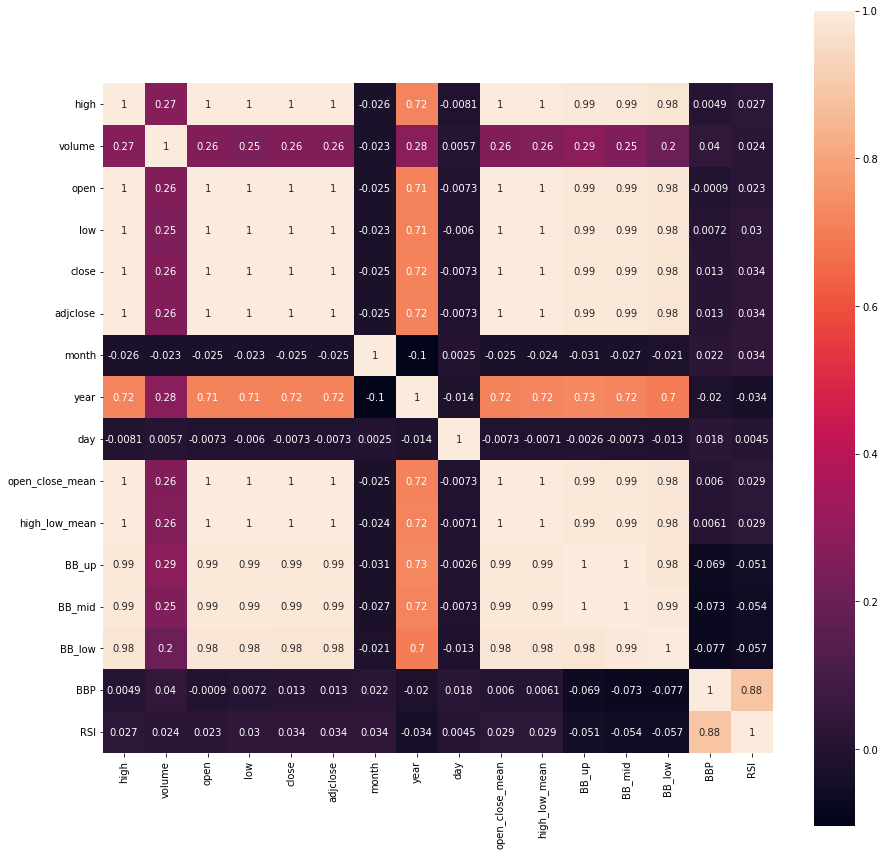




PHM
           high    volume       open        low      close   adjclose  \
19     8.670000  10297800   8.430000   8.380000   8.660000   7.649417   
20     8.760000  14557800   8.760000   8.420000   8.540000   7.543419   
21     8.900000  14016700   8.790000   8.390000   8.430000   7.446258   
22     8.770000   8727600   8.510000   8.490000   8.650000   7.640582   
23     8.650000  10230400   8.560000   8.270000   8.370000   7.393258   
...         ...       ...        ...        ...        ...        ...   
2511  48.040001   2667200  46.150002  45.410000  46.080002  45.931004   
2512  48.490002   2492700  47.400002  47.040001  47.669998  47.515862   
2513  47.270000   2115900  46.560001  45.930000  47.150002  46.997543   
2514  47.709999   1845500  47.580002  46.330002  46.389999  46.240002   
2515  46.400002   2850352  46.400002  43.689999  44.259998  44.259998   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012 

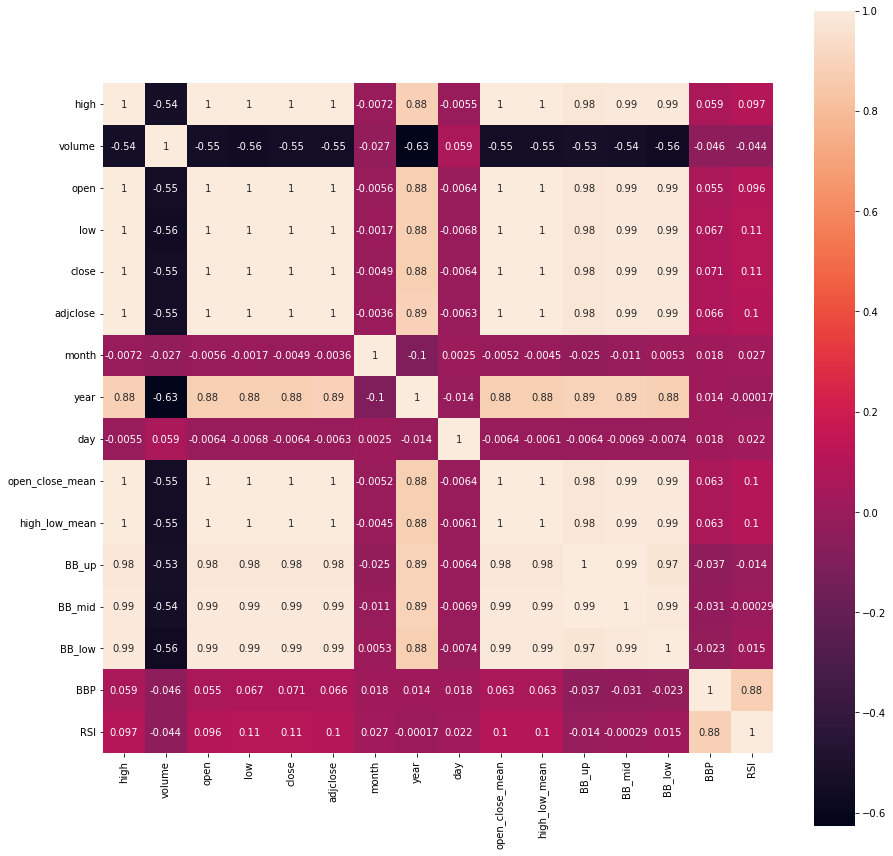




EXC
           high   volume       open        low      close   adjclose  \
19    27.310984  8563977  27.310984  26.932953  27.025679  15.893789   
20    27.296719  7791194  27.025679  26.733238  26.740372  15.726003   
21    27.104137  6019627  26.811699  26.747503  26.968616  15.860227   
22    27.189730  4832414  27.111271  26.861626  27.154066  15.969290   
23    27.118402  5778203  27.118402  26.818830  26.854494  15.793122   
...         ...      ...        ...        ...        ...        ...   
2511  44.290001  8624200  44.160000  43.099998  43.490002  43.490002   
2512  43.919998  8573000  43.740002  43.259998  43.549999  43.549999   
2513  43.810001  9859100  43.310001  43.139999  43.599998  43.599998   
2514  44.400002  6407100  44.240002  43.590000  43.630001  43.630001   
2515  44.119999  6793504  43.700001  43.514999  43.580002  43.580002   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012   12        

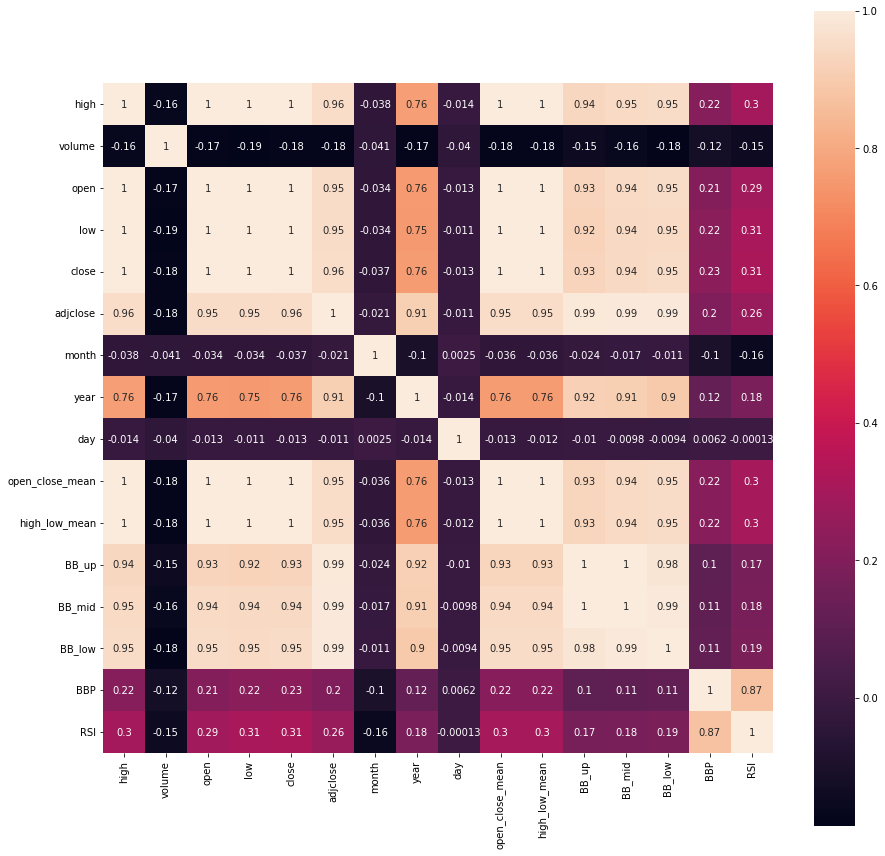




AWK
            high   volume        open         low       close    adjclose  \
19     33.389999   465000   33.119999   32.980000   33.369999   27.028027   
20     33.590000   890600   33.349998   33.029999   33.049999   26.768843   
21     33.259998  1073900   33.049999   32.980000   33.070000   26.785046   
22     33.520000   913300   33.110001   33.009998   33.369999   27.028027   
23     33.650002  1227900   33.119999   32.830002   33.340000   27.191137   
...          ...      ...         ...         ...         ...         ...   
2511  159.320007  1363200  157.410004  153.520004  154.250000  154.250000   
2512  156.770004   881200  155.960007  152.610001  153.789993  153.789993   
2513  153.289993   958700  153.240005  151.149994  153.130005  153.130005   
2514  154.929993   964500  153.330002  151.259995  152.080002  152.080002   
2515  154.949997   893177  153.610001  151.639999  152.619995  152.619995   

                    date  month  year  day  open_close_mean  high_lo

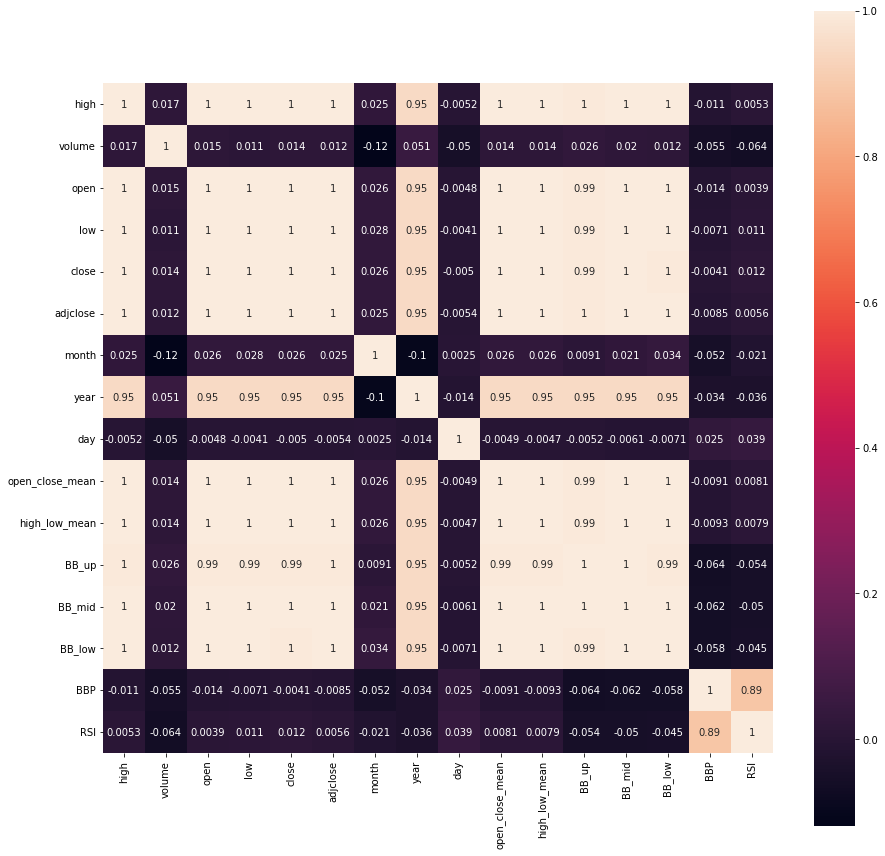




AES
           high   volume       open        low      close   adjclose  \
19    12.700000  2736600  12.470000  12.430000  12.660000   9.418514   
20    12.650000  6022400  12.590000  12.380000  12.400000   9.225086   
21    12.570000  4594700  12.490000  12.390000  12.440000   9.254846   
22    12.580000  7471100  12.560000  12.260000  12.340000   9.180450   
23    12.460000  5753300  12.320000  12.210000  12.250000   9.113491   
...         ...      ...        ...        ...        ...        ...   
2511  22.190001  8533300  22.000000  21.559999  21.559999  21.559999   
2512  22.230000  6540500  21.959999  21.750000  21.959999  21.959999   
2513  22.410000  3953100  21.820000  21.700001  22.350000  22.350000   
2514  22.740000  4679500  22.389999  22.190001  22.200001  22.200001   
2515  22.504999  4476941  22.320000  21.590000  21.719999  21.719999   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012   12        

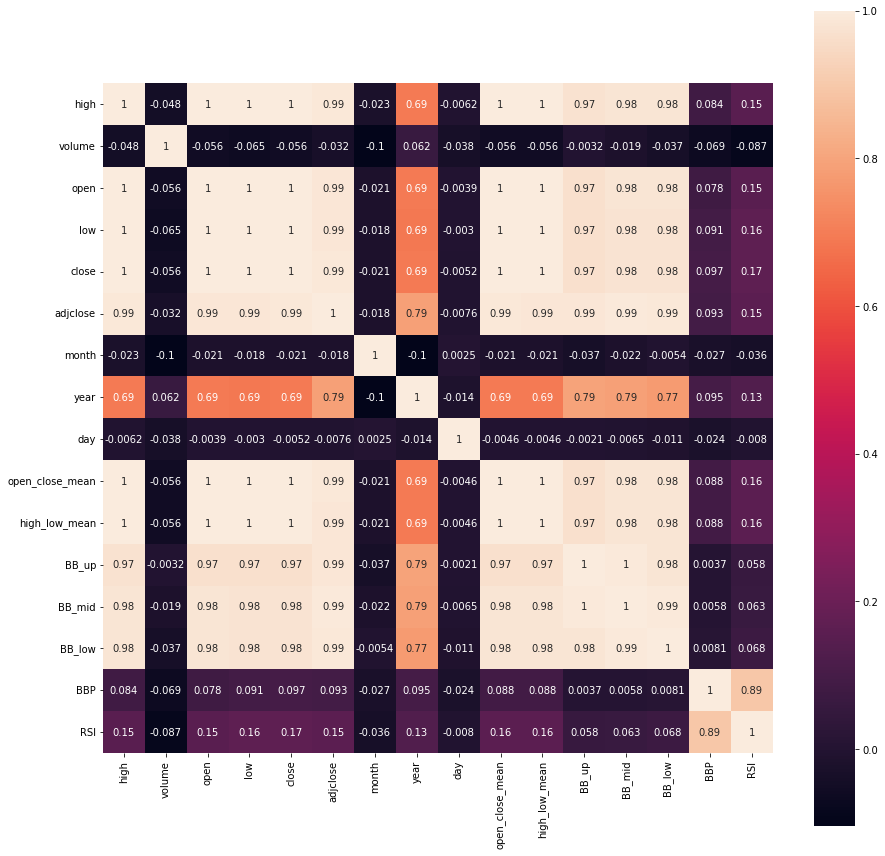




CB
            high   volume        open         low       close    adjclose  \
19     73.029999  1207300   72.089996   71.709999   73.019997   58.332184   
20     72.959999  1452100   72.839996   71.559998   71.559998   57.165878   
21     72.669998  1335600   71.720001   71.669998   72.440002   57.868870   
22     73.080002  1279300   72.860001   72.230003   72.959999   58.284286   
23     72.680000  1663500   72.519997   72.120003   72.349998   57.796963   
...          ...      ...         ...         ...         ...         ...   
2511  203.509995  2071300  200.190002  196.199997  197.649994  197.649994   
2512  205.470001  1479100  202.809998  202.440002  203.940002  203.940002   
2513  203.889999  1902000  201.539993  200.630005  201.419998  201.419998   
2514  204.880005  1424000  202.190002  201.729996  201.910004  201.910004   
2515  207.710007  1142356  205.000000  203.410004  204.960007  204.960007   

                    date  month  year  day  open_close_mean  high_low

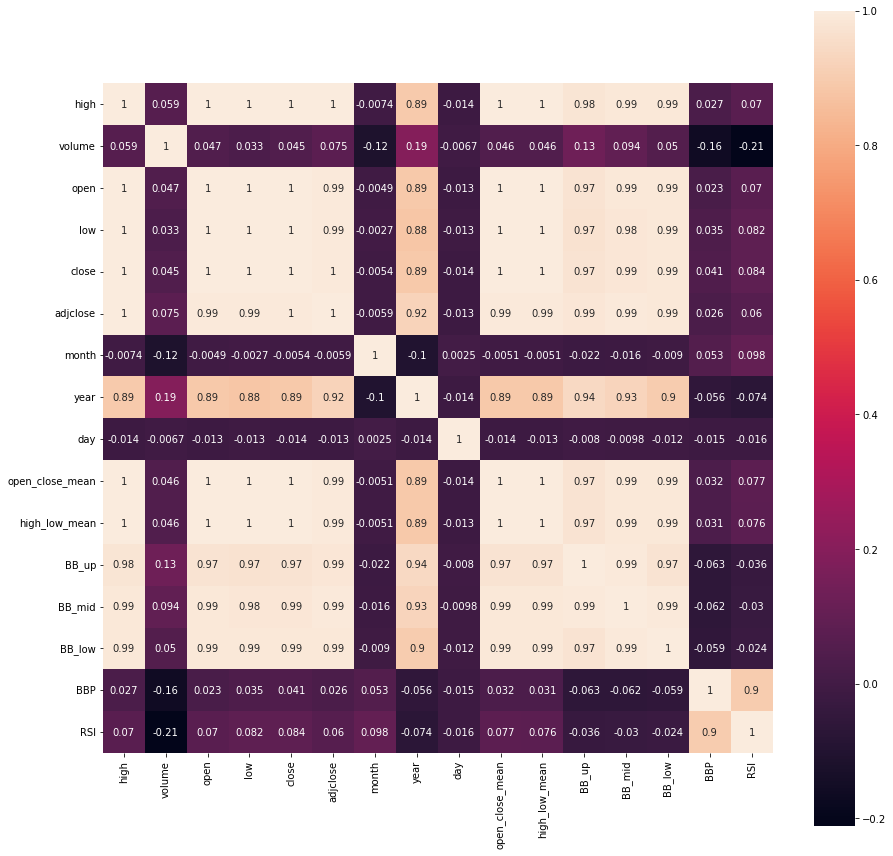




AXP
            high   volume        open         low       close    adjclose  \
19     58.070000  4881200   57.040001   56.730000   58.040001   50.454723   
20     58.090000  5574900   58.009998   57.180000   57.279999   49.794037   
21     58.060001  6443700   57.730000   57.060001   57.830002   50.272163   
22     58.389999  5197600   57.959999   57.650002   58.180000   50.576408   
23     58.700001  5669900   58.160000   57.950001   58.040001   50.454723   
...          ...      ...         ...         ...         ...         ...   
2511  166.289993  7058900  160.520004  155.720001  160.050003  160.050003   
2512  170.729996  4788200  168.020004  166.710007  168.649994  168.649994   
2513  170.960007  3840900  165.589996  164.830002  169.600006  169.600006   
2514  172.309998  2999000  171.750000  167.630005  167.899994  167.899994   
2515  174.710007  4534899  171.330002  169.710007  172.789993  172.789993   

                    date  month  year  day  open_close_mean  high_lo

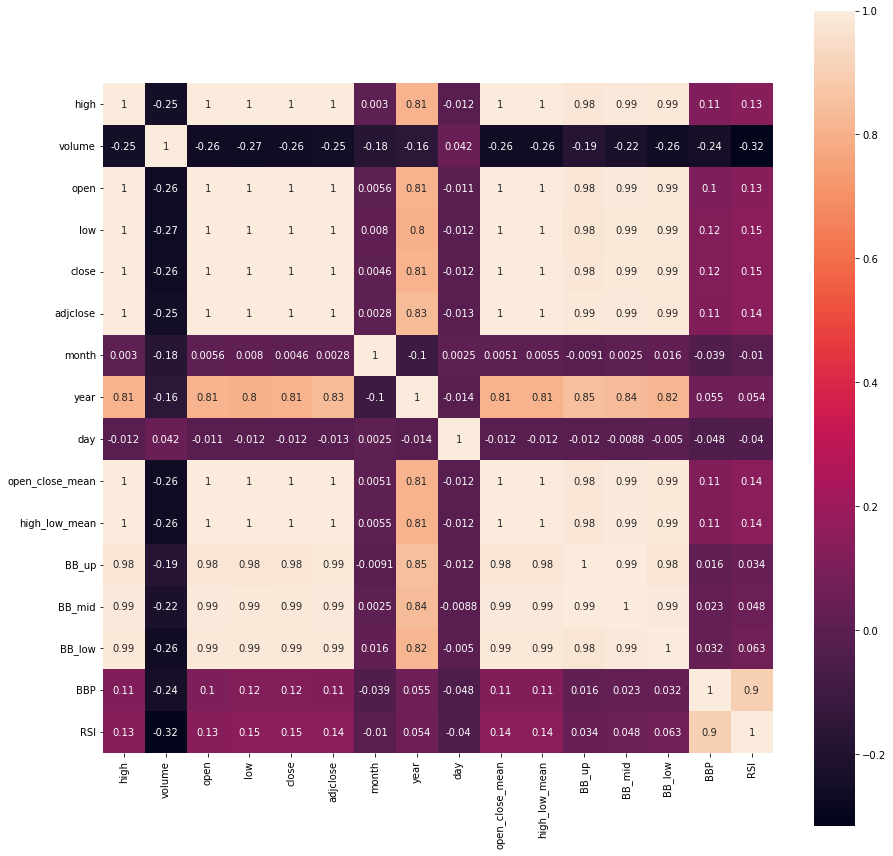




PGR
            high   volume        open         low       close    adjclose  \
19     22.610001  5781800   22.520000   22.340000   22.590000   16.612103   
20     22.690001  3925500   22.570000   22.340000   22.340000   16.428263   
21     22.660000  2901900   22.480000   22.450001   22.610001   16.626812   
22     22.870001  6352300   22.870001   22.580000   22.700001   16.692997   
23     22.709999  3895500   22.709999   22.450001   22.600000   16.619459   
...          ...      ...         ...         ...         ...         ...   
2511  108.809998  3411000  106.430000  103.750000  103.760002  103.760002   
2512  105.610001  2447800  104.430000  102.300003  104.099998  104.099998   
2513  105.209999  1943700  103.839996  103.470001  104.669998  104.669998   
2514  106.750000  1652600  104.510002  104.480003  105.540001  105.540001   
2515  107.870003  1821611  106.870003  105.415001  105.709999  105.709999   

                    date  month  year  day  open_close_mean  high_lo

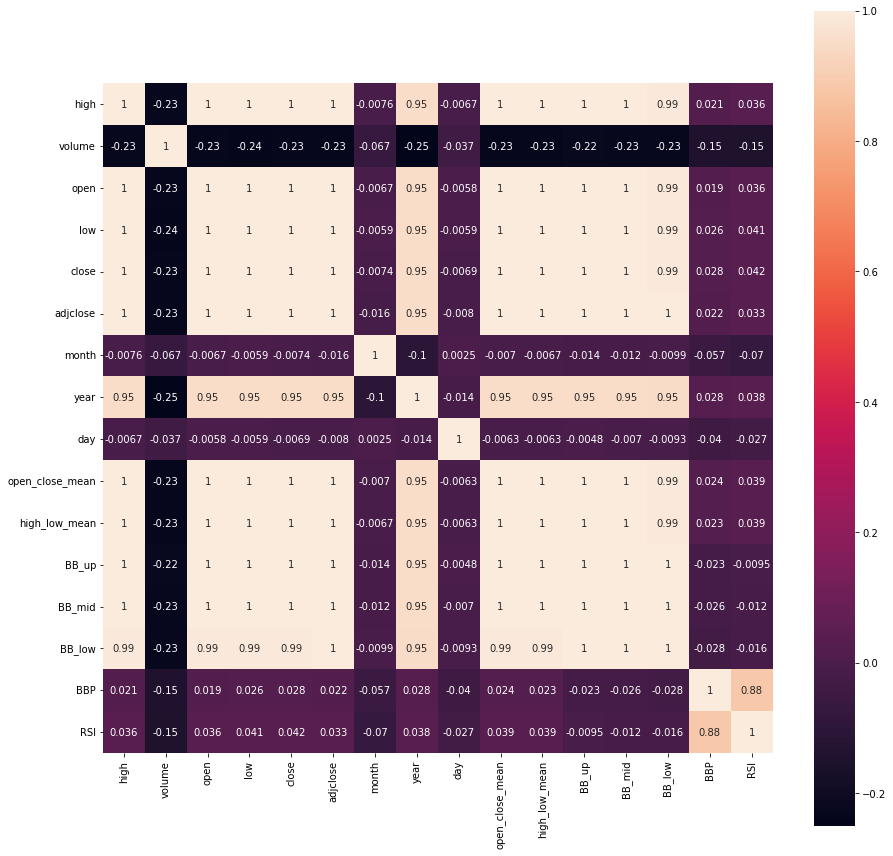




WFC
           high    volume       open        low      close   adjclose  \
19    34.160000  31469600  33.689999  33.520000  34.020000  25.517958   
20    33.869999  41933000  33.730000  32.799999  32.840000  24.632860   
21    33.450001  30129800  33.180000  32.669998  33.150002  24.865385   
22    33.779999  23724900  33.320000  33.279999  33.680000  25.262930   
23    33.740002  19718500  33.459999  33.330002  33.570000  25.180420   
...         ...       ...        ...        ...        ...        ...   
2511  48.200001  60018100  46.680000  46.349998  46.459999  46.459999   
2512  49.750000  34560200  48.790001  48.349998  49.160000  49.160000   
2513  49.570000  26178800  48.259998  47.849998  49.009998  49.009998   
2514  50.000000  23695900  49.669998  48.430000  48.470001  48.470001   
2515  50.377102  27678594  49.660000  49.294998  49.860001  49.860001   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012 

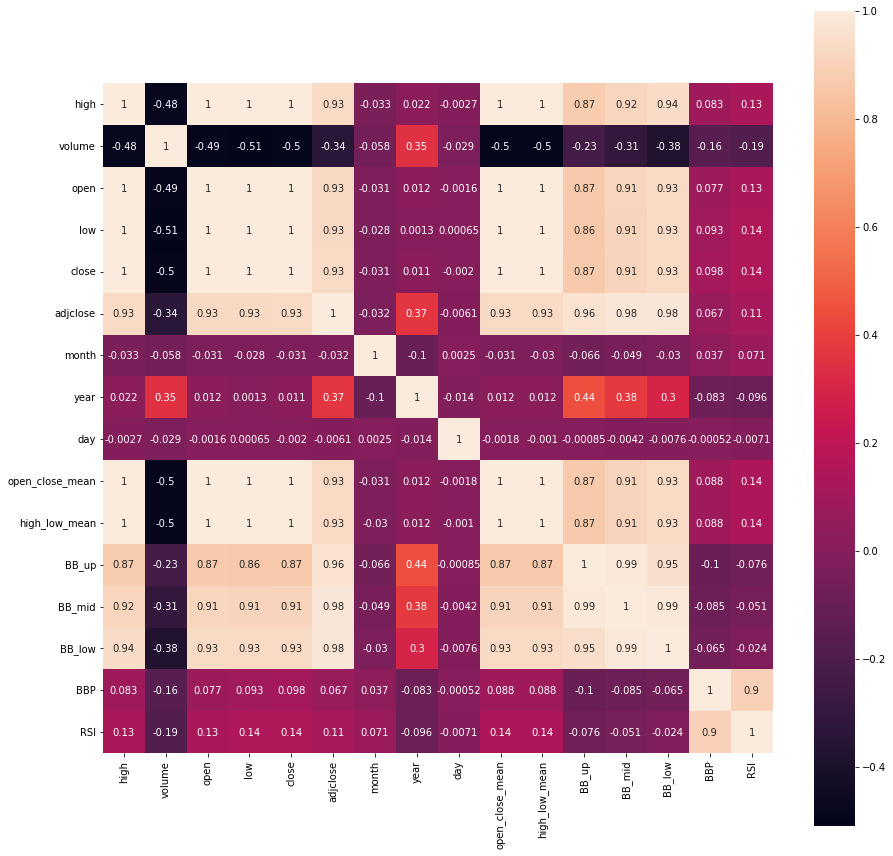




L
           high   volume       open        low      close   adjclose  \
19    39.450001   789300  38.709999  38.709999  39.430000  37.237518   
20    39.439999  1233400  39.330002  38.910000  38.910000  36.746441   
21    39.340000  1193000  39.169998  38.959999  39.250000  37.067543   
22    39.930000  1313000  39.430000  39.270000  39.919998  37.700279   
23    39.889999   980600  39.680000  39.599998  39.650002  37.445305   
...         ...      ...        ...        ...        ...        ...   
2511  61.200001  1118800  60.439999  59.759998  60.060001  60.060001   
2512  62.340000   900200  61.459999  60.990002  61.029999  61.029999   
2513  61.200001   961600  60.360001  60.360001  60.900002  60.900002   
2514  61.869999   648400  61.230000  60.759998  60.880001  60.880001   
2515  62.299999   701479  61.900002  61.200001  61.669998  61.669998   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012   12        39

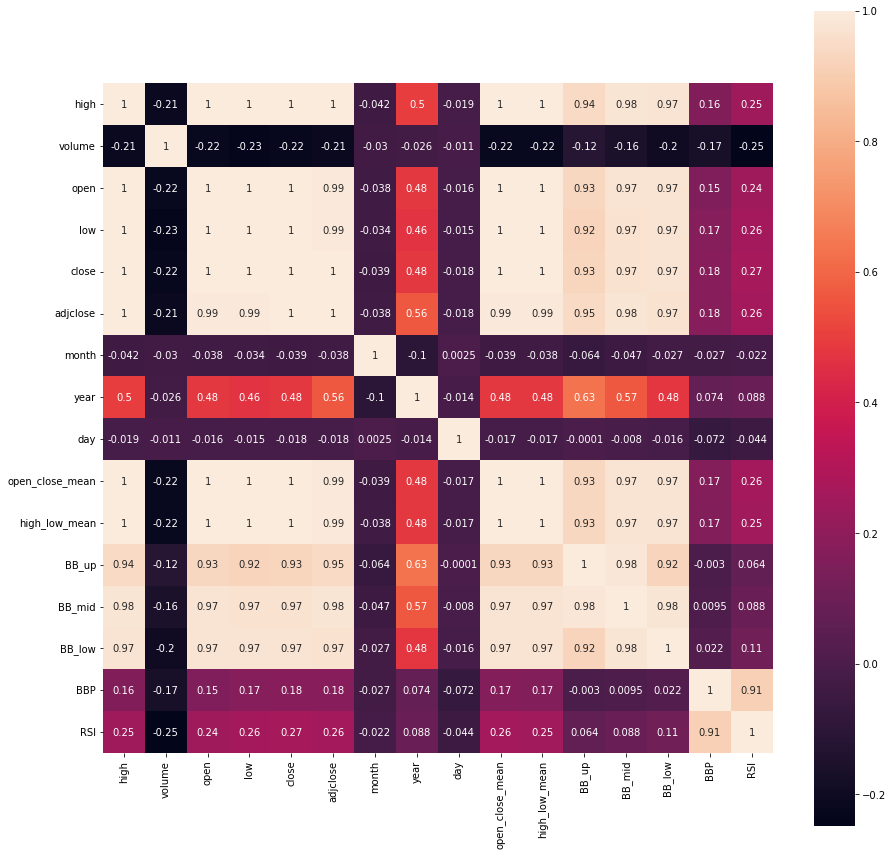




SCHW
           high    volume       open        low      close   adjclose  \
19    14.290000  10942200  13.920000  13.790000  14.240000  12.654298   
20    14.220000  16044600  14.210000  13.870000  13.870000  12.325500   
21    14.300000  19331900  14.000000  13.520000  13.750000  12.218862   
22    14.140000  13530900  13.790000  13.780000  13.990000  12.432136   
23    14.090000  10122700  13.880000  13.880000  14.010000  12.449908   
...         ...       ...        ...        ...        ...        ...   
2511  77.699997   7100700  77.150002  74.629997  75.690002  75.690002   
2512  80.160004   5883900  79.180000  78.160004  79.389999  79.389999   
2513  79.830002   5030900  78.129997  77.709999  79.650002  79.650002   
2514  81.650002   6310700  81.300003  80.160004  80.239998  80.239998   
2515  84.815002   9311157  82.300003  81.830002  83.260002  83.260002   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012

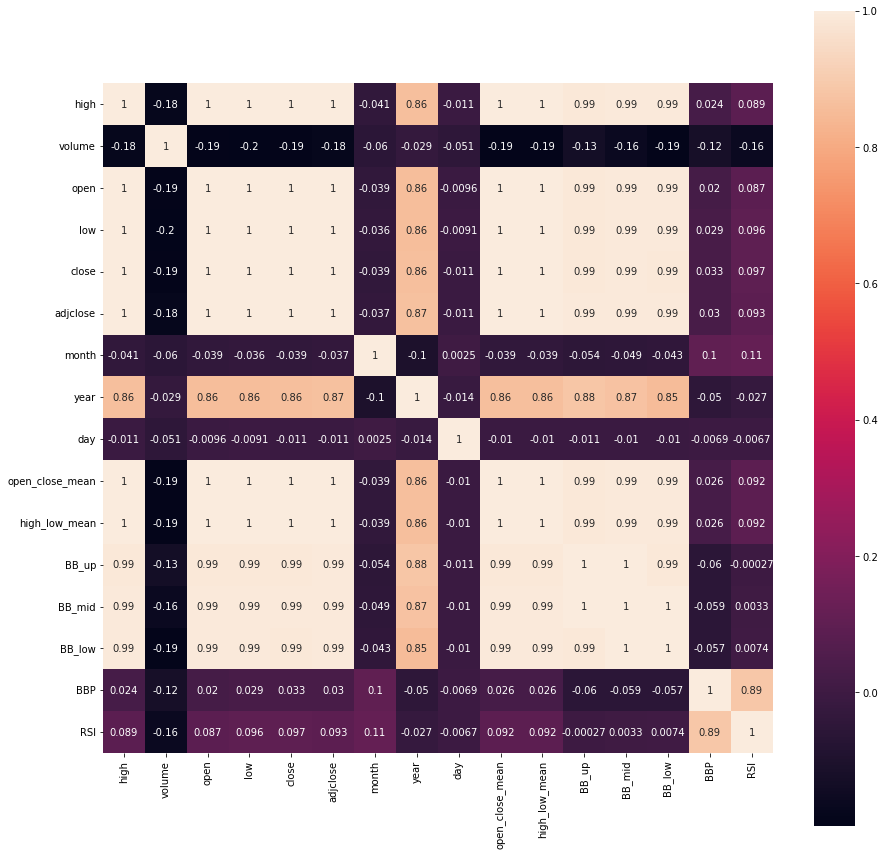




SPGI
            high   volume        open         low       close    adjclose  \
19     49.049999  1813800   48.290001   48.160000   49.029999   41.247784   
20     48.919998  1327000   48.810001   48.459999   48.570000   40.860802   
21     48.849998  1247500   48.740002   48.200001   48.290001   40.625244   
22     49.250000  1619600   48.799999   48.560001   49.020000   41.239376   
23     49.689999  2063600   48.730000   48.680000   49.610001   41.735718   
...          ...      ...         ...         ...         ...         ...   
2511  395.779999  3693900  384.160004  380.480011  388.130005  388.130005   
2512  402.109985  3034100  401.399994  390.980011  391.510010  391.510010   
2513  385.739990  2767300  381.279999  373.839996  382.750000  382.750000   
2514  388.649994  2252100  385.000000  379.279999  379.679993  379.679993   
2515  386.339996  2460290  383.529999  373.179993  377.000000  377.000000   

                    date  month  year  day  open_close_mean  high_l

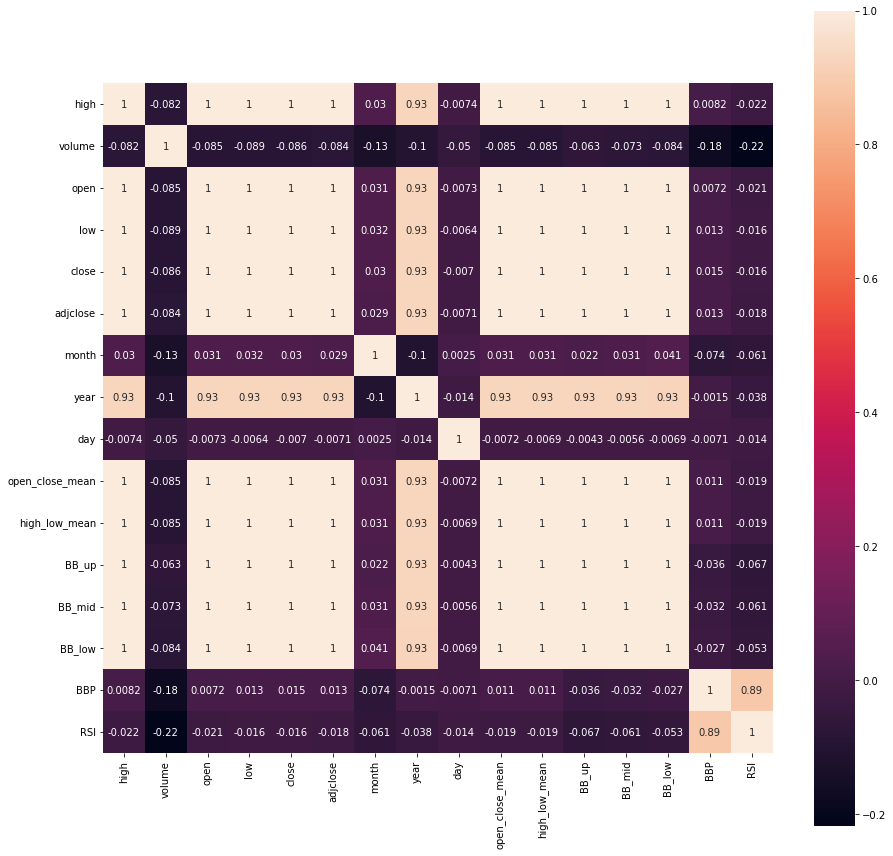




LYB
            high   volume        open         low       close    adjclose  \
19     42.880001  3618500   41.520000   41.290001   42.830002   22.630198   
20     44.439999  4332400   42.660000   42.619999   44.070000   23.285379   
21     44.599998  3779800   44.419998   43.590000   44.279999   23.396334   
22     45.150002  3275000   44.889999   44.000000   44.130001   23.317076   
23     44.279999  2153300   43.980000   43.400002   43.869999   23.179707   
...          ...      ...         ...         ...         ...         ...   
2511   97.830002  2107300   95.440002   93.669998   96.000000   96.000000   
2512  100.610001  2294000   98.000000   97.650002   98.370003   98.370003   
2513   99.970001  1971700   96.779999   96.779999   99.739998   99.739998   
2514  104.180000  2993400  100.330002  100.190002  103.430000  103.430000   
2515  105.839996  3399205  104.760002  102.911003  103.870003  103.870003   

                    date  month  year  day  open_close_mean  high_lo

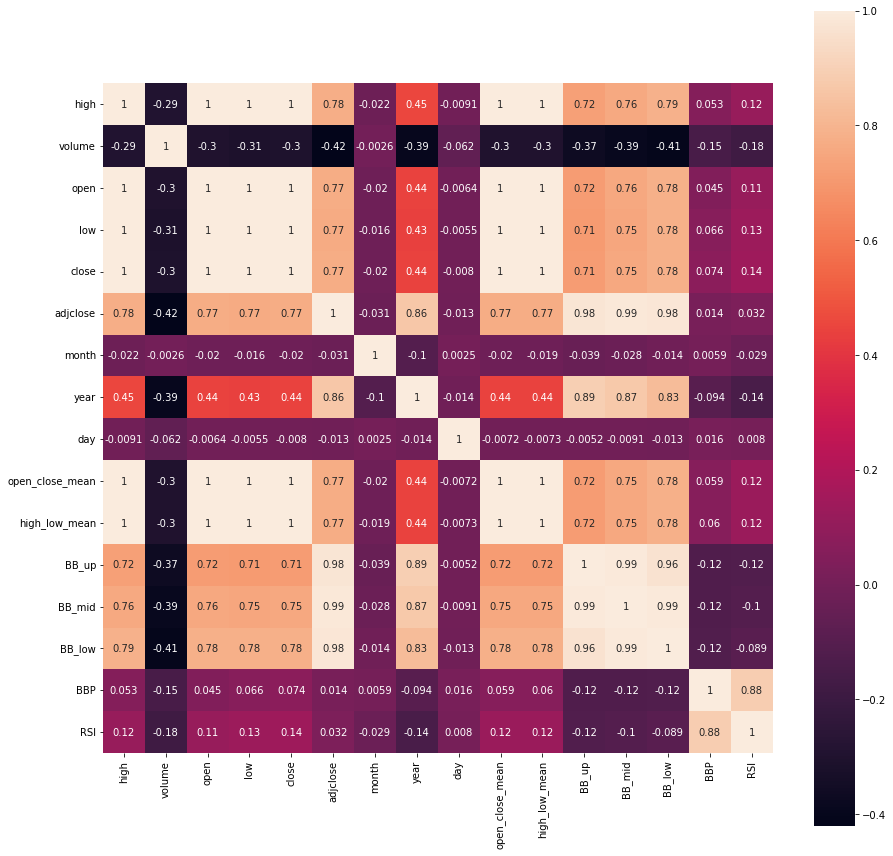




BLL
           high   volume       open        low      close   adjclose  \
19    21.504999  3612400  21.395000  21.340000  21.405001  19.629742   
20    21.535000  2842400  21.370001  21.360001  21.385000  19.611403   
21    21.434999  3511000  21.215000  21.075001  21.389999  19.615990   
22    21.645000  1859200  21.575001  21.344999  21.575001  19.785646   
23    21.629999  2374400  21.495001  21.485001  21.514999  19.730619   
...         ...      ...        ...        ...        ...        ...   
2511  91.220001  2085400  89.470001  87.639999  87.790001  87.790001   
2512  89.650002  3066300  89.349998  85.910004  86.410004  86.410004   
2513  87.209999  1774200  85.550003  84.150002  87.059998  87.059998   
2514  88.620003   973500  87.440002  85.519997  85.559998  85.559998   
2515  89.849998  2084546  87.230003  86.199997  88.440002  88.440002   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012   12        

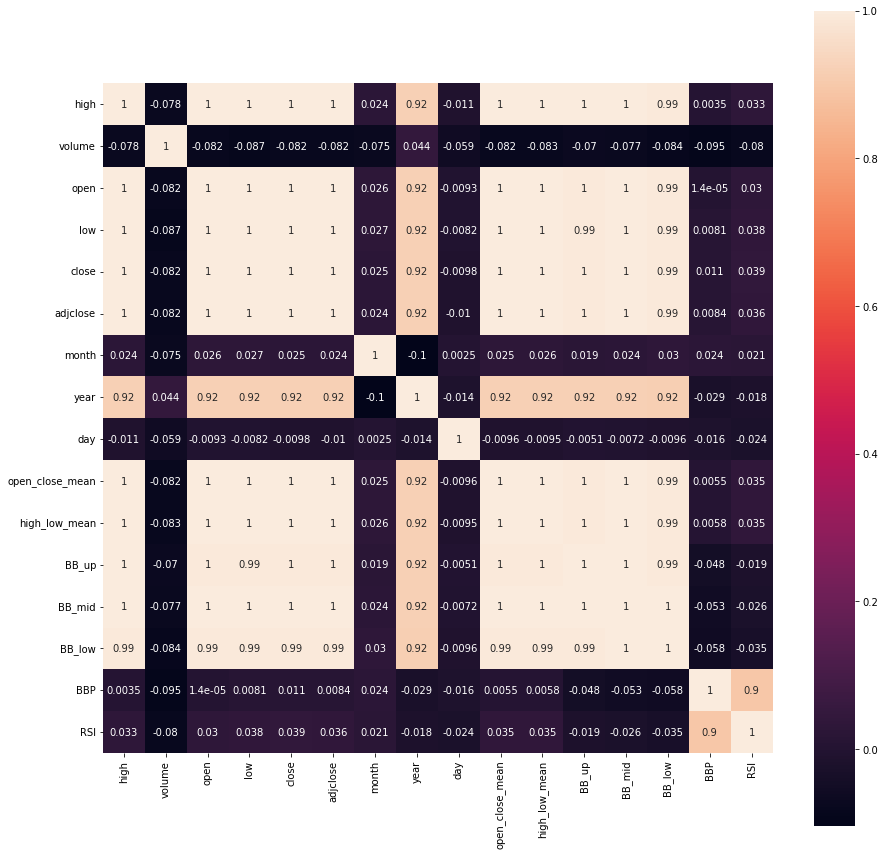




APD
            high   volume        open         low       close    adjclose  \
19     82.941719  1222935   80.832565   80.814064   82.784462   64.072235   
20     82.858467  1149860   82.645699   81.600372   81.646622   63.191563   
21     82.580940  1004249   82.062904   81.489365   82.469933   63.828796   
22     83.728027   804588   82.987976   82.488434   83.367256   64.523277   
23     83.024979  1292876   82.987976   81.776131   81.803886   63.313271   
...          ...      ...         ...         ...         ...         ...   
2511  225.110001  1867300  221.509995  216.240005  218.770004  218.770004   
2512  229.720001  1433800  225.259995  224.449997  227.000000  227.000000   
2513  227.949997  1538800  223.470001  222.539993  227.600006  227.600006   
2514  230.869995  1488900  229.940002  219.289993  219.380005  219.380005   
2515  222.369995  2212755  220.169998  216.410004  218.270004  218.270004   

                    date  month  year  day  open_close_mean  high_lo

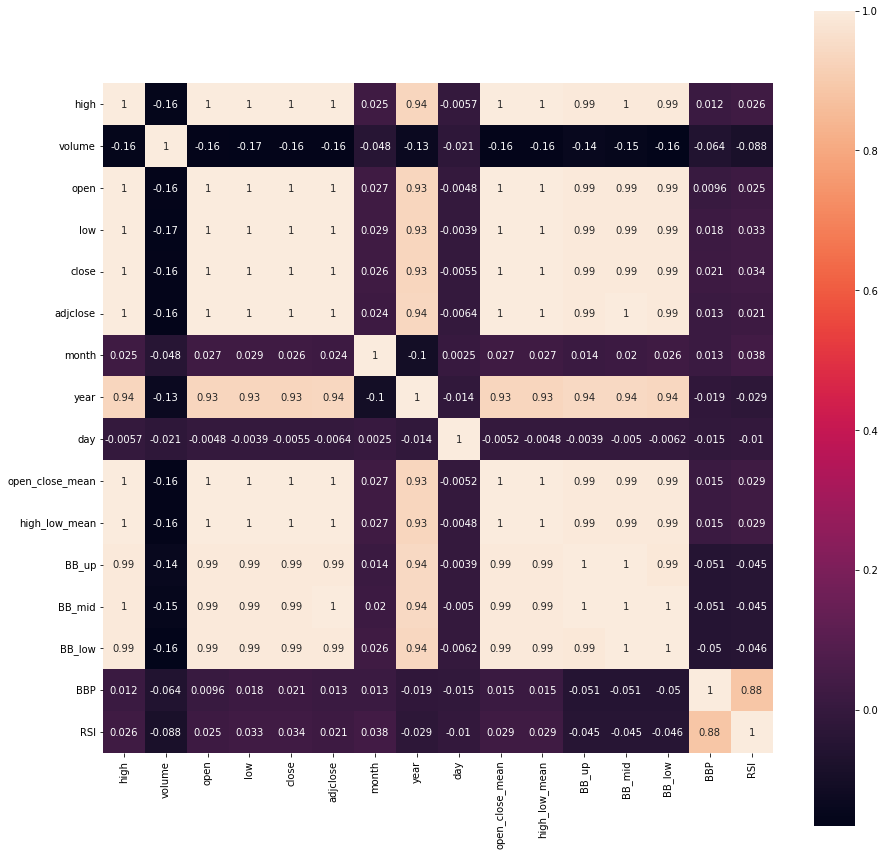




MAA
            high  volume        open         low       close    adjclose  \
19     66.000000  299600   65.620003   65.199997   65.910004   46.053436   
20     66.300003  134500   65.910004   65.650002   65.760002   45.948624   
21     67.209999  246800   65.879997   65.879997   66.900002   46.745186   
22     67.489998  230600   67.489998   66.830002   67.040001   46.842983   
23     67.080002  190700   66.989998   66.489998   66.500000   46.465679   
...          ...     ...         ...         ...         ...         ...   
2511  212.350006  599100  212.190002  207.070007  208.179993  208.179993   
2512  215.460007  678600  211.789993  210.429993  211.699997  211.699997   
2513  211.460007  623800  210.119995  208.740005  211.169998  211.169998   
2514  214.070007  456600  212.119995  207.979996  208.470001  208.470001   
2515  210.809998  450390  210.809998  204.190002  205.419998  205.419998   

                    date  month  year  day  open_close_mean  high_low_mean  \
19

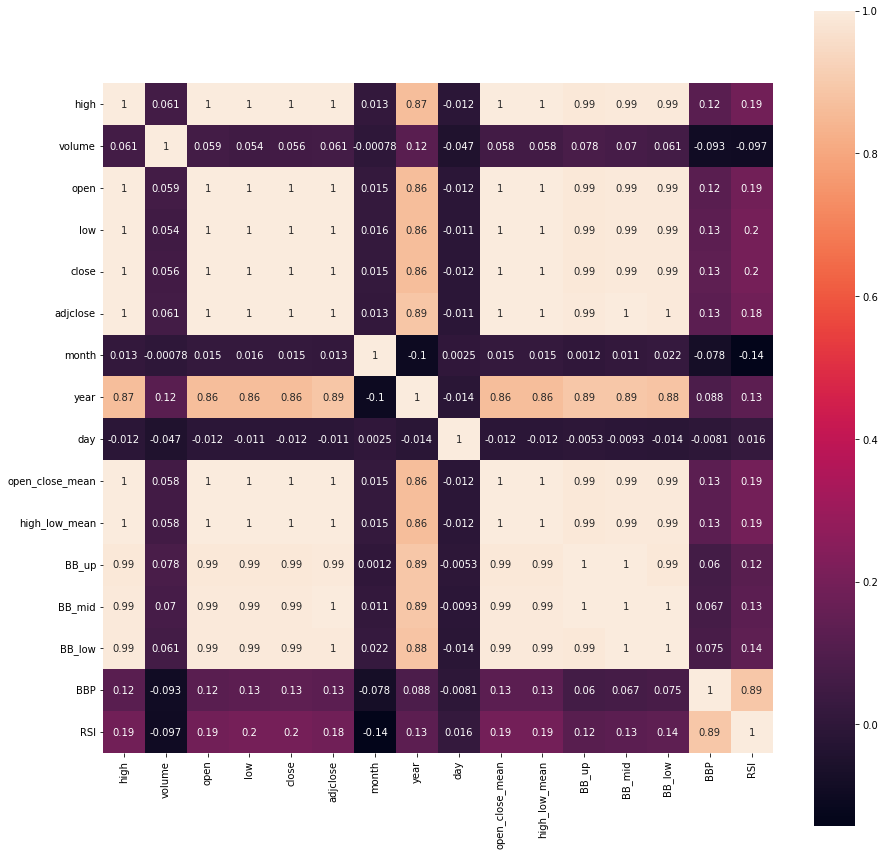




CBRE
           high   volume       open        low      close   adjclose  \
19    18.900000  3136800  18.280001  18.250000  18.860001  18.860001   
20    18.770000  2864600  18.690001  18.160000  18.209999  18.209999   
21    18.549999  2200400  18.379999  18.110001  18.360001  18.360001   
22    19.030001  2454900  18.600000  18.520000  18.840000  18.840000   
23    18.690001  2538100  18.680000  18.260000  18.340000  18.340000   
...         ...      ...        ...        ...        ...        ...   
2511  87.889999  3232300  87.099998  84.620003  84.849998  84.849998   
2512  89.150002  2234000  88.019997  86.989998  87.769997  87.769997   
2513  88.160004  2092800  85.879997  85.510002  87.879997  87.879997   
2514  89.360001  1441900  89.139999  87.459999  87.570000  87.570000   
2515  89.800003  1481826  89.139999  86.540001  87.400002  87.400002   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012   12       

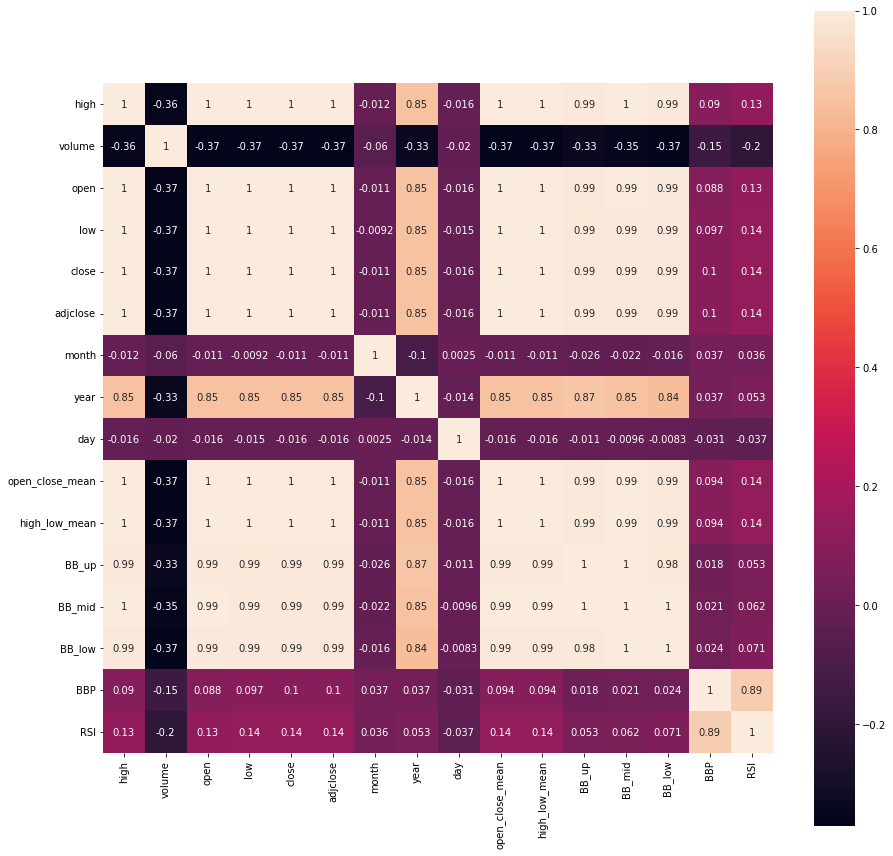




ARE
            high   volume        open         low       close    adjclose  \
19     71.660004   241800   70.110001   70.010002   71.639999   52.956112   
20     71.970001   458600   71.529999   71.059998   71.150002   52.593895   
21     73.180000   306200   71.690002   71.589996   72.849998   53.850536   
22     74.080002   319000   73.269997   72.830002   73.830002   54.574963   
23     73.739998   180100   73.410004   72.910004   72.949997   53.924446   
...          ...      ...         ...         ...         ...         ...   
2511  193.889999  1164000  188.839996  187.710007  190.800003  190.800003   
2512  195.020004   825900  193.399994  191.970001  192.210007  192.210007   
2513  191.619995   861500  190.000000  189.460007  191.380005  191.380005   
2514  192.889999   928000  191.970001  187.520004  188.429993  188.429993   
2515  190.539993   701862  189.750000  187.429993  188.429993  188.429993   

                    date  month  year  day  open_close_mean  high_lo

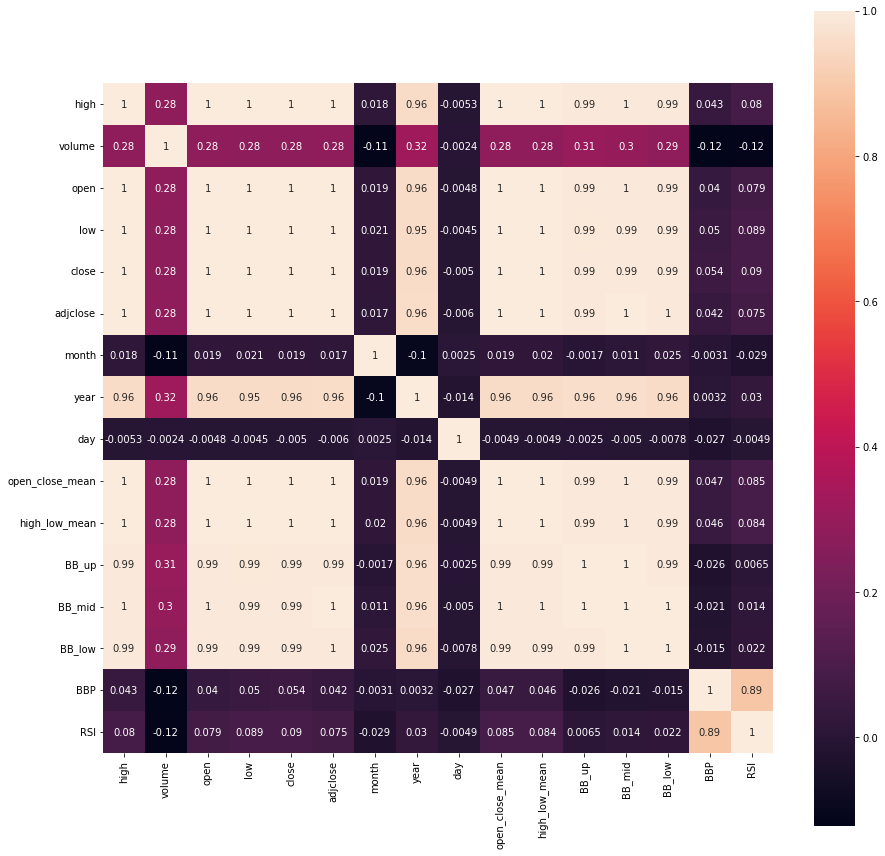




PXD
            high   volume        open         low       close    adjclose  \
19    108.269997  2039700  103.989998  103.820000  107.830002   97.961082   
20    108.239998  1082100  107.449997  106.550003  106.690002   96.925438   
21    108.410004  1521600  107.269997  103.849998  104.599998   95.026695   
22    109.220001  2058500  106.000000  105.809998  107.690002   97.833916   
23    107.129997  1967100  107.129997  104.660004  105.720001   96.044212   
...          ...      ...         ...         ...         ...         ...   
2511  243.479996  5049100  241.059998  223.300003  237.369995  237.369995   
2512  233.970001  4261700  233.820007  223.750000  230.399994  230.399994   
2513  238.580002  3069200  234.300003  229.970001  237.750000  237.750000   
2514  238.160004  2262900  234.559998  232.059998  232.490005  232.490005   
2515  233.059998  2622399  231.330002  221.699997  229.339996  229.339996   

                    date  month  year  day  open_close_mean  high_lo

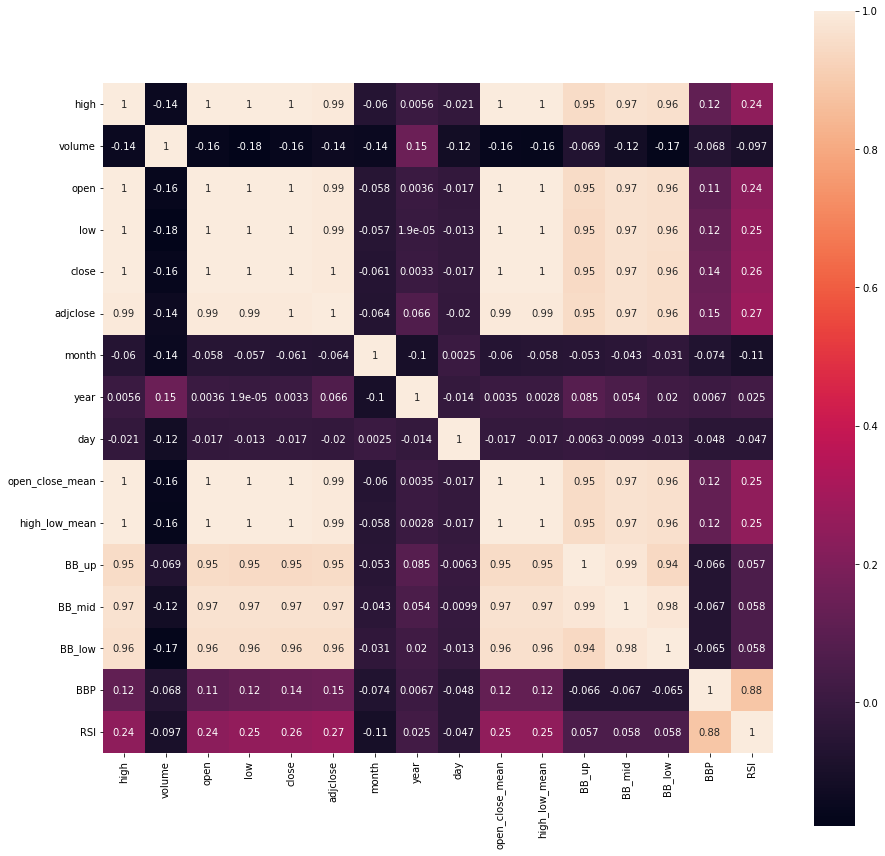




CTRA
           high    volume       open     low      close   adjclose  \
19    15.615000   7148800  14.905000  14.905  15.340000  13.403711   
20    15.515000   5702800  15.265000  15.235  15.300000  13.368756   
21    15.380000   9214800  14.965000  14.420  14.770000  12.905659   
22    15.610000   5386600  15.055000  14.985  15.285000  13.355649   
23    15.390000   7334000  15.200000  15.140  15.260000  13.333808   
...         ...       ...        ...     ...        ...        ...   
2511  27.879999  17197300  27.809999  25.650  26.010000  26.010000   
2512  25.730000  14117100  25.650000  24.680  25.459999  25.459999   
2513  26.530001  12468800  25.410000  25.010  26.330000  26.330000   
2514  26.309999  10657500  26.309999  25.350  25.629999  25.629999   
2515  25.040001  22738659  24.889999  22.705  23.129999  23.129999   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012   12        15.122500      15.26000

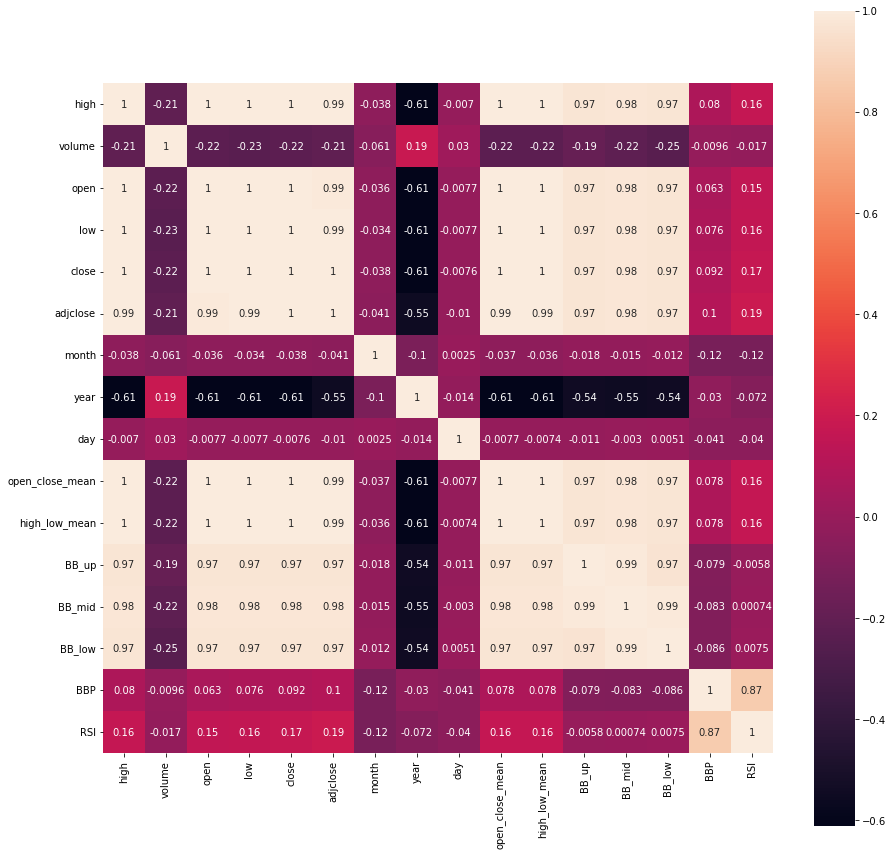




APA
           high    volume       open        low      close   adjclose  \
19    95.180000   2079000  93.250000  92.540001  94.900002  80.049652   
20    94.870003   2499300  94.690002  93.309998  93.650002  78.995255   
21    94.680000   2961600  94.160004  91.800003  92.269997  77.831184   
22    94.750000   2299900  93.190002  92.900002  94.550003  79.754440   
23    94.440002   2804400  94.070000  91.940002  92.300003  77.856522   
...         ...       ...        ...        ...        ...        ...   
2511  41.200001  16485200  39.130001  37.459999  38.630001  38.630001   
2512  38.900002  13634700  36.990002  36.360001  38.700001  38.700001   
2513  40.200001  10804000  39.060001  38.240002  40.040001  40.040001   
2514  40.150002   8393800  39.560001  39.000000  39.049999  39.049999   
2515  38.480000  11742709  38.009998  36.439999  37.580002  37.580002   

                    date  month  year  day  open_close_mean  high_low_mean  \
19   2012-04-12 08:30:00      4  2012 

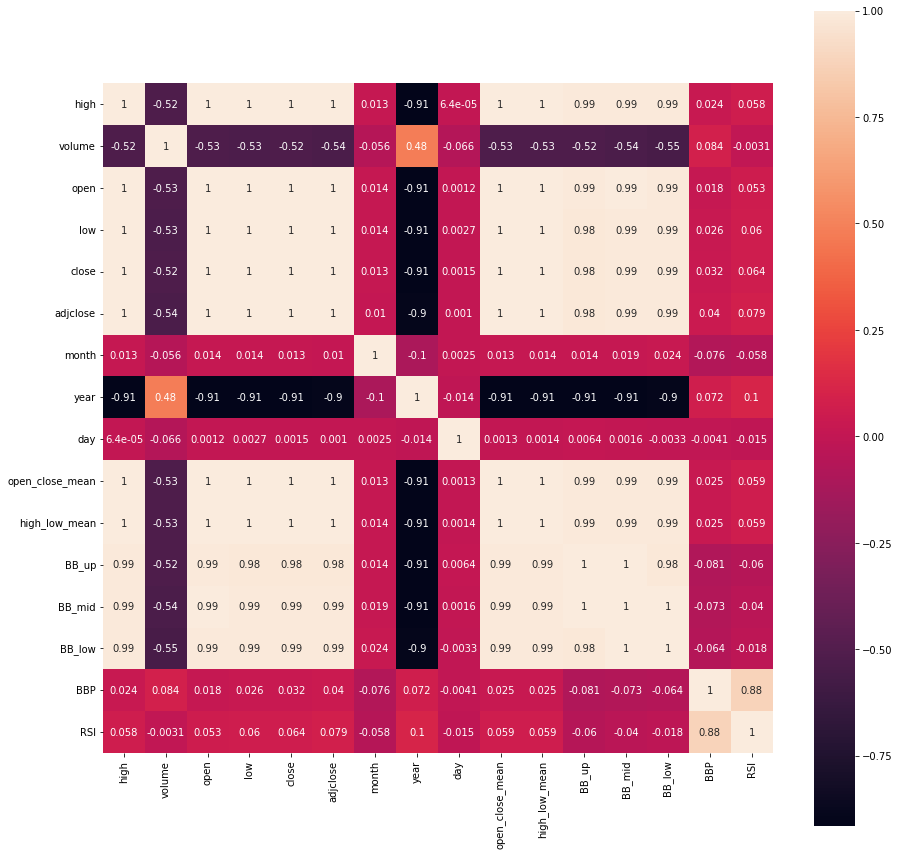

In [167]:
for symbol in constituent_symbols:
    print(symbol)
    print(dfs[symbol])
    print()
    print("--- Shape ---")
    print("Number of records:", dfs[symbol].shape[0])
    print("Number of attributes:", dfs[symbol].shape[1])
    print()
    print("--- Types ---")
    print(dfs[symbol].dtypes)
    print()
    print("--- Missing values in each attribute ---")
    print(dfs[symbol].isnull().sum())
    print()
    print("--- Statistical measures for each attribute ---")
    print(dfs[symbol].describe())
    print()
    print("--- Correlation ---")
    plt.figure(figsize=(15, 15))
    sns.heatmap(dfs[symbol].corr(), square=True, annot=True)
    plt.show()
    print()
    print()
    print()